<a href="https://colab.research.google.com/github/spour/DeepExplain/blob/master/clean_checking_model_structures_with_de_dlipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install simdna==0.4.2 --no-deps
# !pip install simdna-dragonn==0.1 --no-deps
!pip install dragonn --no-deps
!pip install numpy keras tensorflow-gpu deeplift shapely matplotlib plotnine scikit-learn pydot_ng h5py seqdataloader simdna_dragonn abstention
!pip install shap
!pip install vizsequence

     |████████████████████████████████| 458.3 MB 12 kB/s 
     |████████████████████████████████| 107 kB 51.0 MB/s 
     |████████████████████████████████| 648 kB 56.3 MB/s 
     |████████████████████████████████| 12.5 MB 146 kB/s 
     |████████████████████████████████| 16.9 MB 67 kB/s 
     |████████████████████████████████| 233 kB 58.6 MB/s 
     |████████████████████████████████| 64 kB 3.0 MB/s 
     |████████████████████████████████| 10.3 MB 27.8 MB/s 
     |████████████████████████████████| 23.9 MB 14 kB/s 
     |████████████████████████████████| 41 kB 99 kB/s 
     |████████████████████████████████| 9.9 MB 15.4 MB/s 
     |████████████████████████████████| 47 kB 3.2 MB/s 
  Created wheel for deeplift: filename=deeplift-0.6.13.0-py3-none-any.whl size=36449 sha256=5b77abc9f5703fa7603b42e965dee460fc99da3152efa42aebeff9f7a814ab99
  Stored in directory: /root/.cache/pip/wheels/5f/0f/15/3cb70dbd2147a5c948da210c6a283d87ea19c8e8ecb941b21e
  Created wheel for deeptoolsintervals: filename

     |████████████████████████████████| 356 kB 4.0 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491647 sha256=7e56bc610ebab141ebbae77aaf1c62cc9c5c8af3d0b4cd2704e748d7477b28fa
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Created wheel for vizsequence: filename=vizsequence-0.1.1.0-py3-none-any.whl size=3251 sha256=c2995b8fc24d0a39e87990efdd90f8e555fcc1dfd628d1f3a65368bd715fecc6
  Stored in directory: /root/.cache/pip/wheels/71/9f/f5/485628dc7615245c7fe9be63dbab7316b732778f54df676264
Successfully built vizsequence


In [65]:
import tensorflow as tf
from dragonn.simulations import * 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Activation, Flatten, Dense, Dropout
import tensorflow.keras as keras
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.metrics import CategoricalAccuracy, AUC
from tensorflow.keras.callbacks import EarlyStopping, History
import simdna.synthetic as synthetic
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split
import tensorflow.keras.initializers as initializers
from tensorflow.keras.layers import AveragePooling1D
import shap
from vizsequence import viz_sequence
import gzip
from tensorflow.keras.layers import GlobalMaxPooling1D

In [10]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


#shuffled background
from collections import defaultdict
from random import shuffle


# compile the dinucleotide edges
def prepare_edges(s):
    edges = defaultdict(list)
    for i in range(len(s) - 1):
        edges[tuple(s[i])].append(s[i + 1])
    return edges


def shuffle_edges(edges):
    # for each character, remove the last edge, shuffle, add edge back
    for char in edges:
        last_edge = edges[char][-1]
        edges[char] = edges[char][:-1]
        the_list = edges[char]
        shuffle(the_list)
        edges[char].append(last_edge)
    return edges


def traverse_edges(s, edges):
    generated = [s[0]]
    edges_queue_pointers = defaultdict(lambda: 0)
    for i in range(len(s) - 1):
        last_char = generated[-1]
        generated.append(edges[tuple(last_char)][edges_queue_pointers[tuple(last_char)]])
        edges_queue_pointers[tuple(last_char)] += 1
    if isinstance(generated[0], str):
        return "".join(generated)
    else:
        import numpy as np
        return np.asarray(generated)


def dinuc_shuffle(s):
    if isinstance(s, str):
        s = s.upper()
    return traverse_edges(s, shuffle_edges(prepare_edges(s)))


def onehot_dinuc_shuffle(s):
    s = np.squeeze(s)
    argmax_vals = "".join([str(x) for x in np.argmax(s, axis=-1)])
    shuffled_argmax_vals = [int(x) for x in traverse_edges(argmax_vals,
                            shuffle_edges(prepare_edges(argmax_vals)))]
    to_return = np.zeros_like(s)
    to_return[list(range(len(s))), shuffled_argmax_vals] = 1
    return to_return

shuffle_several_times = lambda s: np.array([onehot_dinuc_shuffle(s) for i in range(10)])

            
# onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in sequences])

In [3]:
! [[ ! -f sequences.simdata.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
! [[ ! -f test.txt.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelJson.json ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelWeights.h5 ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelWeights.h5

keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)
import gzip 
data_filename = "sequences.simdata.gz"
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = [x.decode("utf-8").rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)
onehot_data_premade = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])
labels_premade = data.labels




--2021-09-15 15:19:09--  https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 629502 (615K) [application/octet-stream]
Saving to: ‘sequences.simdata.gz’

sequences.simdata.g 100%[===================>] 614.75K  --.-KB/s    in 0.04s   

2021-09-15 15:19:10 (15.1 MB/s) - ‘sequences.simdata.gz’ saved [629502/629502]

--2021-09-15 15:19:10--  https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (r

In [ ]:
print(onehot_data_premade.shape)
!zcat sequences.simdata | head

(800, 200, 4)
seqName	sequence	embeddings	task1	task2	task3
empty_1732	AGCTCTTTTGGCGGACCGAGTTCGTCGGACTTTCGCTAAATTGACCATTAACAGGAGGATACCCGGGTGTCTCGGGAAGGTCGTAATACGGTAATTACGGATGTGAGAGCGCACACATCCTTTGGATGATACATGATCTCGCCGTATATGGCCTAGGTCAAAAGGACAGTCTCGCTAATCGCAATAATGCAGCTAACCGA		0	0	0
gata_only_1527	TGCAGATAAGAACTTTGGGAATATGGTAGGAAAAACCCCTGAAGTGAGATCCAAAAAATATAGACTGGCGCGGTGGCAATGCCCTTGTTAATGCTGGGAATCAAAAAATCGAAACTCTCAGCAGATAAGATATGCAGACCTGCTCGTGGAGACAAAAAGTATTGTTACTGCGTAAACCATTAGTACGTTGCCGAGTACCG	pos-120_GATA_disc1-GCAGATAAGA,pos-1_GATA_disc1-GCAGATAAGA	0	1	0
gata_tal1_62	AGATTATAGGCCCTCCACCAGATAAGATATAGCGTTCGAGGGTCAGAAGGTAGTTCTGAAGATCTCTTCATTGTGAAAGGCCTCATATGATGAGCTTCTCCATTCTCAGCTGACAGGCAAAACAATTGATCAGCGCTTAGGCGCCAGATGTTTACTCCCGTTAAGTCAACTTAGCTGTGTTCGTCAAATCCGCAACGCGG	pos-17_GATA_disc1-CCAGATAAGA,pos-139_TAL1_known1-GGCGCCAGATGTTTAC	1	1	1
empty_1289	TTTGGGCGCGGAAGAAGTCGCTCGCCTTTCTGTACTTGAAAATGATTACATGTAAGGATGTAACTCAATCGCAACATTGTCATTGGGTTCCATCGCCCTAGCGGTAGTAGGTTTTACCTCCAACTTGACAACCCTTCGTAAATA

In [4]:
#for premade

model1 = Sequential()
model1.add(Conv1D(filters=50, kernel_size=(11), padding='valid', input_shape=onehot_data_premade.shape[1::], 
                  kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
# model1.add(BatchNormalization())
model1.add(Activation('relu'))
# model1.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
model1.add(Conv1D(filters=50, kernel_size=(11), padding='valid',  
                  kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
model1.add(Activation('relu'))
model1.add(AveragePooling1D(pool_size=(180,), strides=(180,)))
model1.add(Flatten())
model1.add(Dense(50, kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg'))) #there are three classes therefore 3 possibilities
model1.add(Activation("relu"))
model1.add(Dropout(0.5))
model1.add(Dense(3, kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
model1.add(Activation("sigmoid"))

In [ ]:

X_train_premade, X_test_premade, y_train_premade, y_test_premade = train_test_split(onehot_data_premade, labels_premade, test_size=0.33, random_state=42, stratify = labels_premade)


model1.compile(optimizer='adam',
                               loss='binary_crossentropy',
                               metrics=[tf.keras.metrics.BinaryCrossentropy(),
                                        tf.keras.metrics.AUC(curve='ROC'),
                                        tf.keras.metrics.AUC(curve='PR')])

hist = model1.fit(x=X_train_premade,
                                  y=y_train_premade,
                                  batch_size=16,
                                  epochs=60, # 100
                # callbacks=[EarlyStopping(patience=7, monitor='val_loss'),   # If val_loss doesn't decrease after 3 epochs, stop training
                #                   History()],
                validation_split = 0.1)


model1.evaluate(X_test_premade, y_test_premade)

Train on 482 samples, validate on 54 samples
Epoch 1/60
482/482 [==============================] - 1s 3ms/sample - loss: 0.6725 - binary_crossentropy: 0.6725 - auc_4: 0.6069 - auc_5: 0.5265 - val_loss: 0.6602 - val_binary_crossentropy: 0.6602 - val_auc_4: 0.6087 - val_auc_5: 0.4134
Epoch 2/60
482/482 [==============================] - 1s 2ms/sample - loss: 0.6707 - binary_crossentropy: 0.6707 - auc_4: 0.5990 - auc_5: 0.5226 - val_loss: 0.6559 - val_binary_crossentropy: 0.6559 - val_auc_4: 0.6046 - val_auc_5: 0.4041
Epoch 3/60
482/482 [==============================] - 1s 2ms/sample - loss: 0.6704 - binary_crossentropy: 0.6704 - auc_4: 0.6041 - auc_5: 0.5289 - val_loss: 0.6658 - val_binary_crossentropy: 0.6658 - val_auc_4: 0.6160 - val_auc_5: 0.4100
Epoch 4/60
482/482 [==============================] - 1s 2ms/sample - loss: 0.6679 - binary_crossentropy: 0.6679 - auc_4: 0.6078 - auc_5: 0.5318 - val_loss: 0.6577 - val_binary_crossentropy: 0.6577 - val_auc_4: 0.6178 - val_auc_5: 0.4239
Epo

[0.24023102991508716, 0.240231, 0.96542066, 0.95791256]

In [ ]:
model1.evaluate(X_test_premade, y_test_premade)
# print(X_test_premade.shape)
# print(X_train_premade.shape)

[0.24023102991508716, 0.240231, 0.96542066, 0.95791256]

In [ ]:
model1.summary()
from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
hist.history.keys()

dict_keys(['loss', 'binary_crossentropy', 'auc_4', 'auc_5', 'val_loss', 'val_binary_crossentropy', 'val_auc_4', 'val_auc_5'])

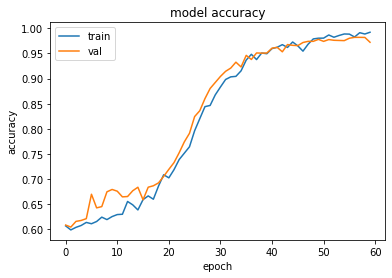

In [ ]:
plt.plot(hist.history['auc_4'])
plt.plot(hist.history['val_auc_4'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

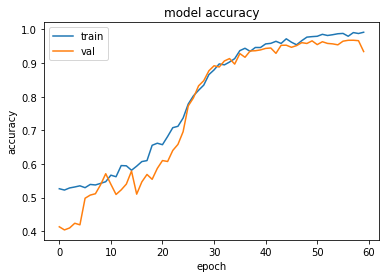

In [ ]:
plt.plot(hist.history['auc_5'])
plt.plot(hist.history['val_auc_5'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# !pip uninstall matplotlib
# !pip install matplotlib

In [ ]:
# print(seqs_to_explain.shape)
# print(np.sum(raw_shap_explanations,axis=-1)[:,:,None].shape)
# print(raw_shap_explanations.shape)

NameError: ignored

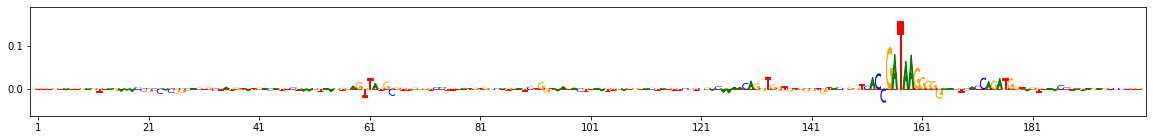

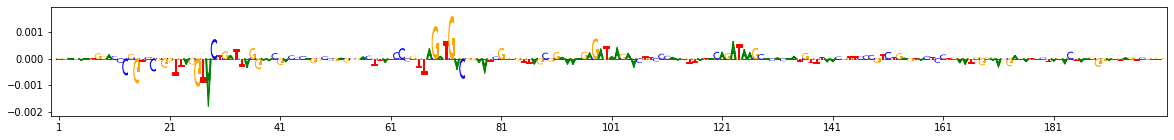

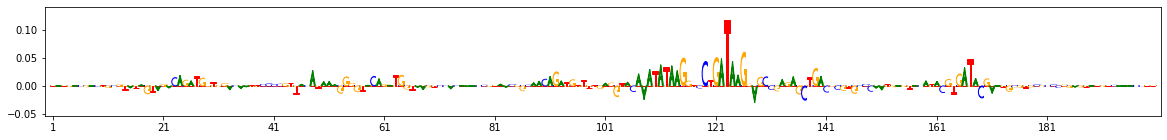

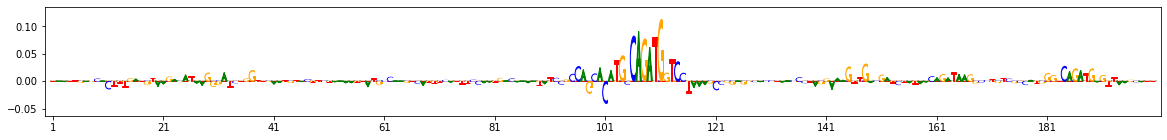

In [ ]:
import shap
import matplotlib.pyplot as plt

from vizsequence import viz_sequence
seqs_to_explain = onehot_data_premade[[0,1,3,9]] #these three are positive for task 0
dinuc_shuff_explainer = shap.DeepExplainer((model1.input, model1.output[:,0]), shuffle_several_times)
raw_shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain, check_additivity=False)

#project the importance at each position onto the base that's actually present
dinuc_shuff_explanations = np.sum(raw_shap_explanations,axis=-1)[:,:,None]*seqs_to_explain
for dinuc_shuff_explanation in dinuc_shuff_explanations:
    viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)

mine multi


In [ ]:
#multi
data = simulations.simulate_multi_motif_embedding(
    motif_names = ["SIX5_known1", "CTCF_known1", "ZNF143_known2"],
    seq_length = 300,
    min_num_motifs = 1,
    max_num_motifs=3,
    num_seqs = 5000, 
    GC_fraction=0.4,
)
mm_sequences = data[0]
mm_labels = data[1]


<function tuple.count>

SyntaxError: ignored

In [ ]:
simulations.simulate_single_motif_detection()

(array(['ATTACCGTAATCTACTATTAAGTCACAACCAAACAATGGATTACTTTCTGCGTTGGAATCAGTGCCGTGCCAATTGCAGTTGTAGTGCAGTATTTTTGGCATTCCCATAATGCACTGTTTATGAAATAAGCAAGAATCCCACCAATGAGTAAATATGGATTGAGCGCGAATTCTCTTCAATATTGATTTGCCAGCAAGACCTTAACTTCAGTTCTGCTATAATATGTCCATGTTAGAAATTTCGTCGAAATGTCATTAGAATAATCAAATATCTTAACAGAATAGCCATTTAAGTGGGAGCAAATCGGGCGCCACTTGGGGGCACTCGATCTAGTATATTTCAGTATATACTTTTTGACATGAATTGGTCCCAAGCGACAAATCCGAAGGGCGTACCACGTTAGAAGTATTCGTCTTGTTTGAAAGTAGTCGATATTGATTATTGTCTTCTCACATTAGCAAATAACAGGTAAGAGAGTTTGCTTGCAATATGTTTAGGC',
        'ATAATGCGTAGTTAGAGATTCATTTATGCCTTAGATCTTGAGAATCTATTCACCAAAGTAATTTGCTAGACCCAATCGATCGTTATTCCGTCTTATAAGACACTTAATAAAAAGTGTGCGTGAATGCGGGACCATCGTTTTATATTTAATCCTAGCACTTAGATAACTCATTTCCAGCCTTGAGCTTTTGTTAACGACGATGCACCTGGATCCATCTTTTTTTAGGTTTTCTGCCTGAAGGTACTAAGAAAGGAATGATACTTATGTTCGGTTTTTAATTGCCTTGATCAAGAACTTTGGGGGTTCGCCGGGTAGTTGCCTTGTTTCCTCTCCCACCAAATGATAGTGCTTTCCCATAATGCAATGAGTGGCTTAGCGAAACTTTGACGAGTATACTAGCTTACTGATCCATGTTAGCTTAATCAAGGTGGACAGAACCCGATGGACGGTTCCCAAAAGTGGAAGTCAACGAAGTCGGA

In [ ]:
onehot_data_mm = np.array([one_hot_encode_along_channel_axis(seq) for seq in mm_sequences])

In [ ]:
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(onehot_data_mm, mm_labels, test_size=0.33, random_state=42, stratify = mm_labels)

In [ ]:
X_train_mm.shape

In [ ]:
model1 = Sequential()
model1.add(Conv1D(filters=50, kernel_size=(11), padding='valid', input_shape=onehot_data_mm.shape[1::], 
                  kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
# model1.add(BatchNormalization())
model1.add(Activation('relu'))
# model1.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
model1.add(Conv1D(filters=50, kernel_size=(11), padding='valid',  
                  kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
model1.add(Activation('relu'))
model1.add(AveragePooling1D(pool_size=(180,), strides=(180,)))
model1.add(Flatten())
model1.add(Dense(5, kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg'))) #there are three classes therefore 3 possibilities
model1.add(Activation("relu"))
model1.add(Dropout(0.5))
model1.add(Dense(3, kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
model1.add(Activation("sigmoid"))

In [ ]:

model1.compile(optimizer=tf.keras.optimizers.Adam(0.00001),
                               loss='binary_crossentropy',
                               metrics=[tf.keras.metrics.BinaryCrossentropy(),
                                        tf.keras.metrics.AUC(curve='ROC'),
                                        tf.keras.metrics.AUC(curve='PR')])

model1.fit(x=X_train_mm,
                                  y=y_train_mm,
                                  batch_size=16,
                                  epochs=100,
                # callbacks=[EarlyStopping(patience=7, monitor='val_loss'),   # If val_loss doesn't decrease after 3 epochs, stop training
                #                   History()],
                validation_split = 0.1)


model1.evaluate(X_test_mm, y_test_mm)

Train on 3015 samples, validate on 335 samples
Epoch 1/100
3015/3015 [==============================] - 10s 3ms/sample - loss: 0.6876 - binary_crossentropy: 0.6876 - auc_4: 0.5069 - auc_5: 0.6777 - val_loss: 0.6873 - val_binary_crossentropy: 0.6873 - val_auc_4: 0.4971 - val_auc_5: 0.6603
Epoch 2/100
3015/3015 [==============================] - 10s 3ms/sample - loss: 0.6855 - binary_crossentropy: 0.6855 - auc_4: 0.5109 - auc_5: 0.6783 - val_loss: 0.6862 - val_binary_crossentropy: 0.6862 - val_auc_4: 0.4925 - val_auc_5: 0.6564
Epoch 3/100
3015/3015 [==============================] - 10s 3ms/sample - loss: 0.6861 - binary_crossentropy: 0.6861 - auc_4: 0.5037 - auc_5: 0.6740 - val_loss: 0.6858 - val_binary_crossentropy: 0.6858 - val_auc_4: 0.4905 - val_auc_5: 0.6514
Epoch 4/100
3015/3015 [==============================] - 10s 3ms/sample - loss: 0.6851 - binary_crossentropy: 0.6851 - auc_4: 0.5077 - auc_5: 0.6774 - val_loss: 0.6855 - val_binary_crossentropy: 0.6855 - val_auc_4: 0.5025 - val

KeyboardInterrupt: ignored

monomotif


In [ ]:
simulate_single_motif_detection_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 500,
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

In [ ]:
simulation_data = get_simulation_data("simulate_single_motif_detection",
                                      simulate_single_motif_detection_parameters,
                                      validation_set_size=1000, test_set_size=1000)

In [ ]:
X_train = simulation_data.X_train.squeeze(1)
y_train = simulation_data.y_train
y_test = simulation_data.y_test
y_valid = simulation_data.y_valid
X_test = simulation_data.X_test.squeeze(1)
X_valid = simulation_data.X_valid.squeeze(1)

In [ ]:
X_train.shape[1]

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GlobalAveragePooling1D, MaxPooling1D

class GlobalMaxPooling1D_(GlobalMaxPooling1D):
    def call(self, inputs):
        steps_axis = 1 if self.data_format == 'channels_last' else 2
        return K.max(inputs, axis=steps_axis, keepdims=True)
    
    
class GlobalAveragePooling1D_(GlobalAveragePooling1D):
    def call(self, inputs, mask=None):
        steps_axis = 1 if self.data_format == 'channels_last' else 2
        return K.mean(inputs, axis=steps_axis, keepdims=True)

# max_pool1 = MaxPooling1D(pool_size=step_size, strides=1)(x)
# max_pool1 = Lambda(lambda s: backend.squeeze(s, axis=1))(max_pool1)

model = Sequential([Conv1D(filters=16, kernel_size=15, activation='relu', input_shape=X_train.shape[1:]),
                    MaxPooling1D(486),
                    Flatten(),
                    Dense(units=1),
                    Activation('sigmoid')
                   ])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, 
                    y_train, 
                    validation_split=0.2,  # use 20% of the data as the validation set
                    # callbacks=[EarlyStopping(patience=3),   # If val_loss doesn't decrease after 3 epochs, stop training
                    #            History()],
                    batch_size=512,  # On every optimization step, we use 512 examples from the training data
                    epochs=20) 

Train on 14400 samples, validate on 3600 samples
Epoch 1/20
14400/14400 [==============================] - 4s 254us/sample - loss: 0.7887 - accuracy: 0.5048 - val_loss: 0.6972 - val_accuracy: 0.5078
Epoch 2/20
14400/14400 [==============================] - 3s 237us/sample - loss: 0.6975 - accuracy: 0.4974 - val_loss: 0.6956 - val_accuracy: 0.4994
Epoch 3/20
14400/14400 [==============================] - 3s 237us/sample - loss: 0.6932 - accuracy: 0.5078 - val_loss: 0.6942 - val_accuracy: 0.4992
Epoch 4/20
14400/14400 [==============================] - 3s 235us/sample - loss: 0.6917 - accuracy: 0.5204 - val_loss: 0.6934 - val_accuracy: 0.4989
Epoch 5/20
14400/14400 [==============================] - 3s 233us/sample - loss: 0.6896 - accuracy: 0.5358 - val_loss: 0.6913 - val_accuracy: 0.5158
Epoch 6/20
14400/14400 [==============================] - 3s 238us/sample - loss: 0.6848 - accuracy: 0.5709 - val_loss: 0.6845 - val_accuracy: 0.5569
Epoch 7/20
14400/14400 [===========================

In [ ]:
model.evaluate(X_test, y_test)
# y_test[0:10]

[0.37575229978561403, 0.914]

In [ ]:
# from dragonn.utils import fasta_from_onehot
# fasta_from_onehot(simulation_data.X_train)
#should be (3, 200, 4), (3, 200, 1)
seqs_to_explain = X_train[[0,3,9]]
print(seqs_to_explain.shape)
print(np.expand_dims(np.sum(raw_shap_explanations,axis=-1)[:,:,None].squeeze(), -1).shape)


(3, 500, 4)
(4, 200, 1)


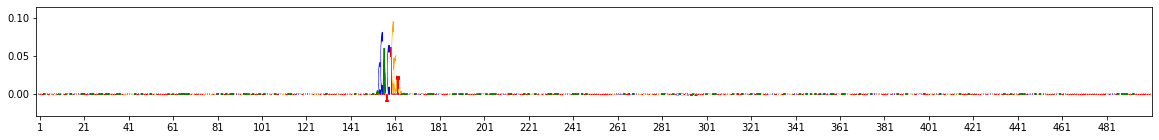

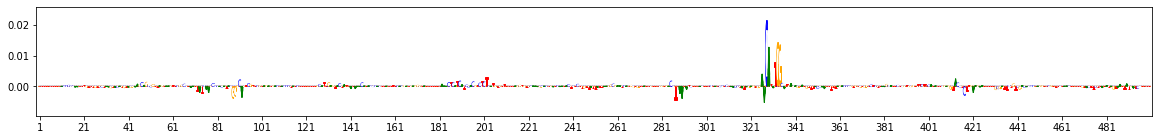

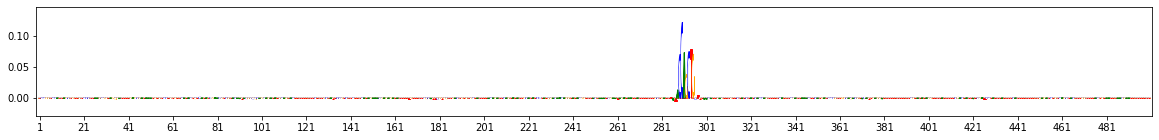

In [ ]:
#solution 1 with problem with global maxpooling
import shap
import matplotlib.pyplot as plt
#weird error with global maxpooling (https://github.com/slundberg/shap/issues/559)
from vizsequence import viz_sequence
seqs_to_explain = X_test[[1,6,9]] #these three are positive for task 0
dinuc_shuff_explainer = shap.DeepExplainer((model.input, model.output[:,0]), shuffle_several_times)
raw_shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain, check_additivity=False)

#project the importance at each position onto the base that's actually present
dinuc_shuff_explanations = np.expand_dims(np.sum(raw_shap_explanations,axis=-1)[:,:,None].squeeze(), -1)*seqs_to_explain
for dinuc_shuff_explanation in dinuc_shuff_explanations:
    viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)

In [5]:
import shapely
from shapely.geometry import Polygon
!pip show shapely

Name: Shapely
Version: 1.7.1
Summary: Geometric objects, predicates, and operations
Home-page: https://github.com/Toblerity/Shapely
Author: Sean Gillies
Author-email: sean.gillies@gmail.com
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: imgaug


In [17]:
!ls /usr/lib/

apt			 libdfalt.so		      pkgconfig
bfd-plugins		 libdfalt.so.0		      pkg-config.multiarch
binfmt.d		 libdfalt.so.0.0.0	      policykit-1
blt2.5			 libgdal.a		      policykit-1-gnome
clang			 libgdal.so		      python2.7
compat-ld		 libgdal.so.20		      python3
dbus-1.0		 libgdal.so.20.3.2	      python3.6
dconf			 libhdf4.settings	      python3.7
debug			 libmfhdfalt.a		      python3.8
dkms			 libmfhdfalt.la		      qt5
dpkg			 libmfhdfalt.so		      R
emacsen-common		 libmfhdfalt.so.0	      sasl2
environment.d		 libmfhdfalt.so.0.0.0	      software-properties
gcc			 libnvidia-gtk2.so.470.57.02  ssl
git-core		 libnvidia-gtk3.so.470.57.02  sudo
glib-networking		 libogdi.so		      sysctl.d
gnupg			 libogdi.so.3		      systemd
gnupg2			 libogdi.so.3.2		      sysusers.d
gold-ld			 libpsm1		      tar
groff			 libR.so		      tcl8.6
jni			 libvpf.so		      tclConfig.sh
jvm			 libvpf.so.3		      tclooConfig.sh
kernel			 libvpf.so.3.2		      tcltk
libann.so.0		 llvm-6.0		      tk8.6
libann.so.0.0.

In [ ]:
#CONCISE
import numpy as np
import copy
from io import StringIO
import gzip

import matplotlib.pyplot as plt

import sklearn.preprocessing
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

from collections import OrderedDict

from matplotlib import pyplot
from matplotlib.patches import PathPatch
from matplotlib.path import Path

from descartes.patch import Polygon, PolygonPath, PolygonPatch
from shapely.wkt import loads as load_wkt

from shapely import affinity
import re


def heatmap(w, vmin=None, vmax=None, diverge_color=False,
            ncol=1,
            plot_name=None, vocab=["A", "C", "G", "T"], figsize=(6, 2)):
    """Plot a heatmap from weight matrix w

    vmin, vmax = z axis range
    diverge_color = Should we use diverging colors?
    plot_name = plot_title
    vocab = vocabulary (corresponds to the first axis)
    """
    # Generate y and x values from the dimension lengths
    assert len(vocab) == w.shape[0]
    plt_y = np.arange(w.shape[0] + 1) + 0.5
    plt_x = np.arange(w.shape[1] + 1) - 0.5
    z_min = w.min()
    z_max = w.max()

    if vmin is None:
        vmin = z_min
    if vmax is None:
        vmax = z_max

    if diverge_color:
        color_map = plt.cm.RdBu
    else:
        color_map = plt.cm.Blues

    fig = plt.figure(figsize=figsize)
    # multiple axis
    if len(w.shape) == 3:
        #
        n_plots = w.shape[2]
        nrow = math.ceil(n_plots / ncol)
    else:
        n_plots = 1
        nrow = 1
        ncol = 1

    for i in range(n_plots):
        if len(w.shape) == 3:
            w_cur = w[:, :, i]
        else:
            w_cur = w
        ax = plt.subplot(nrow, ncol, i + 1)
        plt.tight_layout()
        im = ax.pcolormesh(plt_x, plt_y, w_cur, cmap=color_map,
                           vmin=vmin, vmax=vmax, edgecolors="white")
        ax.grid(False)
        ax.set_yticklabels([""] + vocab, minor=False)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_xticks(np.arange(w_cur.shape[1] + 1))
        ax.set_xlim(plt_x.min(), plt_x.max())
        ax.set_ylim(plt_y.min(), plt_y.max())

        # nice scale location:
        # http://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)

        if plot_name is not None:
            if n_plots > 0:
                pln = plot_name + " {0}".format(i)
            else:
                pln = plot_name
            ax.set_title(pln)
        ax.set_aspect('equal')
    return fig


# -----------------------------------------------------------------------
#
#
# Code adoped from https://github.com/kundajelab/dragonn, (c) 2016 Kundaje Lab


def standardize_polygons_str(data_str):
    """Given a POLYGON string, standardize the coordinates to a 1x1 grid.
    Input : data_str (taken from above)
    Output: tuple of polygon objects
    """
    # find all of the polygons in the letter (for instance an A
    # needs to be constructed from 2 polygons)
    path_strs = re.findall("\(\(([^\)]+?)\)\)", data_str.strip())

    # convert the data into a numpy array
    polygons_data = []
    for path_str in path_strs:
        data = np.array([
            tuple(map(float, x.split())) for x in path_str.strip().split(",")])
        polygons_data.append(data)

    # standardize the coordinates
    min_coords = np.vstack([data.min(0) for data in polygons_data]).min(0)
    max_coords = np.vstack([data.max(0) for data in polygons_data]).max(0)
    for data in polygons_data:
        data[:, ] -= min_coords
        data[:, ] /= (max_coords - min_coords)

    polygons = []
    for data in polygons_data:
        polygons.append(load_wkt(
            "POLYGON((%s))" % ",".join(" ".join(map(str, x)) for x in data)))

    return tuple(polygons)


# ----------------------
import string

# Geometry taken from JTS TestBuilder Monospace font with fixed precision model
# of 1000.0

A = """MULTIPOLYGON (
((30.0781 64.2031, 19.6719 26.9062, 40.4844 26.9062, 30.0781 64.2031)),
((24.125 72.9062, 36.0781 72.9062, 58.4062 0, 48.1875 0, 42.8281 19, 17.2812 19, 12.0156 0, 1.8125 0, 24.125 72.9062))
)"""

A = """MULTIPOLYGON (
((24.7631 57.3346, 34.3963 57.3346, 52.391 -1.422, 44.1555 -1.422, 39.8363
  13.8905, 19.2476 13.8905, 15.0039 -1.422, 6.781 -1.422, 24.7631 57.3346)),
((29.5608 50.3205, 21.1742 20.2623, 37.9474 20.2623, 29.5608 50.3205))
)"""

B = """MULTIPOLYGON (((18.0156 34.8125, 18.0156 8.1094, 29.6875 8.1094, 33.6763 8.2969, 37.0488 8.8594, 39.8052 9.7969, 41.9453 11.1094, 43.5483 12.8525, 44.6934 15.082, 45.3804 17.7979, 45.6094 21, 45.3682 24.3262, 44.6445 27.1797, 43.4385 29.5605, 41.75 31.4688, 39.5488 32.9316, 36.8047 33.9766, 33.5176 34.6035, 29.6875 34.8125, 18.0156 34.8125), 
  (18.0156 64.7969, 18.0156 42.8281, 29.5 42.8281, 32.8169 42.999, 35.6426 43.5117, 37.9771 44.3662, 39.8203 45.5625, 41.2183 47.1396, 42.2168 49.1367, 42.8159 51.5537, 43.0156 54.3906, 42.8188 56.9565, 42.2285 59.1387, 41.2446 60.937, 39.8672 62.3516, 38.0386 63.4214, 35.7012 64.1855, 32.855 64.644, 29.5 64.7969, 18.0156 64.7969)), 
  ((8.1094 72.9062, 29.6875 72.9062, 34.9604 72.604, 39.5918 71.6973, 43.5815 70.186, 46.9297 68.0703, 49.5786 65.4019, 51.4707 62.2324, 52.606 58.562, 52.9844 54.3906, 52.7842 51.2236, 52.1836 48.4102, 51.1826 45.9502, 49.7812 43.8438, 47.9805 42.0947, 45.7812 40.707, 43.1836 39.6807, 40.1875 39.0156, 43.5801 38.228, 46.5859 36.9434, 49.2051 35.1616, 51.4375 32.8828, 53.2217 30.1831, 54.4961 27.1387, 55.2607 23.7495, 55.5156 20.0156, 55.1099 15.3657, 53.8926 11.3223, 52.9796 9.528, 51.8638 7.8853, 50.545 6.3942, 49.0234 5.0547, 45.3804 2.8433, 40.9434 1.2637, 35.7124 0.3159, 29.6875 0, 8.1094 0, 8.1094 72.9062)))"""

C = """POLYGON ((52.3906 2.5938, 48.5879 0.8418, 44.6797 -0.4141, 40.5996 -1.1699, 36.2812 -1.4219, 32.8754 -1.267, 29.6655 -0.8022, 26.6517 -0.0277, 23.834 1.0566, 21.2123 2.4508, 18.7866 4.1548, 16.557 6.1686, 14.5234 8.4922, 12.7089 11.0966, 11.1362 13.9526, 9.8055 17.0604, 8.7168 20.4199, 7.87 24.0311, 7.2651 27.894, 6.9022 32.0087, 6.7812 36.375, 6.903 40.7205, 7.2681 44.8193, 7.8766 48.6716, 8.7285 52.2773, 9.8239 55.6365, 11.1626 58.749, 12.7448 61.615, 14.5703 64.2344, 16.6134 66.5745, 18.8481 68.6025, 21.2745 70.3186, 23.8926 71.7227, 26.7023 72.8147, 29.7036 73.5947, 32.8966 74.0627, 36.2812 74.2188, 40.5996 73.9688, 44.6797 73.2188, 48.5879 71.9688, 52.3906 70.2188, 52.3906 60.1094, 48.6465 62.7383, 44.6328 64.6562, 40.4707 65.8281, 36.2812 66.2188, 31.7715 65.7549, 29.7437 65.175, 27.8672 64.3633, 26.1421 63.3196, 24.5684 62.0439, 23.146 60.5364, 21.875 58.7969, 19.7832 54.6123, 18.2891 49.4805, 17.3926 43.4014, 17.0938 36.375, 17.3926 29.376, 18.2891 23.3164, 19.7832 18.1963, 21.875 14.0156, 23.146 12.2761, 24.5684 10.7686, 26.1421 9.4929, 27.8672 8.4492, 29.7437 7.6375, 31.7715 7.0576, 36.2812 6.5938, 40.5352 6.9844, 44.7031 8.1562, 48.6875 10.0742, 52.3906 12.7031, 52.3906 2.5938))"""

D = """MULTIPOLYGON (
((21.4844 72.9062, 25.5227 72.7673, 29.2861 72.3506, 32.7747 71.656, 35.9883 70.6836, 38.927 69.4333, 41.5908 67.9053, 43.9797 66.0994, 46.0938 64.0156, 47.9468 61.6389, 49.5527 58.9541, 50.9116 55.9612, 52.0234 52.6602, 52.8882 49.051, 53.5059 45.1338, 53.8765 40.9084, 54 36.375, 53.8765 31.864, 53.5059 27.6592, 52.8882 23.7605, 52.0234 20.168, 50.9116 16.8816, 49.5527 13.9014, 47.9468 11.2273, 46.0938 8.8594, 43.9797 6.783, 41.5908 4.9834, 38.927 3.4607, 35.9883 2.2148, 32.7747 1.2458, 29.2861 0.5537, 25.5227 0.1384, 21.4844 0, 6.6875 0, 6.6875 72.9062, 21.4844 72.9062)),
((21.2969 8.1094, 27.0469 8.4922, 31.8594 9.6406, 33.9141 10.502, 35.7344 11.5547, 37.3203 12.7988, 38.6719 14.2344, 39.8291 15.9202, 40.832 17.915, 42.375 22.832, 43.3008 28.9854, 43.6094 36.375, 43.3027 43.833, 42.3828 50.0352, 40.8496 54.9814, 39.853 56.9836, 38.7031 58.6719, 37.3579 60.1074, 35.7754 61.3516, 33.9556 62.4043, 31.8984 63.2656, 27.0723 64.4141, 21.2969 64.7969, 16.6094 64.7969, 16.6094 8.1094, 21.2969 8.1094)))"""

E = """POLYGON ((9.625 72.9062, 52.875 72.9062, 52.875 64.5938, 19.4844 64.5938, 19.4844 43.0156, 51.4219 43.0156, 51.4219 34.7188, 19.4844 34.7188, 19.4844 8.2969, 53.8125 8.2969, 53.8125 0, 9.625 0, 9.625 72.9062))"""

F = """POLYGON ((11.375 72.9062, 54.2969 72.9062, 54.2969 64.5938, 21.2969 64.5938, 21.2969 43.1094, 51.2188 43.1094, 51.2188 34.8125, 21.2969 34.8125, 21.2969 0, 11.375 0, 11.375 72.9062))"""

G = """POLYGON ((53.9062 6, 51.8672 4.2827, 49.7031 2.7871, 47.4141 1.5132, 45 0.4609, 42.4727 -0.3628, 39.8438 -0.9512, 34.2812 -1.4219, 30.9088 -1.2666, 27.729 -0.8008, 24.7418 -0.0244, 21.9473 1.0625, 19.3453 2.46, 16.936 4.168, 14.7194 6.1865, 12.6953 8.5156, 10.8881 11.1248, 9.3218 13.9834, 7.9965 17.0916, 6.9121 20.4492, 6.0687 24.0564, 5.4663 27.9131, 5.1049 32.0193, 4.9844 36.375, 5.1064 40.7205, 5.4727 44.8193, 6.083 48.6716, 6.9375 52.2773, 8.0361 55.6365, 9.3789 58.749, 10.9658 61.615, 12.7969 64.2344, 14.8452 66.5745, 17.084 68.6025, 19.5132 70.3186, 22.1328 71.7227, 24.9429 72.8147, 27.9434 73.5947, 31.1343 74.0627, 34.5156 74.2188, 39.0117 73.8945, 43.3125 72.9219, 47.4414 71.293, 51.4219 69, 51.4219 58.8906, 47.418 62.1504, 43.3125 64.4297, 39.0352 65.7715, 34.5156 66.2188, 30.0107 65.7529, 27.9832 65.1707, 26.1055 64.3555, 24.3777 63.3074, 22.7998 62.0264, 21.3718 60.5125, 20.0938 58.7656, 17.9883 54.5713, 16.4844 49.4414, 15.582 43.376, 15.2812 36.375, 15.5728 29.2744, 16.4473 23.1602, 17.9048 18.0322, 19.9453 13.8906, 21.1896 12.1804, 22.5903 10.6982, 24.1476 9.4441, 25.8613 8.418, 27.7316 7.6199, 29.7583 7.0498, 34.2812 6.5938, 37.3477 6.7832, 40.0156 7.3516, 42.3672 8.3223, 44.4844 9.7188, 44.4844 29.2969, 33.8906 29.2969, 33.8906 37.4062, 53.9062 37.4062, 53.9062 6))"""

H = """POLYGON ((6.6875 72.9062, 16.6094 72.9062, 16.6094 43.0156, 43.6094 43.0156, 43.6094 72.9062, 53.5156 72.9062, 53.5156 0, 43.6094 0, 43.6094 34.7188, 16.6094 34.7188, 16.6094 0, 6.6875 0, 6.6875 72.9062))"""

I = """POLYGON ((9.8125 72.9062, 50.2969 72.9062, 50.2969 64.5938, 35.0156 64.5938, 35.0156 8.2969, 50.2969 8.2969, 50.2969 0, 9.8125 0, 9.8125 8.2969, 25.0938 8.2969, 25.0938 64.5938, 9.8125 64.5938, 9.8125 72.9062))"""


J = """POLYGON ((5.3281 2.9844, 5.3281 14.5, 9.8398 11.041, 14.5 8.5703, 19.3203 7.0879, 21.7949 6.7173, 24.3125 6.5938, 27.5405 6.8213, 30.2402 7.5039, 32.4116 8.6416, 34.0547 10.2344, 35.2612 12.4463, 36.123 15.4414, 36.6401 19.2197, 36.8125 23.7812, 36.8125 64.5938, 18.2188 64.5938, 18.2188 72.9062, 46.6875 72.9062, 46.6875 23.7812, 46.3652 17.4014, 45.3984 12.0273, 43.7871 7.6592, 42.7397 5.8523, 41.5312 4.2969, 40.1343 2.9565, 38.5215 1.7949, 36.6929 0.812, 34.6484 0.0078, 29.9121 -1.0645, 24.3125 -1.4219, 19.6387 -1.1523, 14.9922 -0.3438, 10.2598 1.0273, 5.3281 2.9844))"""

K = """POLYGON ((6.6875 72.9062, 16.6094 72.9062, 16.6094 40.4844, 47.4062 72.9062, 58.9844 72.9062, 30.6094 43.1094, 59.8125 0, 47.9062 0, 24.125 36.5312, 16.6094 28.5156, 16.6094 0, 6.6875 0, 6.6875 72.9062))"""

L = """POLYGON ((10.5 72.9062, 20.4062 72.9062, 20.4062 8.2969, 55.6094 8.2969, 55.6094 0, 10.5 0, 10.5 72.9062))"""

M = """POLYGON ((4.2031 72.9062, 17.3906 72.9062, 29.9844 35.7969, 42.6719 72.9062, 55.9062 72.9062, 55.9062 0, 46.7812 0, 46.7812 64.4062, 33.7969 25.9844, 26.3125 25.9844, 13.2812 64.4062, 13.2812 0, 4.2031 0, 4.2031 72.9062))"""

N = """POLYGON ((6.7812 72.9062, 19.2812 72.9062, 43.8906 12.8906, 43.8906 72.9062, 53.4219 72.9062, 53.4219 0, 40.9219 0, 16.3125 60.0156, 16.3125 0, 6.7812 0, 6.7812 72.9062))"""

O = """MULTIPOLYGON (
((44.1875 36.375, 43.9814 43.833, 43.3633 50.1445, 42.333 55.3096, 40.8906 59.3281, 38.9785 62.3428, 36.5391 64.4961, 35.1216 65.2498, 33.5723 65.7881, 30.0781 66.2188, 26.6045 65.7881, 23.6523 64.4961, 21.2217 62.3428, 19.3125 59.3281, 17.8701 55.3096, 16.8398 50.1445, 16.2217 43.833, 16.0156 36.375, 16.2217 28.938, 16.8398 22.6426, 17.8701 17.4888, 19.3125 13.4766, 21.2217 10.4653, 23.6523 8.3145, 26.6045 7.0239, 30.0781 6.5938, 33.5723 7.0225, 36.5391 8.3086, 38.9785 10.4521, 40.8906 13.4531, 42.333 17.458, 43.3633 22.6133, 43.9814 28.9189, 44.1875 36.375)), 
  ((54.5 36.375, 54.123 27.4561, 52.9922 19.7461, 52.144 16.3445, 51.1074 13.2451, 49.8823 10.448, 48.4688 7.9531, 46.8621 5.7559, 45.0576 3.8516, 43.0554 2.2402, 40.8555 0.9219, 38.4578 -0.1035, 35.8623 -0.8359, 33.0691 -1.2754, 30.0781 -1.4219, 27.0876 -1.2761, 24.2959 -0.8389, 21.7029 -0.1101, 19.3086 0.9102, 17.113 2.2219, 15.1162 3.8252, 13.3181 5.72, 11.7188 7.9062, 10.3125 10.3916, 9.0938 13.1836, 8.0625 16.2822, 7.2188 19.6875, 6.0938 27.418, 5.7188 36.375, 6.0957 45.3145, 7.2266 53.0391, 8.0747 56.4458, 9.1113 59.5488, 10.3364 62.3481, 11.75 64.8438, 13.3557 67.041, 15.1572 68.9453, 17.1545 70.5566, 19.3477 71.875, 21.7366 72.9004, 24.3213 73.6328, 27.1018 74.0723, 30.0781 74.2188, 33.0691 74.0723, 35.8623 73.6328, 38.4578 72.9004, 40.8555 71.875, 43.0554 70.5566, 45.0576 68.9453, 46.8621 67.041, 48.4688 64.8438, 49.8823 62.3481, 51.1074 59.5488, 52.144 56.4458, 52.9922 53.0391, 54.123 45.3145, 54.5 36.375)))"""

P = """MULTIPOLYGON (
((9.625 72.9062, 30.9062 72.9062, 36.6392 72.5596, 41.6348 71.5195, 45.8931 69.7861, 49.4141 67.3594, 50.8917 65.8923, 52.1724 64.2646, 54.1426 60.5273, 55.3247 56.1475, 55.7188 51.125, 55.3267 46.0566, 54.1504 41.6484, 53.2682 39.6919, 52.1899 37.9004, 50.9156 36.2739, 49.4453 34.8125, 45.9341 32.3994, 41.6738 30.6758, 36.6646 29.6416, 30.9062 29.2969, 19.4844 29.2969, 19.4844 0, 9.625 0, 9.625 72.9062)),
((19.4844 64.7969, 19.4844 37.4062, 30.9062 37.4062, 34.1396 37.6318, 36.9961 38.3086, 39.4756 39.4365, 41.5781 41.0156, 43.2529 43.001, 44.4492 45.3477, 45.167 48.0557, 45.4062 51.125, 45.1685 54.1929, 44.4551 56.8965, 43.2661 59.2358, 41.6016 61.2109, 39.5063 62.7798, 37.0254 63.9004, 34.1587 64.5728, 30.9062 64.7969, 19.4844 64.7969))
)"""


Q = """MULTIPOLYGON (
((31.9844 -1.3125, 31.0078 -1.3672, 29.9844 -1.4219, 27.03 -1.2754, 24.2686 -0.8359, 21.7 -0.1035, 19.3242 0.9219, 17.1414 2.2402, 15.1514 3.8516, 13.3542 5.7559, 11.75 7.9531, 10.3364 10.448, 9.1113 13.2451, 8.0747 16.3445, 7.2266 19.7461, 6.0957 27.4561, 5.7188 36.375, 6.0957 45.3145, 7.2266 53.0391, 8.0747 56.4458, 9.1113 59.5488, 10.3364 62.3481, 11.75 64.8438, 13.3557 67.041, 15.1572 68.9453, 17.1545 70.5566, 19.3477 71.875, 21.7366 72.9004, 24.3213 73.6328, 27.1018 74.0723, 30.0781 74.2188, 33.0691 74.0723, 35.8623 73.6328, 38.4578 72.9004, 40.8555 71.875, 43.0554 70.5566, 45.0576 68.9453, 46.8621 67.041, 48.4688 64.8438, 49.8823 62.3481, 51.1074 59.5488, 52.144 56.4458, 52.9922 53.0391, 54.123 45.3145, 54.5 36.375, 54.2905 29.5454, 53.6621 23.416, 52.6147 17.9868, 51.1484 13.2578, 49.2583 9.2065, 46.9395 5.8105, 44.1919 3.0698, 41.0156 0.9844, 50.7812 -8.2969, 43.4062 -13.1875, 31.9844 -1.3125)), 
  ((44.1875 36.375, 43.9814 43.833, 43.3633 50.1445, 42.333 55.3096, 40.8906 59.3281, 38.9785 62.3428, 36.5391 64.4961, 35.1216 65.2498, 33.5723 65.7881, 30.0781 66.2188, 26.6045 65.7881, 23.6523 64.4961, 21.2217 62.3428, 19.3125 59.3281, 17.8701 55.3096, 16.8398 50.1445, 16.2217 43.833, 16.0156 36.375, 16.2217 28.938, 16.8398 22.6426, 17.8701 17.4888, 19.3125 13.4766, 21.2217 10.4653, 23.6523 8.3145, 26.6045 7.0239, 30.0781 6.5938, 33.5723 7.0225, 36.5391 8.3086, 38.9785 10.4521, 40.8906 13.4531, 42.333 17.458, 43.3633 22.6133, 43.9814 28.9189, 44.1875 36.375)))"""

R = """MULTIPOLYGON (
((37.1094 34.4219, 38.9453 33.8286, 40.6406 33.0176, 42.1953 31.9888, 43.6094 30.7422, 45.0352 29.0493, 46.625 26.6816, 50.2969 19.9219, 60.2031 0, 49.6094 0, 40.9219 18.4062, 39.0869 21.9868, 37.3477 24.8691, 35.7041 27.0532, 34.1562 28.5391, 32.541 29.5337, 30.6953 30.2441, 28.6191 30.6704, 26.3125 30.8125, 16.8906 30.8125, 16.8906 0, 6.9844 0, 6.9844 72.9062, 27.2969 72.9062, 32.9531 72.5674, 37.9062 71.5508, 42.1562 69.8564, 45.7031 67.4844, 48.499 64.4717, 50.4961 60.8555, 51.6943 56.6357, 52.0938 51.8125, 51.8481 48.3623, 51.1113 45.2461, 49.8833 42.4639, 48.1641 40.0156, 45.9995 37.9551, 43.4355 36.3359, 40.4722 35.1582, 37.1094 34.4219)), 
  ((16.8906 64.7969, 16.8906 38.9219, 27.6875 38.9219, 31.001 39.1201, 33.8633 39.7148, 36.2744 40.7061, 38.2344 42.0938, 39.752 43.8906, 40.8359 46.1094, 41.4863 48.75, 41.7031 51.8125, 41.4727 54.7764, 40.7812 57.3711, 39.6289 59.5967, 38.0156 61.4531, 35.9629 62.916, 33.4922 63.9609, 30.6035 64.5879, 27.2969 64.7969, 16.8906 64.7969)))"""

S = """POLYGON ((49.4219 70.4062, 49.4219 60.4062, 44.918 62.9297, 40.4062 64.75, 35.8711 65.8516, 31.2969 66.2188, 27.9883 66.0156, 25.0469 65.4062, 22.4727 64.3906, 20.2656 62.9688, 18.4951 61.2021, 17.2305 59.1523, 16.4717 56.8193, 16.2188 54.2031, 16.3848 51.9253, 16.8828 49.9355, 17.7129 48.2339, 18.875 46.8203, 20.4922 45.603, 22.6875 44.4902, 25.4609 43.4819, 28.8125 42.5781, 33.9844 41.4062, 38.7617 40.04, 42.8438 38.332, 46.2305 36.2822, 48.9219 33.8906, 50.9727 31.0957, 52.4375 27.8359, 53.3164 24.1113, 53.6094 19.9219, 53.2065 15.0273, 51.998 10.75, 51.0917 8.8428, 49.9839 7.0898, 48.6747 5.4912, 47.1641 4.0469, 43.5757 1.6543, 39.2559 -0.0547, 34.2046 -1.0801, 28.4219 -1.4219, 23.2832 -1.1465, 18.1172 -0.3203, 12.9277 1.0566, 7.7188 2.9844, 7.7188 13.4844, 13.1777 10.3867, 18.3359 8.25, 23.3613 7.0078, 28.4219 6.5938, 31.9487 6.8027, 35.0605 7.4297, 37.7573 8.4746, 40.0391 9.9375, 41.854 11.7754, 43.1504 13.9453, 43.9282 16.4473, 44.1875 19.2812, 44.0093 21.854, 43.4746 24.1035, 42.5835 26.0298, 41.3359 27.6328, 39.645 28.9917, 37.4238 30.1855, 34.6724 31.2144, 31.3906 32.0781, 26.125 33.2969, 21.3945 34.5918, 17.3594 36.1797, 14.0195 38.0605, 11.375 40.2344, 9.3652 42.7529, 7.9297 45.668, 7.0684 48.9795, 6.7812 52.6875, 7.1919 57.3276, 8.4238 61.4824, 10.4771 65.1519, 13.3516 68.3359, 16.9067 70.9097, 21.002 72.748, 25.6372 73.8511, 30.8125 74.2188, 35.123 73.9805, 39.6484 73.2656, 44.4082 72.0742, 49.4219 70.4062))"""

T = """POLYGON ((2.2969 72.9062, 57.9062 72.9062, 57.9062 64.5938, 35.1094 64.5938, 35.1094 0, 25.2031 0, 25.2031 64.5938, 2.2969 64.5938, 2.2969 72.9062))"""

U = """POLYGON ((7.1719 27.9844, 7.1719 72.9062, 17.0938 72.9062, 17.0938 23.4844, 17.3828 15.8984, 17.7832 13.8887, 18.4062 12.4062, 20.3164 9.873, 22.9219 8.0547, 26.1875 6.959, 30.0781 6.5938, 33.998 6.959, 37.2578 8.0547, 39.8574 9.873, 41.7969 12.4062, 42.4199 13.8809, 42.8203 15.8672, 43.1094 23.3906, 43.1094 72.9062, 52.9844 72.9062, 52.9844 27.9844, 52.6367 18.416, 52.2021 14.8462, 51.5938 12.0859, 50.7715 9.8325, 49.6953 7.7832, 48.3652 5.938, 46.7812 4.2969, 43.3281 1.7852, 39.4062 0, 34.9961 -1.0664, 30.0781 -1.4219, 25.1973 -1.0664, 20.8047 0, 16.873 1.7852, 13.375 4.2969, 11.8164 5.9233, 10.5 7.7715, 9.4258 9.8413, 8.5938 12.1328, 7.9717 14.9253, 7.5273 18.498, 7.1719 27.9844))"""

V = """POLYGON ((30.0781 8.2969, 47.2188 72.9062, 57.4219 72.9062, 36.0781 0, 24.125 0, 2.7812 72.9062, 12.9844 72.9062, 30.0781 8.2969))"""

W = """POLYGON ((0 72.9062, 9.625 72.9062, 16.6094 13.7188, 24.9062 52.875, 35.2031 52.875, 43.6094 13.625, 50.5938 72.9062, 60.2031 72.9062, 49.3125 0, 39.9844 0, 30.0781 43.3125, 20.2188 0, 10.8906 0, 0 72.9062))"""

X = """POLYGON ((4.2031 72.9062, 14.7969 72.9062, 30.8125 45.4062, 47.125 72.9062, 57.7188 72.9062, 35.8906 38.625, 59.2812 0, 48.6875 0, 30.8125 31.3906, 11.5312 0, 0.875 0, 25.2969 38.625, 4.2031 72.9062))"""

Y = """POLYGON ((1.8125 72.9062, 12.3125 72.9062, 30.0781 40.7188, 47.7969 72.9062, 58.4062 72.9062, 35.0156 32.7188, 35.0156 0, 25.0938 0, 25.0938 32.7188, 1.8125 72.9062))"""

Z = """POLYGON ((8.6875 72.9062, 56 72.9062, 56 65.375, 17.9219 8.2969, 57.0781 8.2969, 57.0781 0, 7.625 0, 7.625 7.5156, 44.6719 64.5938, 8.6875 64.5938, 8.6875 72.9062))"""

# vocabularies:
DNA = ["A", "C", "G", "T"]
RNA = ["A", "C", "G", "U"]
AMINO_ACIDS = ["A", "R", "N", "D", "B", "C", "E", "Q", "Z", "G", "H",
               "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
CODONS = ["AAA", "AAC", "AAG", "AAT", "ACA", "ACC", "ACG", "ACT", "AGA",
          "AGC", "AGG", "AGT", "ATA", "ATC", "ATG", "ATT", "CAA", "CAC",
          "CAG", "CAT", "CCA", "CCC", "CCG", "CCT", "CGA", "CGC", "CGG",
          "CGT", "CTA", "CTC", "CTG", "CTT", "GAA", "GAC", "GAG", "GAT",
          "GCA", "GCC", "GCG", "GCT", "GGA", "GGC", "GGG", "GGT", "GTA",
          "GTC", "GTG", "GTT", "TAC", "TAT", "TCA", "TCC", "TCG", "TCT",
          "TGC", "TGG", "TGT", "TTA", "TTC", "TTG", "TTT"]
STOP_CODONS = ["TAG", "TAA", "TGA"]
all_letters = {l: globals()[l] for l in string.ascii_uppercase}
letter_polygons = {k: standardize_polygons_str(v) for k, v in all_letters.items()}

VOCABS = {"DNA": OrderedDict([("A", "green"),
                              ("C", "blue"),
                              ("G", "orange"),
                              ("T", "red")]),
          "RNA": OrderedDict([("A", "green"),
                              ("C", "blue"),
                              ("G", "orange"),
                              ("U", "red")]),
          "AA": OrderedDict([('A', '#CCFF00'),
                             ('B', "orange"),
                             ('C', '#FFFF00'),
                             ('D', '#FF0000'),
                             ('E', '#FF0066'),
                             ('F', '#00FF66'),
                             ('G', '#FF9900'),
                             ('H', '#0066FF'),
                             ('I', '#66FF00'),
                             ('K', '#6600FF'),
                             ('L', '#33FF00'),
                             ('M', '#00FF00'),
                             ('N', '#CC00FF'),
                             ('P', '#FFCC00'),
                             ('Q', '#FF00CC'),
                             ('R', '#0000FF'),
                             ('S', '#FF3300'),
                             ('T', '#FF6600'),
                             ('V', '#99FF00'),
                             ('W', '#00CCFF'),
                             ('Y', '#00FFCC'),
                             ('Z', 'blue')]),
          "RNAStruct": OrderedDict([("P", "red"),
                                    ("H", "green"),
                                    ("I", "blue"),
                                    ("M", "orange"),
                                    ("E", "violet")]),
          }
# make sure things are in order
VOCABS["AA"] = OrderedDict((k, VOCABS["AA"][k]) for k in AMINO_ACIDS)
VOCABS["DNA"] = OrderedDict((k, VOCABS["DNA"][k]) for k in DNA)
VOCABS["RNA"] = OrderedDict((k, VOCABS["RNA"][k]) for k in RNA)


def add_letter_to_axis(ax, let, col, x, y, height):
    """Add 'let' with position x,y and height height to matplotlib axis 'ax'.
    """
    if len(let) == 2:
        colors = [col, "white"]
    elif len(let) == 1:
        colors = [col]
    else:
        raise ValueError("3 or more Polygons are not supported")

    for polygon, color in zip(let, colors):
        new_polygon = affinity.scale(
            polygon, yfact=height, origin=(0, 0, 0))
        new_polygon = affinity.translate(
            new_polygon, xoff=x, yoff=y)
        patch = PolygonPatch(
            new_polygon, edgecolor=color, facecolor=color)
        ax.add_patch(patch)
    return


# TODO - add figsize???
def seqlogo(letter_heights, vocab="DNA", ax=None):
    """Make a logo plot

    # Arguments
        letter_heights: "motif length" x "vocabulary size" numpy array
    Can also contain negative values.
        vocab: str, Vocabulary name. Can be: DNA, RNA, AA, RNAStruct.
        ax: matplotlib axis
    """
    ax = ax or plt.gca()

    assert letter_heights.shape[1] == len(VOCABS[vocab])
    x_range = [1, letter_heights.shape[0]]
    pos_heights = np.copy(letter_heights)
    pos_heights[letter_heights < 0] = 0
    neg_heights = np.copy(letter_heights)
    neg_heights[letter_heights > 0] = 0

    for x_pos, heights in enumerate(letter_heights):
        letters_and_heights = sorted(zip(heights, list(VOCABS[vocab].keys())))
        y_pos_pos = 0.0
        y_neg_pos = 0.0
        for height, letter in letters_and_heights:
            color = VOCABS[vocab][letter]
            polygons = letter_polygons[letter]
            if height > 0:
                add_letter_to_axis(ax, polygons, color, 0.5 + x_pos, y_pos_pos, height)
                y_pos_pos += height
            else:
                add_letter_to_axis(ax, polygons, color, 0.5 + x_pos, y_neg_pos, height)
                y_neg_pos += height

    # if add_hline:
    #     ax.axhline(color="black", linewidth=1)
    ax.set_xlim(x_range[0] - 1, x_range[1] + 1)
    ax.grid(False)
    ax.set_xticks(list(range(*x_range)) + [x_range[-1]])
    ax.set_aspect(aspect='auto', adjustable='box')
    ax.autoscale_view()


def seqlogo_fig(letter_heights, vocab="DNA", figsize=(10, 2), ncol=1, plot_name=None):
    """

    # Arguments
        plot_name: Title of the plot. Can be a list of names
    """
    fig = plt.figure(figsize=figsize)

    if len(letter_heights.shape) == 3:
        #
        n_plots = letter_heights.shape[2]
        nrow = math.ceil(n_plots / ncol)
        if isinstance(plot_name, list):
            assert len(plot_name) == n_plots
    else:
        n_plots = 1
        nrow = 1
        ncol = 1

    for i in range(n_plots):
        if len(letter_heights.shape) == 3:
            w_cur = letter_heights[:, :, i]
        else:
            w_cur = letter_heights
        ax = plt.subplot(nrow, ncol, i + 1)
        plt.tight_layout()

        # plot the motif
        seqlogo(w_cur, vocab, ax)

        # add the title
        if plot_name is not None:
            if n_plots > 0:
                if isinstance(plot_name, list):
                    pln = plot_name[i]
                else:
                    pln = plot_name + " {0}".format(i)
            else:
                pln = plot_name
            ax.set_title(pln)
    return fig




def _get_vocab_dict(vocab):
    return {l: i for i, l in enumerate(vocab)}


def _get_index_dict(vocab):
    return {i: l for i, l in enumerate(vocab)}


def one_hot2token(arr):
    return arr.argmax(axis=2)


# TODO - take into account the neutral vocab
def one_hot2string(arr, vocab):
    """Convert a one-hot encoded array back to string
    """
    tokens = one_hot2token(arr)
    indexToLetter = _get_index_dict(vocab)

    return [''.join([indexToLetter[x] for x in row]) for row in tokens]


def tokenize(seq, vocab, neutral_vocab=[]):
    """Convert sequence to integers

    # Arguments
       seq: Sequence to encode
       vocab: Vocabulary to use
       neutral_vocab: Neutral vocabulary -> assign those values to -1

    # Returns
       List of length `len(seq)` with integers from `-1` to `len(vocab) - 1`
    """
    # Req: all vocabs have the same length
    if isinstance(neutral_vocab, str):
        neutral_vocab = [neutral_vocab]

    nchar = len(vocab[0])
    for l in vocab + neutral_vocab:
        assert len(l) == nchar
    assert len(seq) % nchar == 0  # since we are using striding

    vocab_dict = _get_vocab_dict(vocab)
    for l in neutral_vocab:
        vocab_dict[l] = -1

    # current performance bottleneck
    return [vocab_dict[seq[(i * nchar):((i + 1) * nchar)]] for i in range(len(seq) // nchar)]


# 512 ms vs 121 -> 4x slower than custom token2one_hot
# def token2one_hot(tvec, vocab_size):
#     """
#     Note: everything out of the vucabulary is transformed into `np.zeros(vocab_size)`
#     """
#     # This costs the most - memory allocation?
#     lb = sklearn.preprocessing.LabelBinarizer()
#     lb.fit(range(vocab_size))
#     return lb.transform(tvec)
#     # alternatively:
#     # return sklearn.preprocessing.label_binarize(tvec, list(range(vocab_size)))


def token2one_hot(tvec, vocab_size):
    """
    Note: everything out of the vucabulary is transformed into `np.zeros(vocab_size)`
    """
    arr = np.zeros((len(tvec), vocab_size))

    tvec_range = np.arange(len(tvec))
    tvec = np.asarray(tvec)
    arr[tvec_range[tvec >= 0], tvec[tvec >= 0]] = 1
    return arr


def encodeSequence(seq_vec, vocab, neutral_vocab, maxlen=None,
                   seq_align="start", pad_value="N", encode_type="one_hot"):
    """Convert a list of genetic sequences into one-hot-encoded array.

    # Arguments
       seq_vec: list of strings (genetic sequences)
       vocab: list of chars: List of "words" to use as the vocabulary. Can be strings of length>0,
            but all need to have the same length. For DNA, this is: ["A", "C", "G", "T"].
       neutral_vocab: list of chars: Values used to pad the sequence or represent unknown-values. For DNA, this is: ["N"].
       maxlen: int or None,
            Should we trim (subset) the resulting sequence. If None don't trim.
            Note that trims wrt the align parameter.
            It should be smaller than the longest sequence.
       seq_align: character; 'end' or 'start'
            To which end should we align sequences?
       encode_type: "one_hot" or "token". "token" represents each vocab element as a positive integer from 1 to len(vocab) + 1.
                  neutral_vocab is represented with 0.

    # Returns
        Array with shape for encode_type:

            - "one_hot": `(len(seq_vec), maxlen, len(vocab))`
            - "token": `(len(seq_vec), maxlen)`

        If `maxlen=None`, it gets the value of the longest sequence length from `seq_vec`.
    """
    if isinstance(neutral_vocab, str):
        neutral_vocab = [neutral_vocab]
    if isinstance(seq_vec, str):
        raise ValueError("seq_vec should be an iterable returning " +
                         "strings not a string itself")
    assert len(vocab[0]) == len(pad_value)
    assert pad_value in neutral_vocab

    assert encode_type in ["one_hot", "token"]

    seq_vec = pad_sequences(seq_vec, maxlen=maxlen,
                            align=seq_align, value=pad_value)

    if encode_type == "one_hot":
        arr_list = [token2one_hot(tokenize(seq, vocab, neutral_vocab), len(vocab))
                    for i, seq in enumerate(seq_vec)]
    elif encode_type == "token":
        arr_list = [1 + np.array(tokenize(seq, vocab, neutral_vocab)) for seq in seq_vec]
        # we add 1 to be compatible with keras: https://keras.io/layers/embeddings/
        # indexes > 0, 0 = padding element

    return np.stack(arr_list)


def encodeDNA(seq_vec, maxlen=None, seq_align="start"):
    """Convert the DNA sequence into 1-hot-encoding numpy array

    # Arguments
        seq_vec: list of chars
            List of sequences that can have different lengths

        maxlen: int or None,
            Should we trim (subset) the resulting sequence. If None don't trim.
            Note that trims wrt the align parameter.
            It should be smaller than the longest sequence.

        seq_align: character; 'end' or 'start'
            To which end should we align sequences?

    # Returns
        3D numpy array of shape (len(seq_vec), trim_seq_len(or maximal sequence length if None), 4)

    # Example

        ```python
            >>> sequence_vec = ['CTTACTCAGA', 'TCTTTA']
            >>> X_seq = encodeDNA(sequence_vec, seq_align="end", maxlen=8)
            >>> X_seq.shape
            (2, 8, 4)

            >>> print(X_seq)
            [[[0 0 0 1]
              [1 0 0 0]
              [0 1 0 0]
              [0 0 0 1]
              [0 1 0 0]
              [1 0 0 0]
              [0 0 1 0]
              [1 0 0 0]]

             [[0 0 0 0]
              [0 0 0 0]
              [0 0 0 1]
              [0 1 0 0]
              [0 0 0 1]
              [0 0 0 1]
              [0 0 0 1]
              [1 0 0 0]]]
        ```
    """
    return encodeSequence(seq_vec,
                          vocab=DNA,
                          neutral_vocab="N",
                          maxlen=maxlen,
                          seq_align=seq_align,
                          pad_value="N",
                          encode_type="one_hot")


def encodeRNA(seq_vec, maxlen=None, seq_align="start"):
    """Convert the RNA sequence into 1-hot-encoding numpy array as for encodeDNA
    """
    return encodeSequence(seq_vec,
                          vocab=RNA,
                          neutral_vocab="N",
                          maxlen=maxlen,
                          seq_align=seq_align,
                          pad_value="N",
                          encode_type="one_hot")


def encodeCodon(seq_vec, ignore_stop_codons=True, maxlen=None, seq_align="start", encode_type="one_hot"):
    """Convert the Codon sequence into 1-hot-encoding numpy array

    # Arguments
        seq_vec: List of strings/DNA sequences
        ignore_stop_codons: boolean; if True, STOP_CODONS are omitted from one-hot encoding.
        maxlen: Maximum sequence length. See `pad_sequences` for more detail
        seq_align: How to align the sequences of variable lengths. See `pad_sequences` for more detail
        encode_type: can be `"one_hot"` or `token` for token encoding of codons (incremental integer ).

    # Returns
        numpy.ndarray of shape `(len(seq_vec), maxlen / 3, 61 if ignore_stop_codons else 64)`
    """
    if ignore_stop_codons:
        vocab = CODONS
        neutral_vocab = STOP_CODONS + ["NNN"]
    else:
        vocab = CODONS + STOP_CODONS
        neutral_vocab = ["NNN"]

    # replace all U's with A's?
    seq_vec = [str(seq).replace("U", "T") for seq in seq_vec]

    return encodeSequence(seq_vec,
                          vocab=vocab,
                          neutral_vocab=neutral_vocab,
                          maxlen=maxlen,
                          seq_align=seq_align,
                          pad_value="NNN",
                          encode_type=encode_type)


def encodeAA(seq_vec, maxlen=None, seq_align="start", encode_type="one_hot"):
    """Convert the Amino-acid sequence into 1-hot-encoding numpy array

    # Arguments
        seq_vec: List of strings/amino-acid sequences
        maxlen: Maximum sequence length. See `pad_sequences` for more detail
        seq_align: How to align the sequences of variable lengths. See `pad_sequences` for more detail
        encode_type: can be `"one_hot"` or `token` for token encoding of codons (incremental integer ).

    # Returns
        numpy.ndarray of shape `(len(seq_vec), maxlen, 22)`
    """
    return encodeSequence(seq_vec,
                          vocab=AMINO_ACIDS,
                          neutral_vocab="_",
                          maxlen=maxlen,
                          seq_align=seq_align,
                          pad_value="_",
                          encode_type=encode_type)


def pad_sequences(sequence_vec, maxlen=None, align="end", value="N"):
    """Pad and/or trim a list of sequences to have common length. Procedure:

        1. Pad the sequence with N's or any other string or list element (`value`)
        2. Subset the sequence

    # Note
        See also: https://keras.io/preprocessing/sequence/
        Aplicable also for lists of characters

    # Arguments
        sequence_vec: list of chars or lists
            List of sequences that can have various lengths
        value: Neutral element to pad the sequence with. Can be `str` or `list`.
        maxlen: int or None; Final lenght of sequences.
             If None, maxlen is set to the longest sequence length.
        align: character; 'start', 'end' or 'center'
            To which end to align the sequences when triming/padding. See examples bellow.

    # Returns
        List of sequences of the same class as sequence_vec

    # Example

        ```python
            >>> sequence_vec = ['CTTACTCAGA', 'TCTTTA']
            >>> pad_sequences(sequence_vec, 10, align="start", value="N")
            ['CTTACTCAGA', 'TCTTTANNNN']
            >>> pad_sequences(sequence_vec, 10, align="end", value="N")
            ['CTTACTCAGA', 'NNNNTCTTTA']
            >>> pad_sequences(sequence_vec, 4, align="center", value="N")
            ['ACTC', 'CTTT']
        ```
    """

    # neutral element type checking
    assert isinstance(value, list) or isinstance(value, str)
    assert isinstance(value, type(sequence_vec[0]))
    assert not isinstance(sequence_vec, str)
    assert isinstance(sequence_vec[0], list) or isinstance(sequence_vec[0], str)

    max_seq_len = max([len(seq) for seq in sequence_vec])

    if maxlen is None:
        maxlen = max_seq_len
    else:
        maxlen = int(maxlen)

    if max_seq_len < maxlen:
        import warnings
        warnings.warn("Maximum sequence length (%s) is less than maxlen (%s)" % (max_seq_len, maxlen))
        max_seq_len = maxlen

    # check the case when len > 1
    for seq in sequence_vec:
        if not len(seq) % len(value) == 0:
            raise ValueError("All sequences need to be dividable by len(value)")
    if not maxlen % len(value) == 0:
        raise ValueError("maxlen needs to be dividable by len(value)")

    # pad and subset
    def pad(seq, max_seq_len, value="N", align="end"):
        seq_len = len(seq)
        assert max_seq_len >= seq_len
        if align == "end":
            n_left = max_seq_len - seq_len
            n_right = 0
        elif align == "start":
            n_right = max_seq_len - seq_len
            n_left = 0
        elif align == "center":
            n_left = (max_seq_len - seq_len) // 2 + (max_seq_len - seq_len) % 2
            n_right = (max_seq_len - seq_len) // 2
        else:
            raise ValueError("align can be of: end, start or center")

        # normalize for the length
        n_left = n_left // len(value)
        n_right = n_right // len(value)

        return value * n_left + seq + value * n_right

    def trim(seq, maxlen, align="end"):
        seq_len = len(seq)

        assert maxlen <= seq_len
        if align == "end":
            return seq[-maxlen:]
        elif align == "start":
            return seq[0:maxlen]
        elif align == "center":
            dl = seq_len - maxlen
            n_left = dl // 2 + dl % 2
            n_right = seq_len - dl // 2
            return seq[n_left:n_right]
        else:
            raise ValueError("align can be of: end, start or center")

    padded_sequence_vec = [pad(seq, max(max_seq_len, maxlen),
                               value=value, align=align) for seq in sequence_vec]
    padded_sequence_vec = [trim(seq, maxlen, align=align) for seq in padded_sequence_vec]

    return padded_sequence_vec

DEFAULT_LETTER_TO_INDEX = _get_vocab_dict(DNA)
DEFAULT_INDEX_TO_LETTER = dict((DEFAULT_LETTER_TO_INDEX[x], x)
                               for x in DEFAULT_LETTER_TO_INDEX)
DEFAULT_BASE_BACKGROUND = {"A": .25, "C": .25, "G": .25, "T": .25}


class PWM(object):
    """Class holding the position-weight matrix (PWM)

    # Arguments
       pwm: PWM matrix of shape `(seq_len, 4)`. All elements need to be larger or equal to 0.
       name: str, optional name argument

    # Attributes
        pwm: np.array of shape `(seq_len, 4)`. All rows sum to 1
        name: PWM name

    # Methods
        - **plotPWM(figsize=(10, 2))** - Make a sequence logo plot from the pwm.
            Letter height corresponds to the probability.
        - **plotPWMInfo(figsize=(10, 2))** - Make the sequence logo plot with information content
            corresponding to the letter height.
        - **get_pssm(background_probs=DEFAULT_BASE_BACKGROUND)** - Get the position-specific scoring matrix (PSSM)
            cumputed as `np.log(pwm / b)`, where b are the background base probabilities..
        - **plotPWMInfo(background_probs=DEFAULT_BASE_BACKGROUND, figsize=(10, 2))** - Make the sequence logo plot with
            letter height corresponding to the position-specific scoring matrix (PSSM).
        - **normalize()** - force all rows to sum to 1.
        - **get_consensus()** - returns the consensus sequence

    # Class methods
        - **from_consensus(consensus_seq, background_proportion=0.1, name=None)** - Construct PWM from a consensus sequence
                   - **consensus_seq**: string representing the consensus sequence (ex: ACTGTAT)
                   - **background_proportion**: Let's denote it with a. The row in the resulting PWM
    will be: `'C' -> [a/3, a/3, 1-a, a/3]`
                   - **name** - PWM.name.
        - **from_background(length=9, name=None, probs=DEFAULT_BASE_BACKGROUND)** - Create a background PWM.

    """

    letterToIndex = DEFAULT_LETTER_TO_INDEX
    indexToLetter = DEFAULT_INDEX_TO_LETTER

    def __init__(self, pwm, name=None):
        self.pwm = np.asarray(pwm)  # needs to by np.array
        self.name = name

        # if type(pwm).__module__ != np.__name__:
        #     raise Exception("pwm needs to by a numpy array")
        if self.pwm.shape[1] != 4 and len(self.pwm.shape) == 2:
            raise Exception("pwm needs to be n*4, n is pwm_lenght")
        if np.any(self.pwm < 0):
            raise Exception("All pwm elements need to be positive")
        if not np.all(np.sum(self.pwm, axis=1) > 0):
            raise Exception("All pwm rows need to have sum > 0")

        # all elements need to be >0
        assert np.all(self.pwm >= 0)

        # normalize the pwm
        self.normalize()

    def normalize(self):
        rows = np.sum(self.pwm, axis=1)
        self.pwm = self.pwm / rows.reshape([-1, 1])

    def get_consensus(self):
        max_idx = self.pwm.argmax(axis=1)
        return ''.join([self.indexToLetter[x] for x in max_idx])

    def __repr__(self):
        return self.__str__()

    def __str__(self):
        return "PWM(name: {0}, consensus: {1})".format(self.name, self.get_consensus())

    @classmethod
    def from_consensus(cls, consensus_seq, background_proportion=0.1, name=None):
        pwm = np.zeros((len(consensus_seq), 4))
        pwm += background_proportion / 3

        for (i, l) in enumerate(consensus_seq):
            b = cls.letterToIndex[l]
            pwm[i, b] = 1 - background_proportion

        return cls(pwm, name=name)

    @classmethod
    def _background_pwm(cls, length=9, probs=DEFAULT_BASE_BACKGROUND):
        barr = background_probs2array(probs, indexToLetter=cls.indexToLetter)

        pwm = np.array([barr for i in range(length)])
        if length == 0:
            pwm = pwm.reshape([0, 4])

        return pwm

    @classmethod
    def from_background(cls, length=9, name=None, probs=DEFAULT_BASE_BACKGROUND):
        return PWM(cls._background_pwm(length, probs),
                   name=name)

    def _change_length(self, new_length, probs=DEFAULT_BASE_BACKGROUND):
        length = self.pwm.shape[0]
        len_diff = new_length - length
        if (len_diff < 0):
            # symmetrically remove
            remove_start = abs(len_diff) // 2
            remove_end = abs(len_diff) // 2 + abs(len_diff) % 2
            self.pwm = self.pwm[remove_start:(length - remove_end), :]

        if (len_diff > 0):
            add_start = len_diff // 2 + len_diff % 2
            add_end = len_diff // 2
            # concatenate two arrays
            pwm_start = self._background_pwm(add_start, probs=probs)
            pwm_end = self._background_pwm(add_end, probs=probs)
            self.pwm = np.concatenate([pwm_start, self.pwm, pwm_end], axis=0)

            self.normalize()

        return self

    def get_config(self):
        return {"pwm": self.pwm.tolist(),  # convert numpyarray to list
                "name": self.name
                }

    @classmethod
    def from_config(cls, pwm_dict):
        return cls(**pwm_dict)

    def plotPWM(self, figsize=(10, 2)):
        pwm = self.pwm
        fig = seqlogo_fig(pwm, vocab="DNA", figsize=figsize)
        plt.ylabel("Probability")
        return fig

    def plotPWMInfo(self, figsize=(10, 2)):
        pwm = self.pwm

        info = _pwm2pwm_info(pwm)

        fig = seqlogo_fig(info, vocab="DNA", figsize=figsize)
        plt.ylabel("Bits")
        return fig

    def get_pssm(self, background_probs=DEFAULT_BASE_BACKGROUND):
        b = background_probs2array(background_probs)
        b = b.reshape([1, 4])
        return np.log(self.pwm / b).astype(self.pwm.dtype)

    def plotPSSM(self, background_probs=DEFAULT_BASE_BACKGROUND, figsize=(10, 2)):
        pssm = self.get_pssm()
        return seqlogo_fig(pssm, vocab="DNA", figsize=figsize)


def _pwm2pwm_info(pwm):
    # normalize pwm to sum 1,
    # otherwise pwm is not a valid distribution
    # then info has negative values
    col_sums = pwm.sum(1)
    pwm = pwm / col_sums[:, np.newaxis]
    H = - np.sum(pwm * np.log2(pwm), axis=1)
    R = np.log2(4) - H
    info = pwm * R[:, np.newaxis, ...]
    return info


def _check_background_probs(background_probs):
    assert isinstance(background_probs, list)
    assert sum(background_probs) == 1.0
    assert len(background_probs) == 4
    for b in background_probs:
        assert b >= 0
        assert b <= 1


def pwm_list2pwm_array(pwm_list, shape=(None, 4, None), dtype=None, background_probs=DEFAULT_BASE_BACKGROUND):
    # print("shape: ", shape)
    if shape[1] is not 4:
        raise ValueError("shape[1] has to be 4 and not {0}".format(shape[1]))

    # copy pwm_list
    pwm_list = copy.deepcopy(pwm_list)

    n_motifs = len(pwm_list)

    # set the default values
    shape = list(shape)
    if shape[0] is None:
        if len(pwm_list) == 0:
            raise ValueError("Max pwm length can't be inferred for empty pwm list")
        # max pwm length
        shape[0] = max([pwm.pwm.shape[0] for pwm in pwm_list])
    if shape[2] is None:
        if len(pwm_list) == 0:
            raise ValueError("n_motifs can't be inferred for empty pwm list")
        shape[2] = n_motifs

    # (kernel_size, 4, filters)
    required_motif_len = shape[0]
    required_n_motifs = shape[2]

    # fix n_motifs
    if required_n_motifs > n_motifs:
        add_n_pwm = required_n_motifs - n_motifs
        pwm_list += [PWM.from_background(length=required_motif_len, probs=background_probs)] * add_n_pwm

    if required_n_motifs < n_motifs:
        print("Removing {0} pwm's from pwm_list".format(n_motifs - required_n_motifs))
        pwm_list = pwm_list[:required_n_motifs]

    # fix motif_len
    pwm_list = [pwm._change_length(required_motif_len, probs=background_probs) for pwm in pwm_list]

    # stack the matrices along the last axis
    pwm_array = np.stack([pwm.pwm for pwm in pwm_list], axis=-1)
    pwm_array = pwm_array.astype(dtype)

    # change the axis order
    return pwm_array


def background_probs2array(background_probs, indexToLetter=DEFAULT_INDEX_TO_LETTER):
    barr = [background_probs[indexToLetter[i]] for i in range(4)]
    _check_background_probs(barr)
    return np.asarray(barr)


def pwm_array2pssm_array(arr, background_probs=DEFAULT_BASE_BACKGROUND):
    """Convert pwm array to pssm array
    """
    b = background_probs2array(background_probs)
    b = b.reshape([1, 4, 1])
    return np.log(arr / b).astype(arr.dtype)


def pssm_array2pwm_array(arr, background_probs=DEFAULT_BASE_BACKGROUND):
    """Convert pssm array to pwm array
    """
    b = background_probs2array(background_probs)
    b = b.reshape([1, 4, 1])
    return (np.exp(arr) * b).astype(arr.dtype)


def load_motif_db(filename, skipn_matrix=0):
    """Read the motif file in the following format

    ```
    >motif_name
    <skip n>0.1<delim>0.2<delim>0.5<delim>0.6
    ...
    >motif_name2
    ....
    ```

    Delim can be anything supported by np.loadtxt

    # Arguments
        filename: str, file path
        skipn_matrix: integer, number of characters to skip when reading
    the numeric matrix (for Encode = 2)

    # Returns
        Dictionary of numpy arrays

    """

    # read-lines
    if filename.endswith(".gz"):
        f = gzip.open(filename, 'rt', encoding='utf-8')
    else:
        f = open(filename, 'r')
    lines = f.readlines()
    f.close()

    motifs_dict = {}
    motif_lines = ""
    motif_name = None

    def lines2matrix(lines):
        return np.loadtxt(StringIO(lines))

    for line in lines:
        if line.startswith(">"):
            if motif_lines:
                # lines -> matrix
                motifs_dict[motif_name] = lines2matrix(motif_lines)
            motif_name = line[1:].strip()
            motif_lines = ""
        else:
            motif_lines += line[skipn_matrix:]

    if motif_lines and motif_name is not None:
        motifs_dict[motif_name] = lines2matrix(motif_lines)

    return motifs_dict

In [ ]:
def plot_filters(W, ncol=2, figsize=(10,10)):
    """Plot convolutional filters as motifs
    
    Args:
      weights: weights returned by `model.layers[0].get_weights()[0]`
      ncol: number of columns in the plot
      figsize: Matplotlib figure size (width, height)
    """
    N = W.shape[2]
    nrow = int(np.ceil(N/ncol))
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    for i in range(N):
        ax = fig.axes[i]
        seqlogo(W[:,:,i], ax=ax);
        ax.set_title(f"Filter: {i}")
    plt.tight_layout()

In [ ]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 190, 50)           2250      
_________________________________________________________________
activation_10 (Activation)   (None, 190, 50)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 180, 50)           27550     
_________________________________________________________________
activation_11 (Activation)   (None, 180, 50)           0         
_________________________________________________________________
average_pooling1d_2 (Average (None, 1, 50)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)               

In [ ]:
# W_conv, b_conv = model.layers[0].get_weights()
#for premade
W_conv, b_conv = model1.layers[0].get_weights()

In [ ]:
W_conv[:1]

array([[[-0.07473003,  0.01639201,  0.02877941,  0.10119607,
          0.04532322,  0.04538493,  0.10340335, -0.07051934,
         -0.1869202 ,  0.06796018,  0.12751117, -0.09458559,
         -0.03537782,  0.13756809,  0.00439645,  0.06651864,
          0.10032039,  0.0498804 ,  0.00581288, -0.16723652,
          0.02127437, -0.03728718, -0.07185785, -0.11311146,
         -0.02387337,  0.0300935 ,  0.02436738, -0.02567208,
          0.07331485,  0.06697951, -0.01024341,  0.05537945,
          0.08779836,  0.06211967,  0.15125702, -0.06751546,
          0.01258126,  0.01952916,  0.0225902 ,  0.05839894,
         -0.14658411, -0.00777955, -0.05229754, -0.15916751,
         -0.08888669, -0.01064   ,  0.14461079,  0.04707478,
         -0.21196625, -0.3733101 ],
        [-0.11499943,  0.01832869, -0.06883913, -0.41909695,
          0.01852562, -0.0842799 , -0.09448276,  0.06550153,
         -0.07111192, -0.06610187, -0.13640794, -0.01402133,
         -0.05755175, -0.25005582, -0.03704316,  

AssertionError: ignored

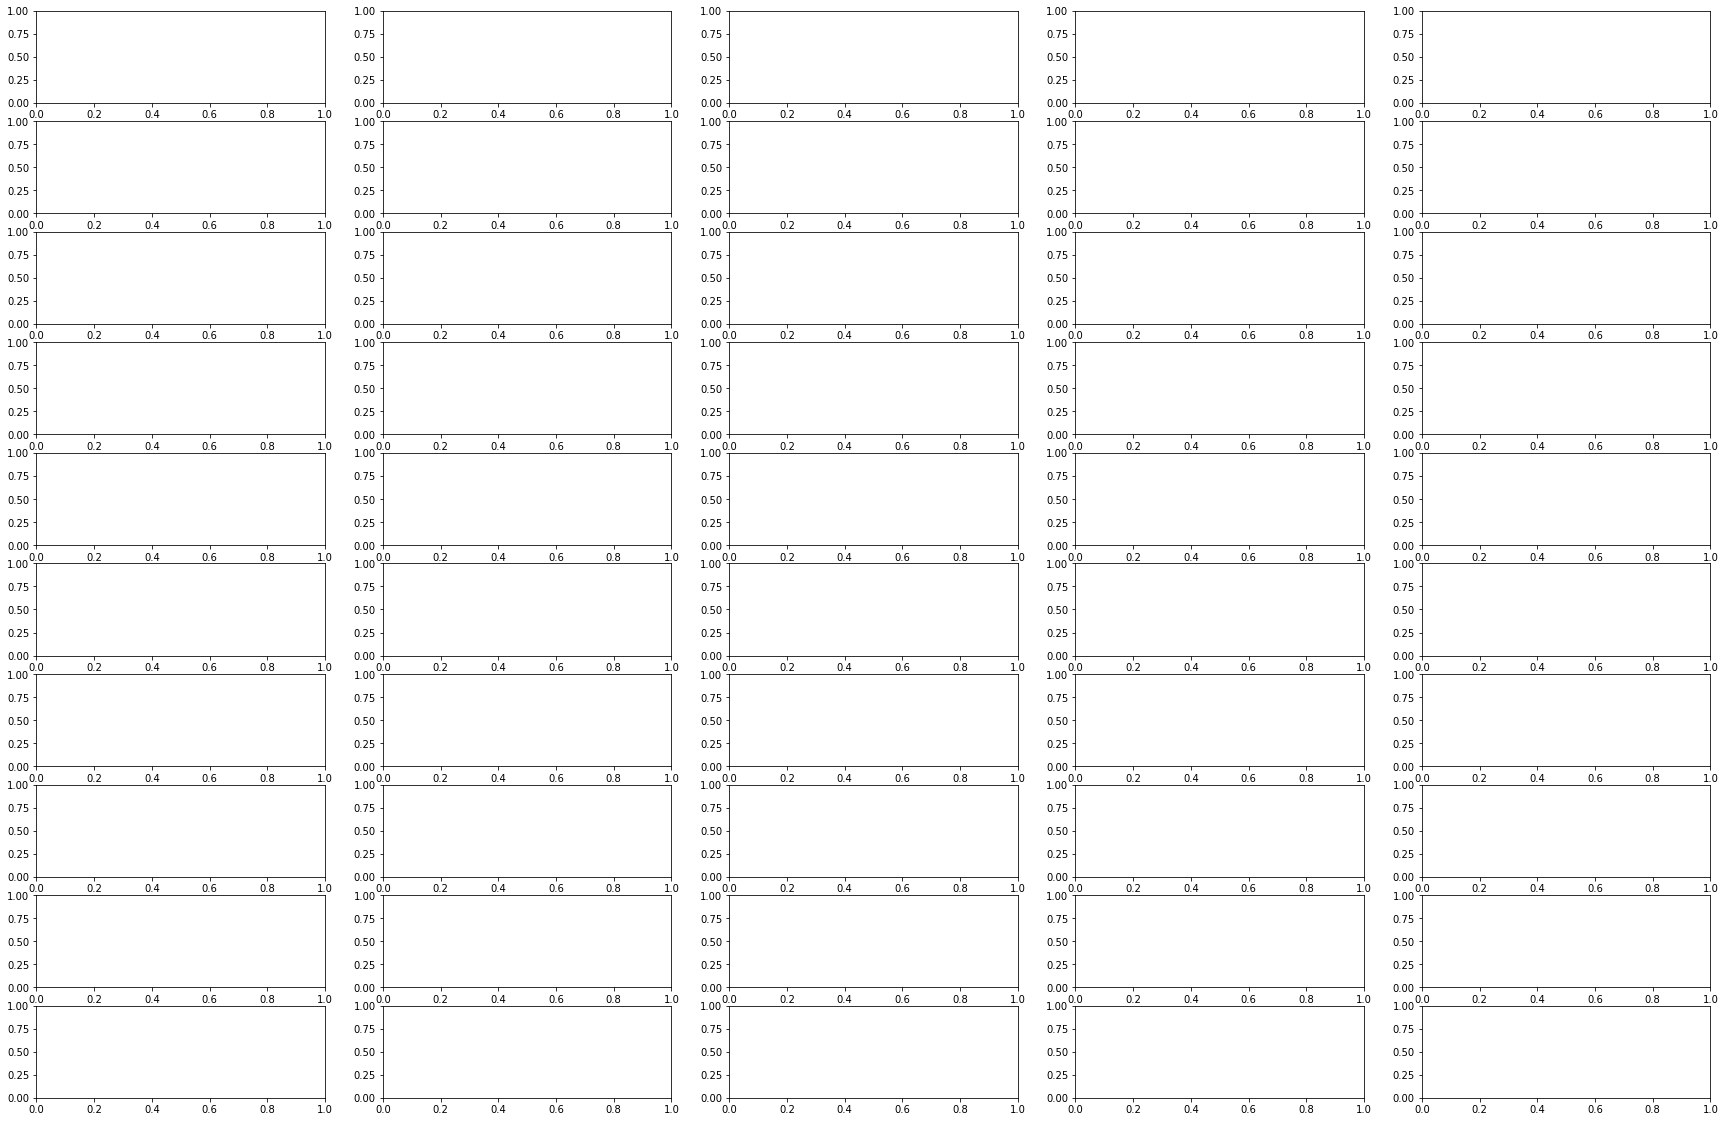

In [ ]:
plot_filters(W_conv, 5, figsize=(30,20))

In [ ]:
import keras.backend as K


def input_grad(model, x, layer_idx=-2):
    """Get the gradient of model output (before the final activation layer) w.r.t. model input
    
    Args:
      model: Sequence-based keras model
      x: one-hot-encoded DNA sequence
      layer_idx: output layer index
    """
    fn = K.function([model.input], K.gradients(model.layers[layer_idx].output, [model.input]))
    return fn([x])[0]


def plot_seq_importance(model, x, xlim=None, layer_idx=-2, figsize=(25, 3)):
    """Plot input x gradient sequence importance score
    
    Args:
      model: DNA-sequence based Sequential keras model
      x: one-hot encoded DNA sequence
      xlim: restrict the plotted xrange
      figsize: matplotlib figure size
    """
    seq_len = x.shape[1]
    if xlim is None:
        xlim = (0, seq_len)
    grads = input_grad(model, x, layer_idx=layer_idx)
    for i in range(len(x)):
        seqlogo_fig(grads[i]*x[i], figsize=figsize)
        plt.xticks(list(range(xlim[0], xlim[1], 5)))
        plt.xlim(xlim)

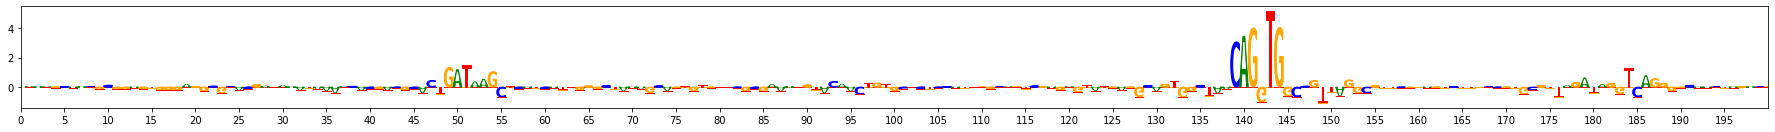

In [ ]:
# plot_seq_importance(model, X_test[:1], xlim=(250, 350), figsize=(25, 2))
plot_seq_importance(model1, X_test_premade[:1], figsize=(25, 2))

fake seq


In [ ]:
!zcat sequences.simdata.gz | head

seqName	sequence	embeddings	task1	task2	task3
empty_1732	AGCTCTTTTGGCGGACCGAGTTCGTCGGACTTTCGCTAAATTGACCATTAACAGGAGGATACCCGGGTGTCTCGGGAAGGTCGTAATACGGTAATTACGGATGTGAGAGCGCACACATCCTTTGGATGATACATGATCTCGCCGTATATGGCCTAGGTCAAAAGGACAGTCTCGCTAATCGCAATAATGCAGCTAACCGA		0	0	0
gata_only_1527	TGCAGATAAGAACTTTGGGAATATGGTAGGAAAAACCCCTGAAGTGAGATCCAAAAAATATAGACTGGCGCGGTGGCAATGCCCTTGTTAATGCTGGGAATCAAAAAATCGAAACTCTCAGCAGATAAGATATGCAGACCTGCTCGTGGAGACAAAAAGTATTGTTACTGCGTAAACCATTAGTACGTTGCCGAGTACCG	pos-120_GATA_disc1-GCAGATAAGA,pos-1_GATA_disc1-GCAGATAAGA	0	1	0
gata_tal1_62	AGATTATAGGCCCTCCACCAGATAAGATATAGCGTTCGAGGGTCAGAAGGTAGTTCTGAAGATCTCTTCATTGTGAAAGGCCTCATATGATGAGCTTCTCCATTCTCAGCTGACAGGCAAAACAATTGATCAGCGCTTAGGCGCCAGATGTTTACTCCCGTTAAGTCAACTTAGCTGTGTTCGTCAAATCCGCAACGCGG	pos-17_GATA_disc1-CCAGATAAGA,pos-139_TAL1_known1-GGCGCCAGATGTTTAC	1	1	1
empty_1289	TTTGGGCGCGGAAGAAGTCGCTCGCCTTTCTGTACTTGAAAATGATTACATGTAAGGATGTAACTCAATCGCAACATTGTCATTGGGTTCCATCGCCCTAGCGGTAGTAGGTTTTACCTCCAACTTGACAACCCTTCGTAAATATAAAATAGTAGTAA

In [56]:
!emptyBackground.py --seqLength 2000 --numSeqs 30000 #bg

In [10]:
!pip show simdna_dragonn

Name: simdna-dragonn
Version: 0.1
Summary: Simulations of DNA for the Dragonn Package
Home-page: UNKNOWN
Author: UNKNOWN
Author-email: UNKNOWN
License: UNKNOWN
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, matplotlib, scipy
Required-by: dragonn


In [26]:
!ls /usr/local/lib/python3.7/dist-packages/simdna

dinuc_shuffle.py   __init__.py	__pycache__  simulations.py  util.py
fileProcessing.py  pwm.py	resources    synthetic.py


In [ ]:
!motifGrammarSimulation.py --motifName1 SIX5_disc1 --motifName2 NFY_disc1 --seqLength 500 --numSeq 500 --generationSetting twoMotifsVariableSpacing --fixedSpacingOrMinSpacing 1 --maxSpacing 5

In [ ]:
# ! head /content/EmptyBackground_seqLength-500_numSeqs-200.simdata
! head /content/motifGrammarSimulation_twoMotifsVariableSpacing_motif1-TAL1_known1_motif2-NFY_disc1_seqLength200_numSeq10.simdata

seqName	sequence	embeddings
synthPos0	ATTACCGTAATCTACTATTAAGTCACAACCAAACAATGGATTACTTTCTGCGTTGGAATCAGTGCCGTGCCAATTGCTACGACAGTTGGTCCGTTTTGTGATTCACACGGGCAAAGTTTTATGAAATAAGCAAGAATCCCACCAATGAGTAAATATGGATTGAGCGCGAATTCTCTTCAATATTGATTTGCCAGCAAGAC	pos-77_TAL1_known1-TACGACAGTTGGTCCG,pos-98_GATA_disc2-TGATTCACAC,pos-77_TAL1_known1-TACGACAGTTGGTCCG-Gap5-GATA_disc2-TGATTCACAC
synthPos1	ATTAGAATAATCAAATATCTTAACAGAATAGCCATTTAAGTGGGAGCAAATCGGTCCCCTTCCGGGAAATAGACCAGATGTTCTGTTTGATTCACACTTTTTGACATGAATTGGTCCCAAGCGACAAATCCGAAGGGCGTACCACGTTAGAAGTATTCGTCTTGTTTGAAAGTAGTCGATATTGATTATTGTCTTCTCAC	pos-69_TAL1_known1-TAGACCAGATGTTCTG,pos-87_GATA_disc2-TGATTCACAC,pos-69_TAL1_known1-TAGACCAGATGTTCTG-Gap2-GATA_disc2-TGATTCACAC
synthPos2	TGCGCAAAGTTGTCTCTTCAGGCACCCTGTTTCTGGGCGGTTTTTGCATTGATCCAGTCCGAGTGCGGAATAATGCCTGCCCAGATGGCGAATTATTGATTCACTATTGAGAATCTATTCACCAAAGTAATTTGCTAGACCCAATCGATCGTTATTCCGTCTTATAAGACACTTAATAAAAAGTGTGCGTGAATGCGGGA	pos-76_TAL1_known1-CTGCCCAGATGGCGAA,pos-96_GATA_disc2-TGATTCACTA,pos-76_TAL1_known1

In [ ]:
!densityMotifSimulation.py  --motifNames GATA_disc1 SIX5_known1 TAL1_known1 --mean-motifs 1 --max-motifs 2 --min-motifs 1  --seqLength 800 --numSeqs 500 --rc-prob 0.5
#--mean-motifs 2

usage: densityMotifSimulation.py [-h] [--prefix PREFIX]
                                 [--pathToMotifs PATHTOMOTIFS] [--bestHit]
                                 --motifNames MOTIFNAMES [MOTIFNAMES ...]
                                 --max-motifs MAX_MOTIFS
                                 [--min-motifs MIN_MOTIFS] --mean-motifs
                                 MEAN_MOTIFS [--zero-prob ZERO_PROB]
                                 --seqLength SEQLENGTH --numSeqs NUMSEQS
                                 [--seed SEED]
densityMotifSimulation.py: error: unrecognized arguments: --rc-prob 0.5


In [ ]:
!head  /content/DensityEmbedding_motifs-GATA_disc1+SIX5_known1+TAL1_known1_min-1_max-2_mean-1_zeroProb-0_seqLength-800_numSeqs-500.simdata

seqName	sequence	embeddings
synth0	ATTACCGTAATCTACTATTAAGTCACAACCAAACAATGGATTACTTTCTGCGTTGGAATCAGTGCCGTGCCAATTGCAGTTGTAGTGCAGTATTTTTGGCATGAGCCCGGGCAAAGTTTTATGAAATAAGCAAGAATCCCACCAATGAGTAAATATGGATTGAGCGCGAATTCTCTTCAATATTGATTTGCCAGCAAGACCTTAACTTCAGTTCTGCTATAATATGTCCATGTTAGAAATTTCGTCGAAATGTCATTAGAATAATCAAATATCTTAACTGCATCAGGTGGTGCATGGGAGCAAATCGGTCCCCTTCCGGGAAAAGAAGATCTAGTATATTTCAGTATATACTTTTTGACATGAATTGGTCCCAAGCGACAAATCCGAAGGGCGTACCACGTTAGAAGTATTCCCTGGGGTATCAAATCGTCGATATTGATTATTGTCTTCTCACATTAGCAAATAACAGGTAAACAGATAAGGTTGCAATATGTTTAGGCGCGACCCCTGCGCAAAGTTGTCTCTTCAGGCACCCTGTTTCTGGGCGGTTTTTGCATTGATCCAGTCCGAGTGCGGGCGATAAGCTAGTTAGAGATTCATTTATGCCTTAGATCTTGAGAATCTATTCACCAAAGTAATTTGCTAGACCCAATCGATCGTTATTCCGTCTTATAAGACACTTAATAAAAAGTGTGCGTGAATGCGGGACCATCGTTTTATATTTAATCCTAGCACTTAGATAACTCATTTCCAGCCTTGAGCTTTTGTTAACGACGATGCACCTGGATCCATCTTTTTTT	pos-575_GATA_disc1-GGCGATAAGC,pos-473_GATA_disc1-ACAGATAAGG,pos-412_SIX5_known1-CCTGGGGTATCAAATCG,pos-278_TAL1_known1-TGCATCAGGTGGTGCA
synth1	CAAATGATAGTGCTCTCTTAAT

In [ ]:
#open simdata file
data = synthetic.read_simdata_file('/content/DensityEmbedding_motifs-GATA_disc1+SIX5_known1+TAL1_known1_min-1_max-2_mean-1_zeroProb-0_seqLength-800_numSeqs-500.simdata', ids_to_load=ids_to_load)

In [ ]:
import pandas as pd
pos = pd.read_csv("/content/DensityEmbedding_motifs-GATA_disc1+SIX5_known1+TAL1_known1_min-1_max-2_mean-1_zeroProb-0_seqLength-800_numSeqs-500.simdata", header = 0, sep = "\t")
neg = pd.read_csv("/content/EmptyBackground_seqLength-800_numSeqs-3000.simdata", header = 0, sep = "\t")


In [ ]:
pos.columns

Index(['seqName', 'sequence', 'embeddings'], dtype='object')

In [ ]:
ohd_pos = np.array([one_hot_encode_along_channel_axis(seq) for seq in pos.sequence])
ohd_neg = np.array([one_hot_encode_along_channel_axis(seq) for seq in neg.sequence])

# labels_premade = data.labels

In [ ]:
print(ohd_neg.shape)
print(ohd_pos.shape)
print(np.concatenate((ohd_pos, ohd_neg)).shape)
print(onehot_data_premade.shape)

(3000, 800, 4)
(500, 800, 4)
(3500, 800, 4)
(800, 200, 4)


In [ ]:
total = np.concatenate((ohd_pos, ohd_neg))
labels = np.expand_dims(np.array([1]*len(pos.sequence) + [0]*len(neg.sequence)), axis = 1)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(total, labels, test_size=0.33, random_state=42, stratify = labels)

In [ ]:
X_train_new.shape[1::]

(800, 4)

In [ ]:


model1 = Sequential()
model1.add(Conv1D(filters=50, kernel_size=(11), padding='valid', input_shape=X_train_new.shape[1::], 
                  kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
# model1.add(BatchNormalization())
model1.add(Activation('relu'))
# model1.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
model1.add(Conv1D(filters=50, kernel_size=(11), padding='valid',  
                  kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
model1.add(Activation('relu'))
model1.add(AveragePooling1D(pool_size=(780,), strides=(780,)))
model1.add(Flatten())
model1.add(Dense(50, kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg'))) #there are three classes therefore 3 possibilities
model1.add(Activation("relu"))
model1.add(Dropout(0.5))
model1.add(Dense(1, kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
model1.add(Activation("sigmoid"))

In [ ]:
model1.compile(optimizer='adam',
                               loss='binary_crossentropy',
                               metrics=[tf.keras.metrics.BinaryCrossentropy(),
                                        tf.keras.metrics.AUC(curve='ROC'),
                                        tf.keras.metrics.AUC(curve='PR')])

hist = model1.fit(x=X_train_new,
                                  y=y_train_new,
                                  batch_size=16,
                                  epochs=60, # 100
                # callbacks=[EarlyStopping(patience=7, monitor='val_loss'),   # If val_loss doesn't decrease after 3 epochs, stop training
                #                   History()],
                validation_split = 0.1)


model1.evaluate(X_test_new, y_test_new)

Train on 2110 samples, validate on 235 samples
Epoch 1/60
2110/2110 [==============================] - 13s 6ms/sample - loss: 0.4307 - binary_crossentropy: 0.4307 - auc_2: 0.4935 - auc_3: 0.1370 - val_loss: 0.4555 - val_binary_crossentropy: 0.4555 - val_auc_2: 0.5715 - val_auc_3: 0.1898
Epoch 2/60
2110/2110 [==============================] - 13s 6ms/sample - loss: 0.4212 - binary_crossentropy: 0.4212 - auc_2: 0.5149 - auc_3: 0.1445 - val_loss: 0.4591 - val_binary_crossentropy: 0.4591 - val_auc_2: 0.6066 - val_auc_3: 0.2052
Epoch 3/60
2110/2110 [==============================] - 13s 6ms/sample - loss: 0.4247 - binary_crossentropy: 0.4247 - auc_2: 0.4924 - auc_3: 0.1409 - val_loss: 0.4630 - val_binary_crossentropy: 0.4630 - val_auc_2: 0.6085 - val_auc_3: 0.2092
Epoch 4/60
2110/2110 [==============================] - 12s 6ms/sample - loss: 0.4158 - binary_crossentropy: 0.4158 - auc_2: 0.5391 - auc_3: 0.1591 - val_loss: 0.4674 - val_binary_crossentropy: 0.4674 - val_auc_2: 0.6049 - val_auc

[0.20160797609266262, 0.20160799, 0.94797677, 0.90930605]

In [ ]:
seqs_to_explain = X_train[[0,3,9]]
print(seqs_to_explain.shape)
print(np.expand_dims(np.sum(raw_shap_explanations,axis=-1)[:,:,None].squeeze(), -1).shape)

In [ ]:
np.where(y_test_new==1)
# onehot_tX_test_new[[2,5,6]]

(array([   2,    5,    6,   17,   25,   29,   42,   43,   45,   47,   58,
          66,   68,   90,  109,  121,  143,  150,  160,  162,  168,  176,
         183,  190,  192,  194,  206,  212,  216,  223,  234,  248,  250,
         253,  270,  274,  276,  286,  303,  310,  327,  328,  337,  346,
         349,  361,  368,  369,  381,  383,  400,  406,  412,  413,  429,
         431,  442,  444,  449,  451,  468,  482,  490,  491,  496,  497,
         500,  503,  505,  507,  515,  522,  524,  536,  540,  542,  545,
         550,  555,  559,  562,  563,  568,  569,  571,  573,  574,  593,
         601,  604,  609,  630,  640,  643,  658,  663,  675,  677,  680,
         684,  688,  698,  702,  717,  719,  728,  742,  743,  747,  748,
         754,  757,  776,  781,  782,  783,  795,  801,  804,  807,  808,
         809,  818,  825,  838,  839,  840,  842,  853,  860,  862,  866,
         887,  890,  891,  901,  908,  910,  935,  952,  954,  961,  964,
         966,  977,  983,  988,  994, 

In [ ]:
import shap
import matplotlib.pyplot as plt
#weird error with global maxpooling (https://github.com/slundberg/shap/issues/559)
from vizsequence import viz_sequence
seqs_to_explain = X_test_new[[2,    5,    6,   17,   25,   29,   42,   43]] #these three are positive for task 0
dinuc_shuff_explainer = shap.DeepExplainer((model1.input, model1.output[:,0]), shuffle_several_times)
raw_shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain, check_additivity=False)

#project the importance at each position onto the base that's actually present
dinuc_shuff_explanations = np.expand_dims(np.sum(raw_shap_explanations,axis=-1)[:,:,None].squeeze(), -1)*seqs_to_explain
# for dinuc_shuff_explanation in dinuc_shuff_explanations:
#     viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)

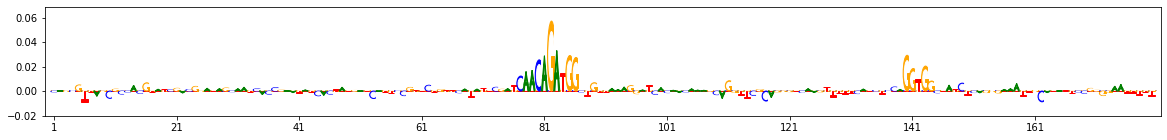

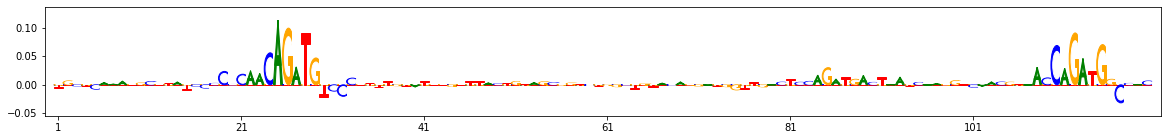

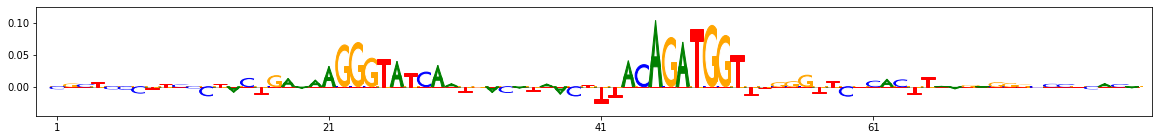

In [ ]:
viz_sequence.plot_weights(dinuc_shuff_explanations[0][160:340], subticks_frequency=20)
viz_sequence.plot_weights(dinuc_shuff_explanations[1][360:480], subticks_frequency=20)
viz_sequence.plot_weights(dinuc_shuff_explanations[2][320:400], subticks_frequency=20)

WITH RC


In [55]:
!python /content/densityMotifSimulationFINAL.py --motifNames GATA_disc1 SIX5_known1 TAL1_known1 --mean-motifs 2 --max-motifs 3 --min-motifs 1  --seqLength 2000 --numSeqs 16000 --rc-prob 0.5

In [57]:
import pandas as pd
pos = pd.read_csv("/content/DensityEmbedding_motifs-GATA_disc1+SIX5_known1+TAL1_known1_min-1_max-3_mean-2_zeroProb-0_seqLength-2000_numSeqs-16000.simdata", header = 0, sep = "\t")
neg = pd.read_csv("/content/EmptyBackground_seqLength-2000_numSeqs-30000.simdata", header = 0, sep = "\t")


In [58]:
ohd_pos = np.array([one_hot_encode_along_channel_axis(seq) for seq in pos.sequence])
ohd_neg = np.array([one_hot_encode_along_channel_axis(seq) for seq in neg.sequence])

# labels_premade = data.labels

In [59]:
total = np.concatenate((ohd_pos, ohd_neg))
labels = np.expand_dims(np.array([1]*len(pos.sequence) + [0]*len(neg.sequence)), axis = 1)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(total, labels, test_size=0.33, random_state=42, stratify = labels)

In [66]:
model1 = Sequential()
model1.add(Conv1D(filters=50, kernel_size=(11), padding='valid', input_shape=X_train_new.shape[1::], 
                  kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
# model1.add(BatchNormalization())
model1.add(Activation('relu'))
# model1.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
model1.add(Conv1D(filters=50, kernel_size=(11), padding='valid',  
                  kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
model1.add(Activation('relu'))
model1.add(AveragePooling1D(pool_size=(780,), strides=(780,)))
model1.add(Flatten())
model1.add(Dense(50, kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg'))) #there are three classes therefore 3 possibilities
model1.add(Activation("relu"))
model1.add(Dropout(0.5))
model1.add(Dense(1, kernel_initializer=initializers.VarianceScaling(distribution= 'uniform',
                                                                  mode= 'fan_avg')))
model1.add(Activation("sigmoid"))

In [67]:
model1.compile(optimizer='adam',
                               loss='binary_crossentropy',
                               metrics=[tf.keras.metrics.BinaryCrossentropy(),
                                        tf.keras.metrics.AUC(curve='ROC'),
                                        tf.keras.metrics.AUC(curve='PR')])

hist = model1.fit(x=X_train_new,
                                  y=y_train_new,
                                  batch_size=16,
                                  epochs=60, # 100
                # callbacks=[EarlyStopping(patience=7, monitor='val_loss'),   # If val_loss doesn't decrease after 3 epochs, stop training
                #                   History()],
                validation_split = 0.1)


model1.evaluate(X_test_new, y_test_new)

Train on 27738 samples, validate on 3082 samples
Epoch 1/60
27738/27738 [==============================] - 370s 13ms/sample - loss: 0.6502 - binary_crossentropy: 0.6502 - auc_2: 0.5055 - auc_3: 0.3511 - val_loss: 0.6483 - val_binary_crossentropy: 0.6483 - val_auc_2: 0.5035 - val_auc_3: 0.3468
Epoch 2/60
27738/27738 [==============================] - 370s 13ms/sample - loss: 0.6475 - binary_crossentropy: 0.6475 - auc_2: 0.5054 - auc_3: 0.3518 - val_loss: 0.6435 - val_binary_crossentropy: 0.6435 - val_auc_2: 0.6048 - val_auc_3: 0.4544
Epoch 3/60
27738/27738 [==============================] - 372s 13ms/sample - loss: 0.5347 - binary_crossentropy: 0.5347 - auc_2: 0.7925 - auc_3: 0.6971 - val_loss: 0.3187 - val_binary_crossentropy: 0.3187 - val_auc_2: 0.9673 - val_auc_3: 0.9486
Epoch 4/60
27738/27738 [==============================] - 371s 13ms/sample - loss: 0.2501 - binary_crossentropy: 0.2501 - auc_2: 0.9615 - auc_3: 0.9394 - val_loss: 0.1514 - val_binary_crossentropy: 0.1514 - val_auc_2

KeyboardInterrupt: ignored

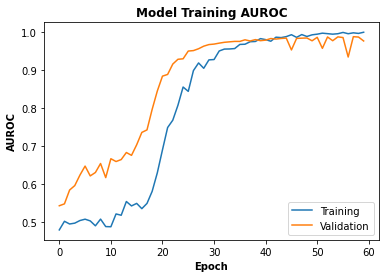

In [15]:
import matplotlib.pyplot as plt
plt.plot(hist.history['auc'])
plt.plot(hist.history['val_auc'])
plt.title('Model Training AUROC', weight = 'bold')
plt.ylabel('AUROC', weight = 'bold')
plt.xlabel('Epoch', weight = 'bold')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

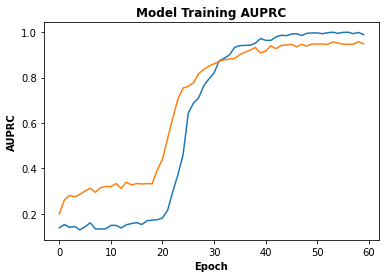

In [15]:
plt.plot(hist.history['auc_1'])
plt.plot(hist.history['val_auc_1'])
plt.title('Model Training AUPRC', weight = 'bold')
plt.ylabel('AUPRC', weight = 'bold')
plt.xlabel('Epoch', weight = 'bold')
# plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

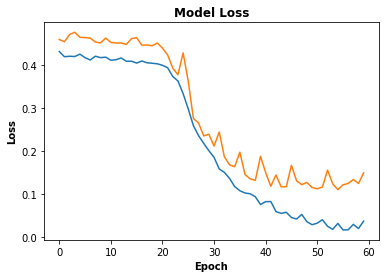

In [17]:

# mpl.rcParams['figure.dpi']= 100
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss', weight = 'bold')
plt.ylabel('Loss', weight = 'bold')
plt.xlabel('Epoch', weight = 'bold')
# plt.legend(['Training', 'Validation'], loc='lower left')
plt.show()

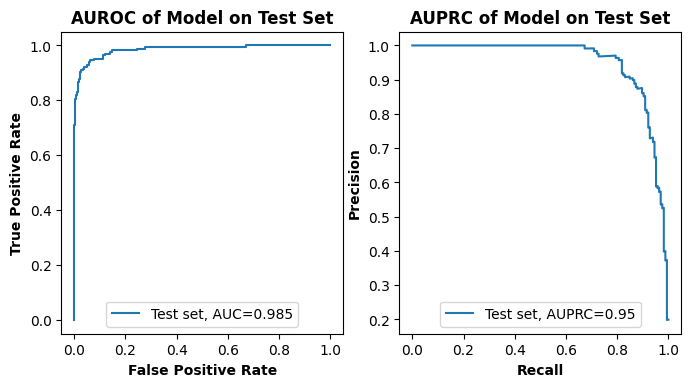

In [18]:
# X_test_new, y_test_new
#model1.predict(X_test_new)
# !pip install scikit-plot
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
mpl.rcParams['figure.figsize'] = [8, 4]
from sklearn.metrics import roc_curve, auc, plot_roc_curve, roc_auc_score, average_precision_score, precision_recall_curve
# skplt.metrics.plot_roc_curve(y_true, y_probas)
# skplt.metrics.plot_roc_curve(y_test_new, model1.predict(X_test_new))
auc = roc_auc_score(y_test_new, model1.predict(X_test_new))
auprc = average_precision_score(y_test_new, model1.predict(X_test_new))
fpr, tpr, _ = roc_curve(y_test_new, model1.predict(X_test_new))
precision, recall, _ = precision_recall_curve(y_test_new, model1.predict(X_test_new))
fig, axs = plt.subplots(1,2)
axs[0].plot(fpr,tpr,label="Test set, AUC="+str(round(auc, 3)))
axs[1].plot(recall, precision,label="Test set, AUPRC="+str(round(auprc, 3)))
# axs[0].title('Model Performance on Held-Out Test Data')
axs[0].set_title("AUROC of Model on Test Set", weight = 'bold')
axs[1].set_title("AUPRC of Model on Test Set", weight = 'bold')
axs[0].set_ylabel('True Positive Rate', weight = "bold")
axs[1].set_ylabel('Precision', weight = "bold")
axs[0].set_xlabel('False Positive Rate', weight = "bold")
axs[1].set_xlabel('Recall', weight = "bold")
axs[0].legend(loc="lower center")
axs[1].legend(loc="lower center")
# plt.legend(['AUROC', 'AUPRC'], loc='lower left')
plt.show()
# model1.predict(X_test_new).
# auc_keras = auc(fpr_keras, tpr_keras)
# auc_keras
# y_test_new.shape

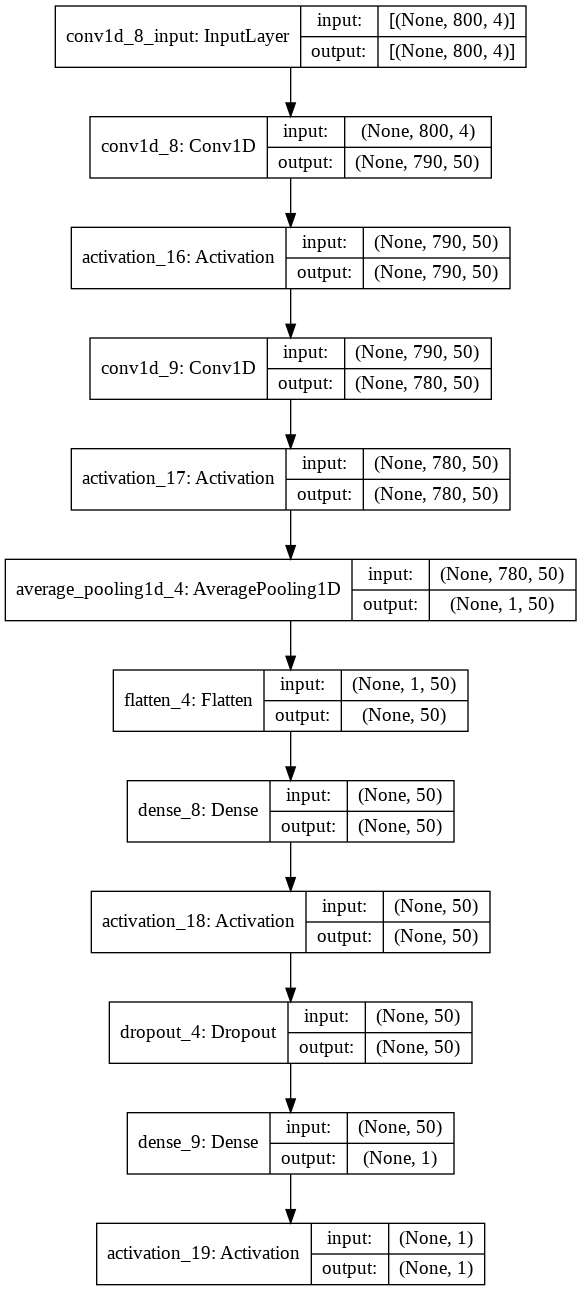

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
W_conv, b_conv = model1.layers[0].get_weights()

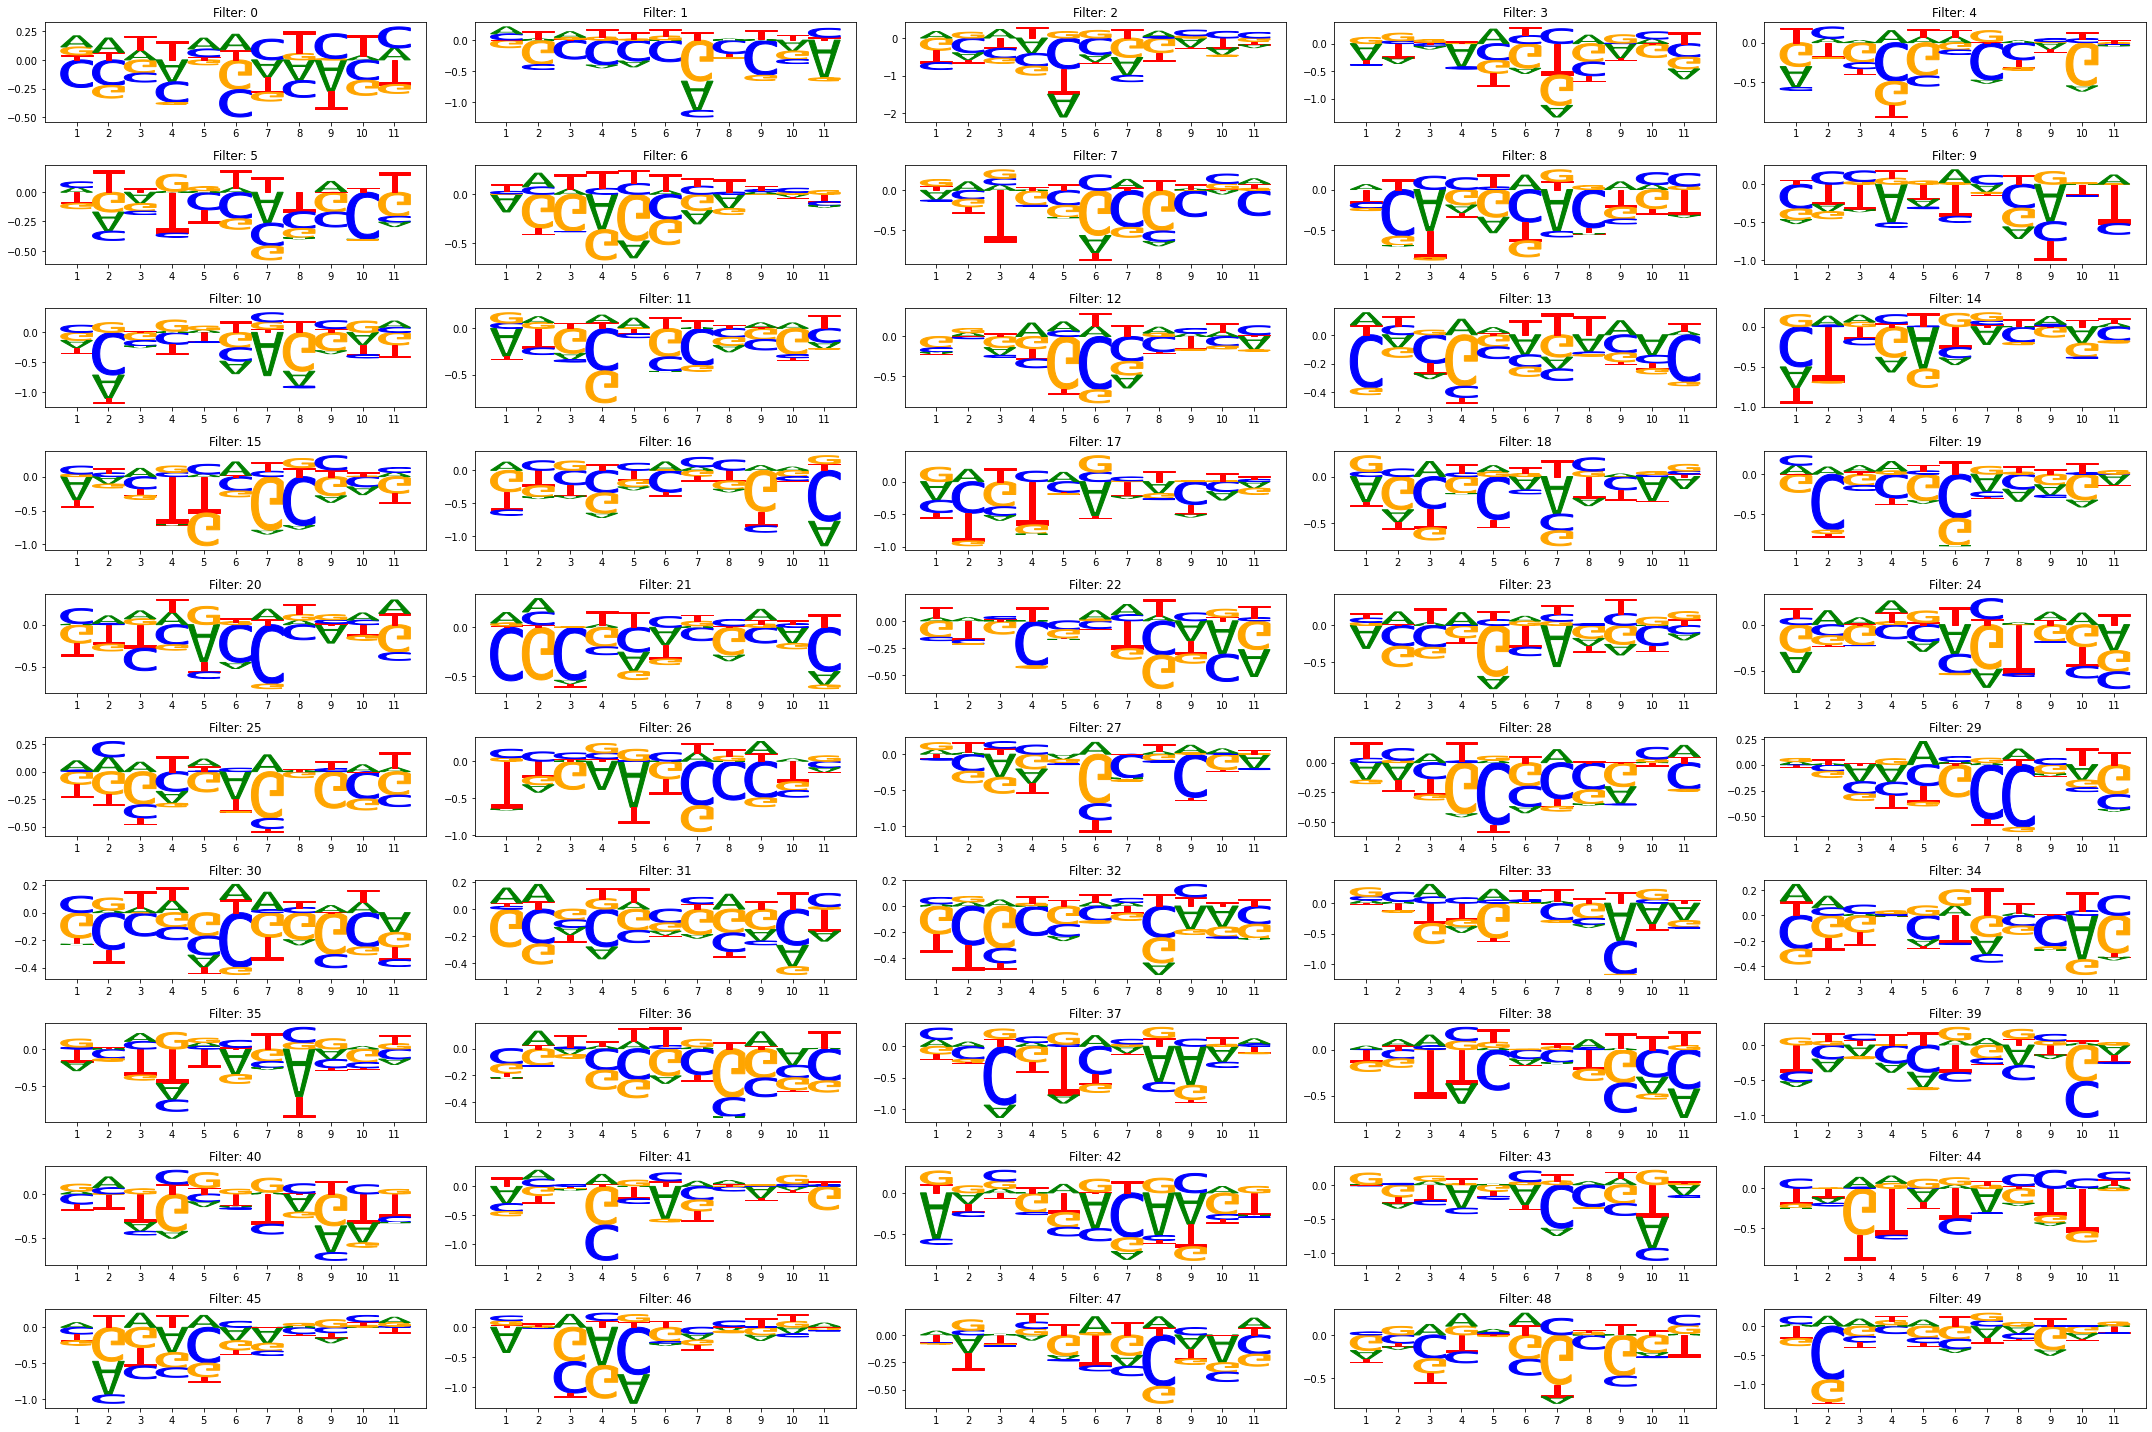

In [ ]:
plot_filters(W_conv, 5, figsize=(30,20))

In [ ]:
np.where(y_test_new==1)

(array([   2,    5,    6,   17,   25,   29,   42,   43,   45,   47,   58,
          66,   68,   90,  109,  121,  143,  150,  160,  162,  168,  176,
         183,  190,  192,  194,  206,  212,  216,  223,  234,  248,  250,
         253,  270,  274,  276,  286,  303,  310,  327,  328,  337,  346,
         349,  361,  368,  369,  381,  383,  400,  406,  412,  413,  429,
         431,  442,  444,  449,  451,  468,  482,  490,  491,  496,  497,
         500,  503,  505,  507,  515,  522,  524,  536,  540,  542,  545,
         550,  555,  559,  562,  563,  568,  569,  571,  573,  574,  593,
         601,  604,  609,  630,  640,  643,  658,  663,  675,  677,  680,
         684,  688,  698,  702,  717,  719,  728,  742,  743,  747,  748,
         754,  757,  776,  781,  782,  783,  795,  801,  804,  807,  808,
         809,  818,  825,  838,  839,  840,  842,  853,  860,  862,  866,
         887,  890,  891,  901,  908,  910,  935,  952,  954,  961,  964,
         966,  977,  983,  988,  994, 

In [40]:
random_bg = lambda s: X_test_new[np.random.choice(np.where(y_test_new== 0)[0], 10, replace=False)]

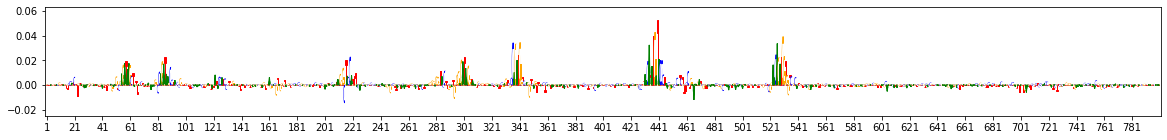

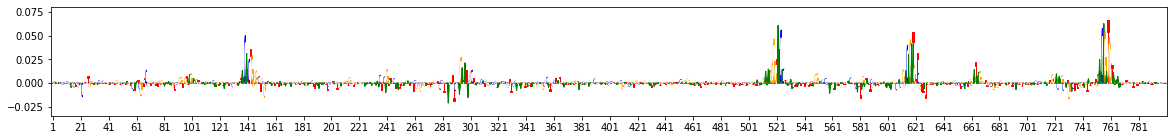

In [41]:
import shap
import matplotlib.pyplot as plt
#weird error with global maxpooling (https://github.com/slundberg/shap/issues/559)
from vizsequence import viz_sequence
seqs_to_explain = X_test_new[[2,    5,   ]] #these three are positive for task 0
dinuc_shuff_explainer = shap.DeepExplainer((model1.input, model1.output[:,0]), random_bg)
raw_shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain, check_additivity=False)

#project the importance at each position onto the base that's actually present
dinuc_shuff_explanations = np.expand_dims(np.sum(raw_shap_explanations,axis=-1)[:,:,None].squeeze(), -1)*seqs_to_explain
for dinuc_shuff_explanation in dinuc_shuff_explanations:
    viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)

In [54]:
pos.labels = 1
pos['labels'] = 1
neg['labels'] = 0
alls = pd.concat([pos, neg])
print(alls)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(alls['sequence'], alls['labels'], test_size=0.33, random_state=42, stratify = alls['labels'])

        seqName  ... labels
0        synth0  ...      1
1        synth1  ...      1
2        synth2  ...      1
3        synth3  ...      1
4        synth4  ...      1
...         ...  ...    ...
2995  synth2995  ...      0
2996  synth2996  ...      0
2997  synth2997  ...      0
2998  synth2998  ...      0
2999  synth2999  ...      0

[3500 rows x 4 columns]


sequence 4:1


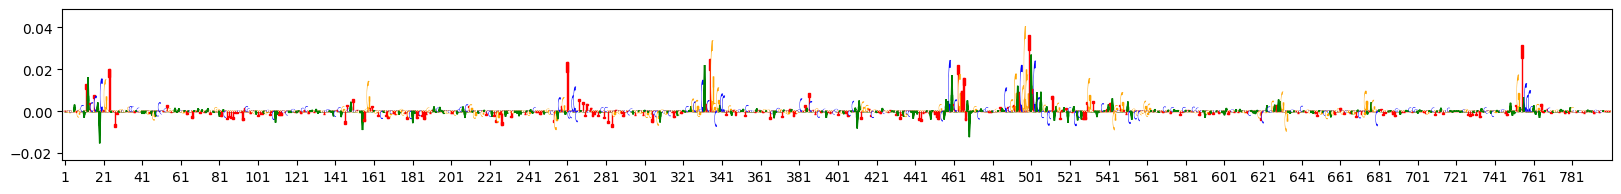

sequence 4:2


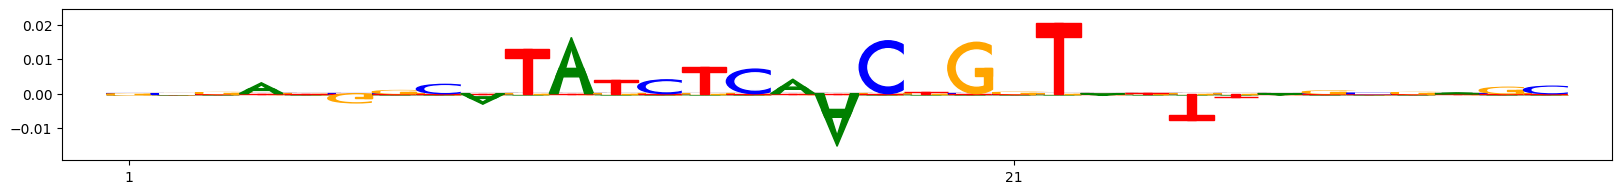

sequence 4:3


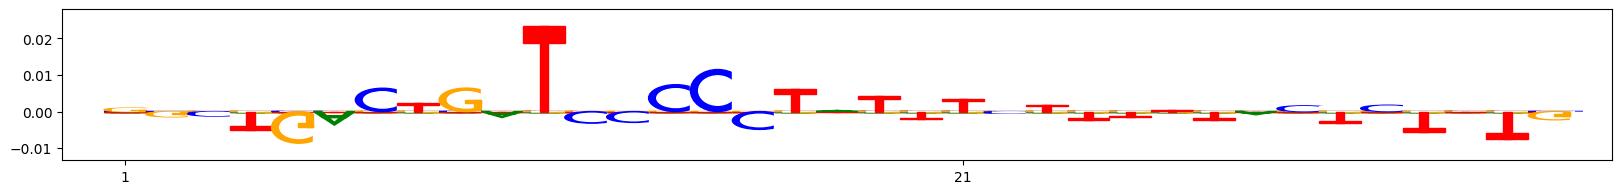

sequence 4:4


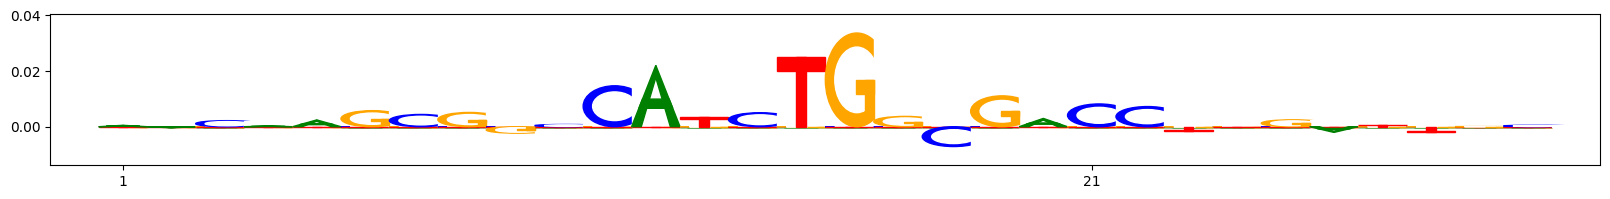

sequence 4:5


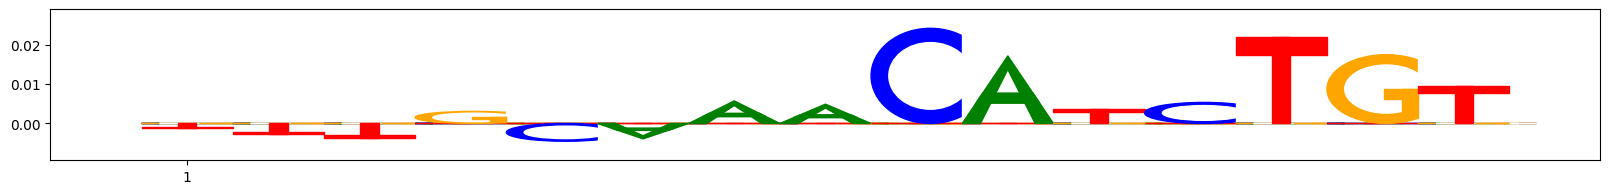

sequence 4:6


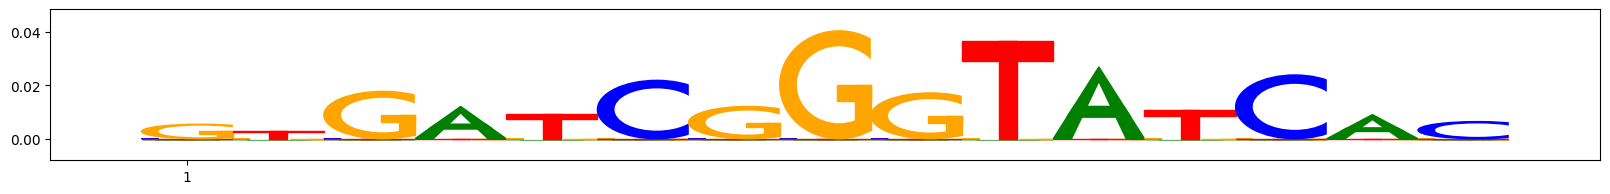

sequence 4:6


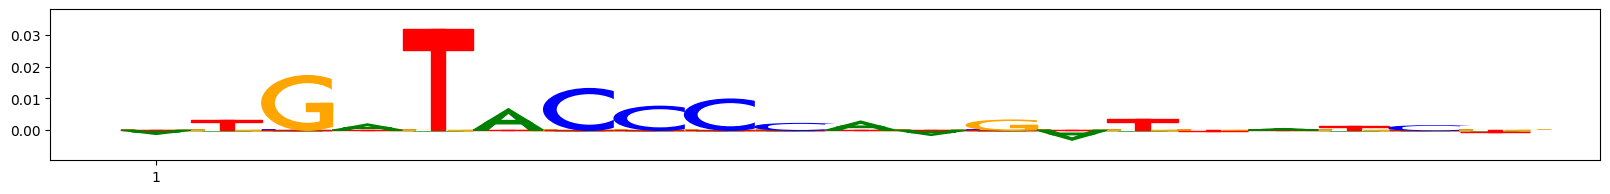

In [84]:
# print("sequence 0:1")
# viz_sequence.plot_weights(dinuc_shuff_explanations[0], subticks_frequency=20)
# print("sequence 0:2")
# viz_sequence.plot_weights(dinuc_shuff_explanations[0][30:150], subticks_frequency=20)
# print("sequence 0:3")
# viz_sequence.plot_weights(dinuc_shuff_explanations[0][630:720], subticks_frequency=20)

# print("sequence 1:1")
# viz_sequence.plot_weights(dinuc_shuff_explanations[1], subticks_frequency=20)
# print("sequence 1:2")
# viz_sequence.plot_weights(dinuc_shuff_explanations[1][200:240], subticks_frequency=20)
# print("sequence 1:3")
# viz_sequence.plot_weights(dinuc_shuff_explanations[1][320:380], subticks_frequency=20)
# print("sequence 1:4")
# viz_sequence.plot_weights(dinuc_shuff_explanations[1][600:800], subticks_frequency=20)

# print("sequence 2:1")
# viz_sequence.plot_weights(dinuc_shuff_explanations[2], subticks_frequency=20)
# print("sequence 2:2")
# viz_sequence.plot_weights(dinuc_shuff_explanations[2][61:170], subticks_frequency=20)
# print("sequence 2:3")
# viz_sequence.plot_weights(dinuc_shuff_explanations[2][240:340], subticks_frequency=20)
# print("sequence 2:4")
# viz_sequence.plot_weights(dinuc_shuff_explanations[2][420:470], subticks_frequency=20)
# print("sequence 2:5")
# viz_sequence.plot_weights(dinuc_shuff_explanations[2][320:350], subticks_frequency=20)
print("sequence 4:1")
viz_sequence.plot_weights(dinuc_shuff_explanations[4], subticks_frequency=20)
print("sequence 4:2")
viz_sequence.plot_weights(dinuc_shuff_explanations[4][2:35], subticks_frequency=20)
print("sequence 4:3")
viz_sequence.plot_weights(dinuc_shuff_explanations[4][250:285], subticks_frequency=20)
print("sequence 4:4")
viz_sequence.plot_weights(dinuc_shuff_explanations[4][320:350], subticks_frequency=20)
print("sequence 4:5")
viz_sequence.plot_weights(dinuc_shuff_explanations[4][450:465], subticks_frequency=20)
print("sequence 4:6")
viz_sequence.plot_weights(dinuc_shuff_explanations[4][490:505], subticks_frequency=20)
print("sequence 4:6")
viz_sequence.plot_weights(dinuc_shuff_explanations[4][750:770], subticks_frequency=20)

# viz_sequence.plot_weights(dinuc_shuff_explanations[4], subticks_frequency=20)
# viz_sequence.plot_weights(dinuc_shuff_explanations[5], subticks_frequency=20)
# viz_sequence.plot_weights(dinuc_shuff_explanations[6], subticks_frequency=20)
# viz_sequence.plot_weights(dinuc_shuff_explanations[7], subticks_frequency=20)

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
#!cp /content/EmptyBackground_seqLength-800_numSeqs-3000.simdata "drive/My Drive/"

In [ ]:
#!cp /content/DensityEmbedding_motifs-GATA_disc1+SIX5_known1+TAL1_known1_min-1_max-3_mean-2_zeroProb-0_seqLength-800_numSeqs-500.simdata "drive/My Drive/"


In [ ]:
#!cp /content/densityMotifSimulationFINAL.py "drive/My Drive/"

In [16]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import numpy as np
from skimage.util import view_as_windows
import warnings, logging
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import nn_grad, math_grad
from collections import OrderedDict
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# Some of the following functions for batch processing have been borrowed and adapter from Keras
# https://github.com/keras-team/keras/blob/master/keras/utils/generic_utils.py
# https://github.com/keras-team/keras/blob/master/keras/engine/training_utils.py


def make_batches(size, batch_size):
    """Returns a list of batch indices (tuples of indices).
    # Arguments
        size: Integer, total size of the data to slice into batches.
        batch_size: Integer, batch size.
    # Returns
        A list of tuples of array indices.
    """
    num_batches = (size + batch_size - 1) // batch_size  # round up
    return [(i * batch_size, min(size, (i + 1) * batch_size))
            for i in range(num_batches)]


def to_list(x, allow_tuple=False):
    """Normalizes a list/tensor into a list.
    If a tensor is passed, we return
    a list of size 1 containing the tensor.
    # Arguments
        x: target object to be normalized.
        allow_tuple: If False and x is a tuple,
            it will be converted into a list
            with a single element (the tuple).
            Else converts the tuple to a list.
    # Returns
        A list.
    """
    if isinstance(x, list):
        return x
    if allow_tuple and isinstance(x, tuple):
        return list(x)
    return [x]


def unpack_singleton(x):
    """Gets the equivalent np-array if the iterable has only one value.
    Otherwise return the iterable.
    # Argument
        x: A list or tuple.
    # Returns
        The same iterable or the iterable converted to a np-array.
    """
    if len(x) == 1:
        return np.array(x)
    return x


def slice_arrays(arrays, start=None, stop=None):
    """Slices an array or list of arrays.
    """
    if arrays is None:
        return [None]
    elif isinstance(arrays, list):
        return [None if x is None else x[start:stop] for x in arrays]
    else:
        return arrays[start:stop]


def placeholder_from_data(numpy_array):
    if numpy_array is None:
        return None
    return tf.compat.v1.placeholder('float', [None,] + list(numpy_array.shape[1:]))

SUPPORTED_ACTIVATIONS = [
    'Relu', 'Elu', 'Sigmoid', 'Tanh', 'Softplus'
]

UNSUPPORTED_ACTIVATIONS = [
    'CRelu', 'Relu6', 'Softsign'
]

_ENABLED_METHOD_CLASS = None
_GRAD_OVERRIDE_CHECKFLAG = 0


# -----------------------------------------------------------------------------
# UTILITY FUNCTIONS
# -----------------------------------------------------------------------------


def activation(type):
    """
    Returns Tensorflow's activation op, given its type
    :param type: string
    :return: op
    """
    if type not in SUPPORTED_ACTIVATIONS:
        warnings.warn('Activation function (%s) not supported' % type)
    f = getattr(tf.nn, type.lower())
    return f


def original_grad(op, grad):
    """
    Return original Tensorflow gradient for an op
    :param op: op
    :param grad: Tensor
    :return: Tensor
    """
    if op.type not in SUPPORTED_ACTIVATIONS:
        warnings.warn('Activation function (%s) not supported' % op.type)
    opname = '_%sGrad' % op.type
    if hasattr(nn_grad, opname):
        f = getattr(nn_grad, opname)
    else:
        f = getattr(math_grad, opname)
    return f(op, grad)


# -----------------------------------------------------------------------------
# ATTRIBUTION METHODS BASE CLASSES
# -----------------------------------------------------------------------------


class AttributionMethod(object):
    """
    Attribution method base class
    """
    def __init__(self, T, X, session, keras_learning_phase=None):
        self.T = T  # target Tensor
        self.X = X  # input Tensor
        self.Y_shape = [None,] + T.get_shape().as_list()[1:]
        # Most often T contains multiple output units. In this case, it is often necessary to select
        # a single unit to compute contributions for. This can be achieved passing 'ys' as weight for the output Tensor.
        self.Y = tf.compat.v1.placeholder(tf.float32, self.Y_shape)
        # placeholder_from_data(ys) if ys is not None else 1.0  # Tensor that represents weights for T
        self.T = self.T * self.Y
        self.symbolic_attribution = None
        self.session = session
        self.keras_learning_phase = keras_learning_phase
        self.has_multiple_inputs = type(self.X) is list or type(self.X) is tuple
        logging.info('Model with multiple inputs: %s' % self.has_multiple_inputs)

        # Set baseline
        # TODO: now this sets a baseline also for those methods that does not require it
        self._set_check_baseline()

        # References
        self._init_references()

        # Create symbolic explanation once during construction (affects only gradient-based methods)
        self.explain_symbolic()

    def explain_symbolic(self):
        return None

    def run(self, xs, ys=None, batch_size=None):
        pass

    def _init_references(self):
        pass

    def _check_input_compatibility(self, xs, ys=None, batch_size=None):
        if ys is not None:
            if not self.has_multiple_inputs and len(xs) != len(ys):
                raise RuntimeError('When provided, ys must have the same batch size as xs (xs has batch size {} and ys {})'.format(len(xs), len(ys)))
            elif self.has_multiple_inputs and np.all([len(i) != len(ys) for i in xs]):
                raise RuntimeError('When provided, ys must have the same batch size as all elements of xs')
        if batch_size is not None and batch_size > 0:
            if self.T.shape[0].value is not None and self.T.shape[0].value is not batch_size:
                raise RuntimeError('When using batch evaluation, the first dimension of the target tensor '
                                   'must be compatible with the batch size. Found %s instead' % self.T.shape[0].value)
            if isinstance(self.X, list):
                for x in self.X:
                    if x.shape[0].value is not None and x.shape[0].value is not batch_size:
                        raise RuntimeError('When using batch evaluation, the first dimension of the input tensor '
                                           'must be compatible with the batch size. Found %s instead' % x.shape[
                                               0].value)
            else:
                if self.X.shape[0].value is not None and self.X.shape[0].value is not batch_size:
                    raise RuntimeError('When using batch evaluation, the first dimension of the input tensor '
                                       'must be compatible with the batch size. Found %s instead' % self.X.shape[0].value)

    def _session_run_batch(self, T, xs, ys=None):
        feed_dict = {}
        if self.has_multiple_inputs:
            for k, v in zip(self.X, xs):
                feed_dict[k] = v
        else:
            feed_dict[self.X] = xs

        # If ys is not passed, produce a vector of ones that will be broadcasted to all batch samples
        feed_dict[self.Y] = ys if ys is not None else np.ones([1,] + self.Y_shape[1:])

        if self.keras_learning_phase is not None:
            feed_dict[self.keras_learning_phase] = 0
        return self.session.run(T, feed_dict)

    def _session_run(self, T, xs, ys=None, batch_size=None):
        num_samples = len(xs)
        if self.has_multiple_inputs is True:
            num_samples = len(xs[0])
            if len(xs) != len(self.X):
                raise RuntimeError('List of input tensors and input data have different lengths (%s and %s)'
                                   % (str(len(xs)), str(len(self.X))))
            if batch_size is not None:
                for xi in xs:
                    if len(xi) != num_samples:
                        raise RuntimeError('Evaluation in batches requires all inputs to have '
                                           'the same number of samples')

        if batch_size is None or batch_size <= 0 or num_samples <= batch_size:
            return self._session_run_batch(T, xs, ys)
        else:
            outs = []
            batches = make_batches(num_samples, batch_size)
            for batch_index, (batch_start, batch_end) in enumerate(batches):
                # Get a batch from data
                xs_batch = slice_arrays(xs, batch_start, batch_end)
                # If the target tensor has one entry for each sample, we need to batch it as well
                ys_batch = None
                if ys is not None:
                    ys_batch = slice_arrays(ys, batch_start, batch_end)
                batch_outs = self._session_run_batch(T, xs_batch, ys_batch)
                batch_outs = to_list(batch_outs)
                if batch_index == 0:
                    # Pre-allocate the results arrays.
                    for batch_out in batch_outs:
                        shape = (num_samples,) + batch_out.shape[1:]
                        outs.append(np.zeros(shape, dtype=batch_out.dtype))
                for i, batch_out in enumerate(batch_outs):
                    outs[i][batch_start:batch_end] = batch_out
            return unpack_singleton(outs)

    def _set_check_baseline(self):
        # Do nothing for those methods that have no baseline required
        if not hasattr(self, "baseline"):
            return

        if self.baseline is None:
            if self.has_multiple_inputs:
                self.baseline = [np.zeros([1,] + xi.get_shape().as_list()[1:]) for xi in self.X]
            else:
                self.baseline = np.zeros([1,] + self.X.get_shape().as_list()[1:])

        else:
            if self.has_multiple_inputs:
                for i, xi in enumerate(self.X):
                    if list(self.baseline[i].shape) == xi.get_shape().as_list()[1:]:
                        self.baseline[i] = np.expand_dims(self.baseline[i], 0)
                    else:
                        raise RuntimeError('Baseline shape %s does not match expected shape %s'
                                           % (self.baseline[i].shape, self.X.get_shape().as_list()[1:]))
            else:
                if list(self.baseline.shape) == self.X.get_shape().as_list()[1:]:
                    self.baseline = np.expand_dims(self.baseline, 0)
                else:
                    raise RuntimeError('Baseline shape %s does not match expected shape %s'
                                       % (self.baseline.shape, self.X.get_shape().as_list()[1:]))


class GradientBasedMethod(AttributionMethod):
    """
    Base class for gradient-based attribution methods
    """
    def get_symbolic_attribution(self):
        return tf.gradients(self.T, self.X)

    def explain_symbolic(self):
        if self.symbolic_attribution is None:
            self.symbolic_attribution = self.get_symbolic_attribution()
        return self.symbolic_attribution

    def run(self, xs, ys=None, batch_size=None):
        self._check_input_compatibility(xs, ys, batch_size)
        results = self._session_run(self.explain_symbolic(), xs, ys, batch_size)
        return results[0] if not self.has_multiple_inputs else results

    @classmethod
    def nonlinearity_grad_override(cls, op, grad):
        return original_grad(op, grad)


class PerturbationBasedMethod(AttributionMethod):
    """
       Base class for perturbation-based attribution methods
       """
    def __init__(self, T, X, session, keras_learning_phase):
        super(PerturbationBasedMethod, self).__init__(T, X, session, keras_learning_phase)
        self.base_activation = None



# -----------------------------------------------------------------------------
# ATTRIBUTION METHODS
# -----------------------------------------------------------------------------
"""
Returns zero attributions. For testing only.
"""


class DummyZero(GradientBasedMethod):

    def get_symbolic_attribution(self,):
        return tf.gradients(self.T, self.X)

    @classmethod
    def nonlinearity_grad_override(cls, op, grad):
        input = op.inputs[0]
        return tf.zeros_like(input)

"""
Saliency maps
https://arxiv.org/abs/1312.6034
"""


class Saliency(GradientBasedMethod):

    def get_symbolic_attribution(self):
        return [tf.abs(g) for g in tf.gradients(self.T, self.X)]


"""
Gradient * Input
https://arxiv.org/pdf/1704.02685.pdf - https://arxiv.org/abs/1611.07270
"""


class GradientXInput(GradientBasedMethod):

    def get_symbolic_attribution(self):
        return [g * x for g, x in zip(
            tf.gradients(self.T, self.X),
            self.X if self.has_multiple_inputs else [self.X])]


"""
Integrated Gradients
https://arxiv.org/pdf/1703.01365.pdf
"""


class IntegratedGradients(GradientBasedMethod):

    def __init__(self, T, X, session, keras_learning_phase, steps=100, baseline=None):
        self.steps = steps
        self.baseline = baseline
        super(IntegratedGradients, self).__init__(T, X, session, keras_learning_phase)

    def run(self, xs, ys=None, batch_size=None):
        self._check_input_compatibility(xs, ys, batch_size)

        gradient = None
        for alpha in list(np.linspace(1. / self.steps, 1.0, self.steps)):
            xs_mod = [b + (x - b) * alpha for x, b in zip(xs, self.baseline)] if self.has_multiple_inputs \
                else self.baseline + (xs - self.baseline) * alpha
            _attr = self._session_run(self.explain_symbolic(), xs_mod, ys, batch_size)
            if gradient is None: gradient = _attr
            else: gradient = [g + a for g, a in zip(gradient, _attr)]

        results = [g * (x - b) / self.steps for g, x, b in zip(
            gradient,
            xs if self.has_multiple_inputs else [xs],
            self.baseline if self.has_multiple_inputs else [self.baseline])]

        return results[0] if not self.has_multiple_inputs else results


"""
Layer-wise Relevance Propagation with epsilon rule
http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140
"""


class EpsilonLRP(GradientBasedMethod):
    eps = None

    def __init__(self, T, X, session, keras_learning_phase, epsilon=1e-4):
        assert epsilon > 0.0, 'LRP epsilon must be greater than zero'
        global eps
        eps = epsilon
        super(EpsilonLRP, self).__init__(T, X, session, keras_learning_phase)

    def get_symbolic_attribution(self):
        return [g * x for g, x in zip(
            tf.gradients(self.T, self.X),
            self.X if self.has_multiple_inputs else [self.X])]

    @classmethod
    def nonlinearity_grad_override(cls, op, grad):
        output = op.outputs[0]
        input = op.inputs[0]
        return grad * output / (input + eps *
                                tf.where(input >= 0, tf.ones_like(input), -1 * tf.ones_like(input)))

"""
DeepLIFT
This reformulation only considers the "Rescale" rule
https://arxiv.org/abs/1704.02685
"""


class DeepLIFTRescale(GradientBasedMethod):

    _deeplift_ref = {}

    def __init__(self, T, X, session, keras_learning_phase, baseline=None):
        self.baseline = baseline
        super(DeepLIFTRescale, self).__init__(T, X, session, keras_learning_phase)

    def get_symbolic_attribution(self):
        return [g * (x - b) for g, x, b in zip(
            tf.gradients(self.T, self.X),
            self.X if self.has_multiple_inputs else [self.X],
            self.baseline if self.has_multiple_inputs else [self.baseline])]

    @classmethod
    def nonlinearity_grad_override(cls, op, grad):
        output = op.outputs[0]
        input = op.inputs[0]
        ref_input = cls._deeplift_ref[op.name]
        ref_output = activation(op.type)(ref_input)
        delta_out = output - ref_output
        delta_in = input - ref_input
        instant_grad = activation(op.type)(0.5 * (ref_input + input))
        return tf.where(tf.abs(delta_in) > 1e-5, grad * delta_out / delta_in,
                        original_grad(instant_grad.op, grad))

    def _init_references(self):
        # print ('DeepLIFT: computing references...')
        sys.stdout.flush()
        self._deeplift_ref.clear()
        ops = []
        g = tf.compat.v1.get_default_graph()
        for op in g.get_operations():
            if len(op.inputs) > 0 and not op.name.startswith('gradients'):
                if op.type in SUPPORTED_ACTIVATIONS:
                    ops.append(op)
        YR = self._session_run([o.inputs[0] for o in ops], self.baseline)
        for (r, op) in zip(YR, ops):
            self._deeplift_ref[op.name] = r
        # print('DeepLIFT: references ready')
        sys.stdout.flush()


"""
Occlusion method
Generalization of the grey-box method presented in https://arxiv.org/pdf/1311.2901.pdf
This method performs a systematic perturbation of contiguous hyperpatches in the input,
replacing each patch with a user-defined value (by default 0).

window_shape : integer or tuple of length xs_ndim
Defines the shape of the elementary n-dimensional orthotope the rolling window view.
If an integer is given, the shape will be a hypercube of sidelength given by its value.

step : integer or tuple of length xs_ndim
Indicates step size at which extraction shall be performed.
If integer is given, then the step is uniform in all dimensions.
"""


class Occlusion(PerturbationBasedMethod):

    def __init__(self, T, X, session, keras_learning_phase, window_shape=None, step=None):
        super(Occlusion, self).__init__(T, X, session, keras_learning_phase)
        if self.has_multiple_inputs:
            raise RuntimeError('Multiple inputs not yet supported for perturbation methods')

        input_shape = X[0].get_shape().as_list()
        if window_shape is not None:
            assert len(window_shape) == len(input_shape), \
                'window_shape must have length of input (%d)' % len(input_shape)
            self.window_shape = tuple(window_shape)
        else:
            self.window_shape = (1,) * len(input_shape)

        if step is not None:
            assert isinstance(step, int) or len(step) == len(input_shape), \
                'step must be integer or tuple with the length of input (%d)' % len(input_shape)
            self.step = step
        else:
            self.step = 1
        self.replace_value = 0.0
        logging.info('Input shape: %s; window_shape %s; step %s' % (input_shape, self.window_shape, self.step))

    def run(self, xs, ys=None, batch_size=None):
        self._check_input_compatibility(xs, ys, batch_size)
        input_shape = xs.shape[1:]
        batch_size = xs.shape[0]
        total_dim = np.asscalar(np.prod(input_shape))

        # Create mask
        index_matrix = np.arange(total_dim).reshape(input_shape)
        idx_patches = view_as_windows(index_matrix, self.window_shape, self.step).reshape((-1,) + self.window_shape)
        heatmap = np.zeros_like(xs, dtype=np.float32).reshape((-1), total_dim)
        w = np.zeros_like(heatmap)

        # Compute original output
        eval0 = self._session_run(self.T, xs, ys, batch_size)

        # Start perturbation loop
        for i, p in enumerate(idx_patches):
            mask = np.ones(input_shape).flatten()
            mask[p.flatten()] = self.replace_value
            masked_xs = mask.reshape((1,) + input_shape) * xs
            delta = eval0 - self._session_run(self.T, masked_xs, ys, batch_size)
            delta_aggregated = np.sum(delta.reshape((batch_size, -1)), -1, keepdims=True)
            heatmap[:, p.flatten()] += delta_aggregated
            w[:, p.flatten()] += p.size

        attribution = np.reshape(heatmap / w, xs.shape)
        if np.isnan(attribution).any():
            warnings.warn('Attributions generated by Occlusion method contain nans, '
                          'probably because window_shape and step do not allow to cover the all input.')
        return attribution


"""
Shapley Value sampling
Computes approximate Shapley Values using "Polynomial calculation of the Shapley value based on sampling",
Castro et al, 2009 (https://www.sciencedirect.com/science/article/pii/S0305054808000804)

samples : integer (default 5)
Defined the number of samples for each input feature. 
Notice that evaluating a model samples * n_input_feature times might take a while.

sampling_dims : list of dimension indexes to run sampling on (feature dimensions).
By default, all dimensions except the batch dimension will be sampled.
For example, with a 4-D tensor that contains color images, single color channels are sampled.
To sample pixels, instead, use sampling_dims=[1,2]
"""


class ShapleySampling(PerturbationBasedMethod):

    def __init__(self, T, X, session, keras_learning_phase, samples=5, sampling_dims=None):
        super(ShapleySampling, self).__init__(T, X, session, keras_learning_phase)
        if self.has_multiple_inputs:
            raise RuntimeError('Multiple inputs not yet supported for perturbation methods')
        dims = len(X.shape)
        if sampling_dims is not None:
            if not 0 < len(sampling_dims) <= (dims - 1):
                raise RuntimeError('sampling_dims must be a list containing 1 to %d elements' % (dims-1))
            if 0 in sampling_dims:
                raise RuntimeError('Cannot sample batch dimension: remove 0 from sampling_dims')
            if any([x < 1 or x > dims-1 for x in sampling_dims]):
                raise RuntimeError('Invalid value in sampling_dims')
        else:
            sampling_dims = list(range(1, dims))

        self.samples = samples
        self.sampling_dims = sampling_dims

    def run(self, xs, ys=None, batch_size=None):
        xs_shape = list(xs.shape)
        batch_size = xs.shape[0]
        n_features = int(np.asscalar(np.prod([xs.shape[i] for i in self.sampling_dims])))
        result = np.zeros((xs_shape[0], n_features))

        run_shape = list(xs_shape)  # a copy
        run_shape = np.delete(run_shape, self.sampling_dims).tolist()
        run_shape.insert(1, -1)

        reconstruction_shape = [xs_shape[0]]
        for j in self.sampling_dims:
            reconstruction_shape.append(xs_shape[j])

        for r in range(self.samples):
            p = np.random.permutation(n_features)
            x = xs.copy().reshape(run_shape)
            y = None
            for i in p:
                if y is None:
                    y = self._session_run(self.T, x.reshape(xs_shape), ys, batch_size)
                x[:, i] = 0
                y0 = self._session_run(self.T, x.reshape(xs_shape), ys, batch_size)
                delta = y - y0
                delta_aggregated = np.sum(delta.reshape((batch_size, -1)), -1, keepdims=False)
                result[:, i] += delta_aggregated
                y = y0

        shapley = result / self.samples
        return shapley.reshape(reconstruction_shape)


# -----------------------------------------------------------------------------
# END ATTRIBUTION METHODS
# -----------------------------------------------------------------------------


attribution_methods = OrderedDict({
    'zero': (DummyZero, 0),
    'saliency': (Saliency, 1),
    'grad*input': (GradientXInput, 2),
    'intgrad': (IntegratedGradients, 3),
    'elrp': (EpsilonLRP, 4),
    'deeplift': (DeepLIFTRescale, 5),
    'occlusion': (Occlusion, 6),
    'shapley_sampling': (ShapleySampling, 7)
})



@ops.RegisterGradient("DeepExplainGrad")
def deepexplain_grad(op, grad):
    global _ENABLED_METHOD_CLASS, _GRAD_OVERRIDE_CHECKFLAG
    _GRAD_OVERRIDE_CHECKFLAG = 1
    if _ENABLED_METHOD_CLASS is not None \
            and issubclass(_ENABLED_METHOD_CLASS, GradientBasedMethod):
        return _ENABLED_METHOD_CLASS.nonlinearity_grad_override(op, grad)
    else:
        return original_grad(op, grad)


class DeepExplain(object):

    def __init__(self, graph=None, session=tf.compat.v1.get_default_session()):
        self.method = None
        self.batch_size = None
        self.session = session
        self.graph = session.graph if graph is None else graph
        self.graph_context = self.graph.as_default()
        self.override_context = self.graph.gradient_override_map(self.get_override_map())
        self.keras_phase_placeholder = None
        self.context_on = False
        if self.session is None:
            raise RuntimeError('DeepExplain: could not retrieve a session. Use DeepExplain(session=your_session).')

    def __enter__(self):
        # Override gradient of all ops created in context
        self.graph_context.__enter__()
        self.override_context.__enter__()
        self.context_on = True
        return self

    def __exit__(self, type, value, traceback):
        self.graph_context.__exit__(type, value, traceback)
        self.override_context.__exit__(type, value, traceback)
        self.context_on = False

    def get_explainer(self, method, T, X, **kwargs):
        if not self.context_on:
            raise RuntimeError('Explain can be called only within a DeepExplain context.')
        global _ENABLED_METHOD_CLASS, _GRAD_OVERRIDE_CHECKFLAG
        self.method = method
        if self.method in attribution_methods:
            method_class, method_flag = attribution_methods[self.method]
        else:
            raise RuntimeError('Method must be in %s' % list(attribution_methods.keys()))
        if isinstance(X, list):
            for x in X:
                if 'tensor' not in str(type(x)).lower():
                    raise RuntimeError('If a list, X must contain only Tensorflow Tensor objects')
        else:
            if 'tensor' not in str(type(X)).lower():
                raise RuntimeError('X must be a Tensorflow Tensor object or a list of them')

        if 'tensor' not in str(type(T)).lower():
            raise RuntimeError('T must be a Tensorflow Tensor object')

        logging.info('DeepExplain: running "%s" explanation method (%d)' % (self.method, method_flag))
        self._check_ops()
        _GRAD_OVERRIDE_CHECKFLAG = 0

        _ENABLED_METHOD_CLASS = method_class
        method = _ENABLED_METHOD_CLASS(T, X,
                                       self.session,
                                       keras_learning_phase=self.keras_phase_placeholder,
                                       **kwargs)

        if issubclass(_ENABLED_METHOD_CLASS, GradientBasedMethod) and _GRAD_OVERRIDE_CHECKFLAG == 0:
            warnings.warn('DeepExplain detected you are trying to use an attribution method that requires '
                          'gradient override but the original gradient was used instead. You might have forgot to '
                          '(re)create your graph within the DeepExlain context. Results are not reliable!')
        _ENABLED_METHOD_CLASS = None
        _GRAD_OVERRIDE_CHECKFLAG = 0
        self.keras_phase_placeholder = None
        return method

    def explain(self, method, T, X, xs, ys=None, batch_size=None, **kwargs):
        explainer = self.get_explainer(method, T, X, **kwargs)
        return explainer.run(xs, ys, batch_size)

    @staticmethod
    def get_override_map():
        return dict((a, 'DeepExplainGrad') for a in SUPPORTED_ACTIVATIONS)

    def _check_ops(self):
        """
        Heuristically check if any op is in the list of unsupported activation functions.
        This does not cover all cases where explanation methods would fail, and must be improved in the future.
        Also, check if the placeholder named 'keras_learning_phase' exists in the graph. This is used by Keras
         and needs to be passed in feed_dict.
        :return:
        """
        g = tf.compat.v1.get_default_graph()
        for op in g.get_operations():
            if len(op.inputs) > 0 and not op.name.startswith('gradients'):
                if op.type in UNSUPPORTED_ACTIVATIONS:
                    warnings.warn('Detected unsupported activation (%s). '
                                  'This might lead to unexpected or wrong results.' % op.type)
            elif 'keras_learning_phase' in op.name:
                self.keras_phase_placeholder = op.outputs[0]

In [21]:
from tensorflow.keras import Model
import tensorflow.compat.v1.keras.backend as K
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model1.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model1.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = ohd_pos[0:10]
    ys = y_test_new[0:10]
    
    attributions_gradin = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)

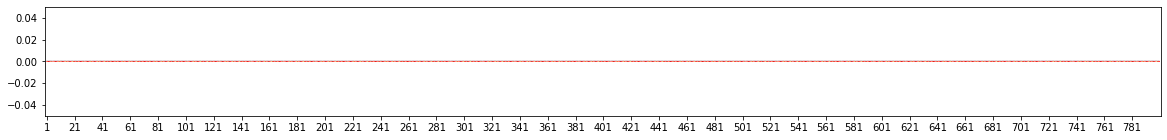

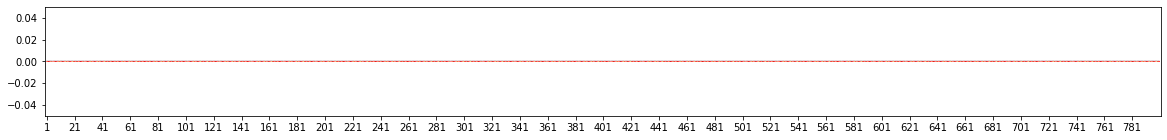

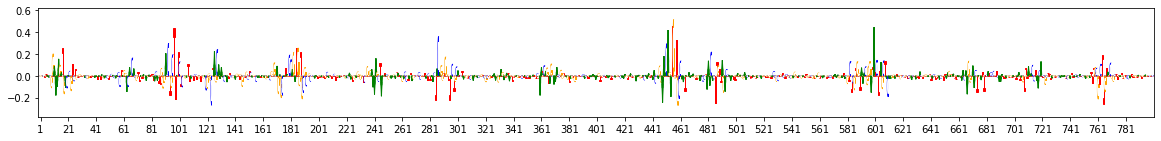

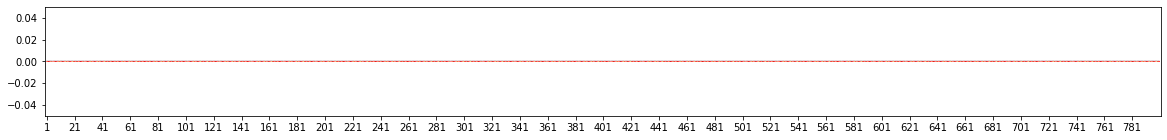

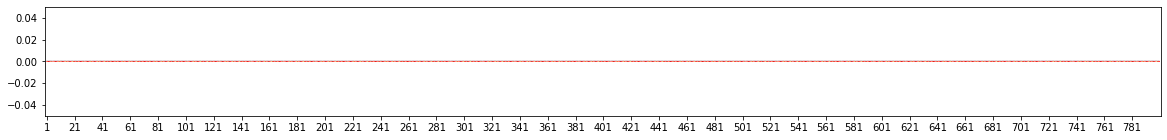

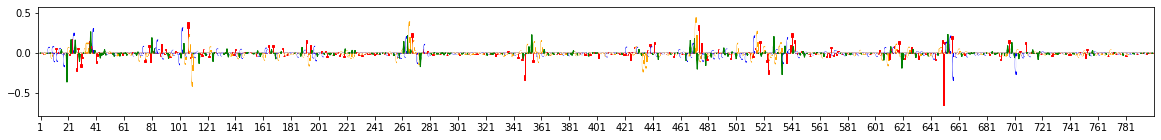

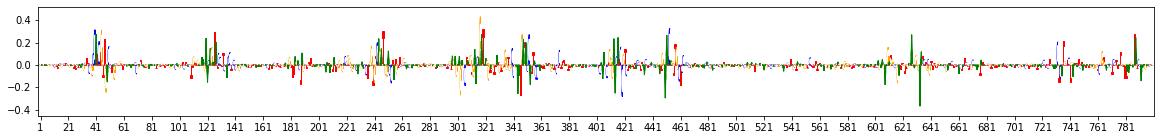

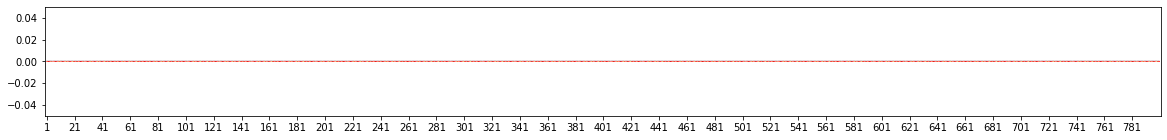

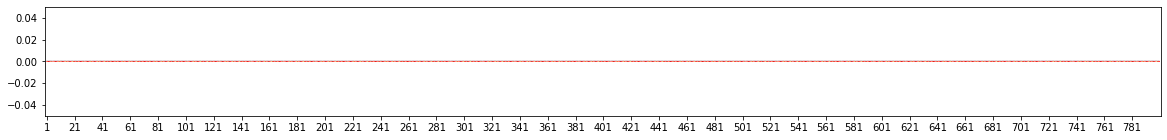

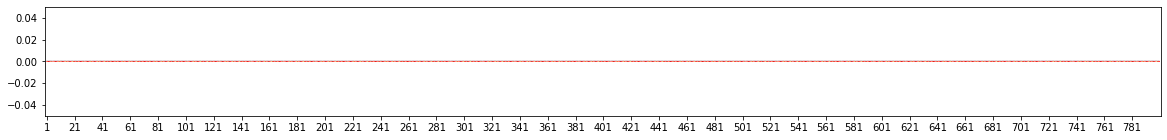

In [23]:
for dinuc_shuff_explanation in attributions_gradin:
    viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)

In [ ]:
#deepexplain og


In [32]:
#CONVOLUTIONAL
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
# from .core import *
# from .helper_functions import conv1d_transpose_via_conv2d
# from . import helper_functions as hf
import tensorflow as tf

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import sys
import os
import numpy as np
from collections import namedtuple
from collections import OrderedDict
from collections import defaultdict
import deeplift.util  
# from .helper_functions import (
#  pseudocount_near_zero, add_val_to_col)
# from . import helper_functions as hf
import tensorflow as tf

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
# from .core import *
# from .helper_functions import conv1d_transpose_via_conv2d
# from .convolutional import PaddingMode, DataFormat
# from . import helper_functions as hf
# import tensorflow as tf
from tensorflow.python.ops import nn_grad

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import sys
import os
import numpy as np
import yaml
from collections import namedtuple
from collections import OrderedDict
from collections import defaultdict
import deeplift.util
from deeplift import layers
from deeplift.layers import *
from deeplift.layers import ScoringMode
from deeplift.util import compile_func


ScoringMode = deeplift.util.enum(OneAndZeros="OneAndZeros",
                                 SoftmaxPreActivation="SoftmaxPreActivation")
NonlinearMxtsMode = deeplift.util.enum(
                     Gradient="Gradient",
                     Rescale="Rescale",
                     DeconvNet="DeconvNet",
                     GuidedBackprop="GuidedBackprop",
                     GuidedBackpropRescale="GuidedBackpropRescale",
                     RevealCancel="RevealCancel",
                     PassThrough="PassThrough",
                     DeepLIFT_GenomicsDefault="DeepLIFT_GenomicsDefault")
DenseMxtsMode = deeplift.util.enum(
                 Linear="Linear")
ConvMxtsMode = deeplift.util.enum(
                Linear="Linear")
ActivationNames = deeplift.util.enum(sigmoid="sigmoid",
                                     hard_sigmoid="hard_sigmoid",
                                     tanh="tanh",
                                     relu="relu",
                                     linear="linear")
MaxPoolDeepLiftMode = deeplift.util.enum(gradient = 'gradient')


class Layer(object):
    """
        Layer can be an input to the network or a node (layer) in the network
    """
    
    YamlKeys = deeplift.util.enum(blob_class="blob_class",
                                  blob_kwargs="blob_kwargs")

    def __init__(self, name=None, verbose=True):
        self.name = name
        self._built_fwd_pass_vars = False
        self._output_layers = []
        self._mxts_updated = False
        self._mxts_for_inputs_updated = False
        self.verbose=verbose

    def reset_built_fwd_pass_vars(self):
        self._built_fwd_pass_vars = False
        self._output_layers = []
        self._reset_built_fwd_pass_vars_for_inputs()

    def _reset_built_fwd_pass_vars_for_inputs(self):
        raise NotImplementedError()

    def _initialize_mxts(self):
        self._pos_mxts = tf.zeros_like(self.get_activation_vars(),
            name="pos_mxts_"+str(self.get_name()))
        self._neg_mxts = tf.zeros_like(self.get_activation_vars(),
            name="neg_mxts_"+str(self.get_name()))

    def reset_mxts_updated(self):
        for output_layer in self._output_layers:
            # only update layer if needed
            # if output_layer was already called by another layer:
            #     output_layer._mxts_updated == False
            # otherwise we call it
            if output_layer._mxts_updated:                                                                                         
                 output_layer.reset_mxts_updated()  
         
        self._initialize_mxts()
        self._mxts_updated = False
        self._mxts_for_inputs_updated = False

    def get_shape(self):
        return self._shape

    def get_output_layers(self):
        return self._output_layers

    def _layer_needs_to_be_built_message(self):
        raise RuntimeError("Layer needs to be built; name "+str(self.name))

    def get_name(self):
        return self.name

    def get_inputs(self):
        """
            return an object representing the input Layers
        """
        return self.inputs

    def get_activation_vars(self):
        """
            return the symbolic variables representing the activation
        """
        if (hasattr(self,'_activation_vars')==False):
            self._layer_needs_to_be_built_message()
        return self._activation_vars

    def get_pos_and_neg_contribs(self):
        """
            returns symbolic variables representing the pos and neg
            contribs, which sub up to the diff from reference
        """
        if (hasattr(self,'_pos_contribs')==False):
            self._layer_needs_to_be_built_message()
        return self._pos_contribs, self._neg_contribs

    def _build_reference_vars(self):
        raise NotImplementedError()

    def _build_diff_from_reference_vars(self):
        """
            instantiate theano vars whose value is the difference between
                the activation and the reference activation
        """
        return self.get_activation_vars() - self.get_reference_vars()

    def _build_pos_and_neg_contribs(self):
        raise NotImplementedError()

    def _build_target_contrib_vars(self):
        """
            the contrib to the target is mxts*(Ax - Ax0)
        """ 
        pos_contribs, neg_contribs = self.get_pos_and_neg_contribs()
        return (self.get_pos_mxts()*pos_contribs
                + self.get_neg_mxts()*neg_contribs)

    def _get_diff_from_reference_vars(self):
        """
            return the theano vars representing the difference between
                the activation and the reference activation
        """
        return self._diff_from_reference_vars

    def get_reference_vars(self):
        """
            get the activation that corresponds to zero contrib
        """
        if (hasattr(self, '_reference_vars')==False):
            raise RuntimeError("_reference_vars is unset")
        return self._reference_vars

    def _increment_mxts(self, pos_mxts_increments, neg_mxts_increments):
        """
            increment the multipliers
        """
        self._pos_mxts += pos_mxts_increments
        self._neg_mxts += neg_mxts_increments

    def get_pos_mxts(self):
        """
            return the computed mxts
        """
        return self._pos_mxts

    def get_neg_mxts(self):
        """
            return the computed mxts
        """
        return self._neg_mxts

    def get_target_contrib_vars(self):
        return self._target_contrib_vars

    def build_fwd_pass_vars(self, output_layer=None):
        if (output_layer is not None):
            self._output_layers.append(output_layer)
        if (self._built_fwd_pass_vars == False):
            self._build_fwd_pass_vars()
            self._built_fwd_pass_vars = True
 
    def _build_fwd_pass_vars(self):
        raise NotImplementedError()

    def update_mxts(self):
        if (self._mxts_updated == False):
            for output_layer in self._output_layers:
                output_layer.update_mxts()
                output_layer._update_mxts_for_inputs()
            self._set_mxts_updated_true()

    def _set_mxts_updated_true(self):
        self._mxts_updated = True 
        self._target_contrib_vars = self._build_target_contrib_vars()


class Input(Layer):
    """
        Input layer
    """

    def __init__(self, batch_shape, **kwargs):
        super(Input, self).__init__(**kwargs)
        self._num_dims = len(batch_shape)
        self._shape = batch_shape
        self._activation_vars = tf.compat.v1.placeholder(
                                 dtype=tf.float32, shape=batch_shape,
                                 name="inp_"+str(self.get_name()))

    def get_activation_vars(self):
        return self._activation_vars
    
    def _build_reference_vars(self):
        return tf.compat.v1.placeholder(dtype=tf.float32,
                shape=self._shape, name="ref_"+str(self.get_name()))

    def get_mxts(self):
        #only one of get_pos_mxts and get_neg_mxts will be nonzero,
        #for the input layer
        return 0.5*(self.get_pos_mxts() + self.get_neg_mxts())

    def _build_pos_and_neg_contribs(self):
        pos_contribs = (self._diff_from_reference_vars*
                        hf.gt_mask(self._diff_from_reference_vars,0.0))
        neg_contribs = (self._diff_from_reference_vars*
                        hf.lt_mask(self._diff_from_reference_vars,0.0))
        return pos_contribs, neg_contribs

    def _build_fwd_pass_vars(self):
        self._reference_vars = self._build_reference_vars()
        self._diff_from_reference_vars = self._build_diff_from_reference_vars()
        self._pos_contribs, self._neg_contribs =\
            self._build_pos_and_neg_contribs()
        self._initialize_mxts()

    def _reset_built_fwd_pass_vars_for_inputs(self):
        pass


class Node(Layer):

    def __init__(self, **kwargs):
        super(Node, self).__init__(**kwargs)

    def __call__(self, *args, **kwargs):
        self.set_inputs(*args, **kwargs) 

    def set_inputs(self, inputs):
        """
            set an object representing the input Layers
            return 'self' for syntactic convenience
        """
        self.inputs = inputs
        self._check_inputs()
        return self

    def _check_inputs(self):
        """
           check that inputs look right (eg: expecting a list, make
            sure that it is a list, etc) 
        """
        raise NotImplementedError() 

    def _get_input_activation_vars(self):
        """
            return an object containing the activation vars of the inputs 
        """
        return self._call_function_on_blobs_within_inputs(
                      'get_activation_vars') 

    def _get_input_pos_and_neg_contribs(self):
        return self._call_function_on_blobs_within_inputs(
                      'get_pos_and_neg_contribs')

    def _get_input_reference_vars(self):
        return self._call_function_on_blobs_within_inputs(
                    'get_reference_vars')

    def _get_input_diff_from_reference_vars(self):
        return self._call_function_on_blobs_within_inputs(
                    '_get_diff_from_reference_vars')

    def _get_input_shape(self):
        return self._call_function_on_blobs_within_inputs('get_shape')

    def _build_fwd_pass_vars_for_all_inputs(self):
        raise NotImplementedError() 

    def _call_function_on_blobs_within_inputs(self, function_name):
        """
            call function_name on every blob contained within
                get_inputs() and return it
        """ 
        raise NotImplementedError();

    def _build_fwd_pass_vars_core(self):
        self._build_fwd_pass_vars_for_all_inputs()
        self._shape = self._compute_shape(self._get_input_shape())

    def _build_fwd_pass_vars(self):
        """
           It is important that all the outputs of the Node have been
            built before the node is built, otherwise the value of
            mxts will not be correct 
        """
        self._build_fwd_pass_vars_core()
        self._activation_vars =\
            self._build_activation_vars(
                self._get_input_activation_vars())
        self._reference_vars =\
         self._build_reference_vars()
        self._diff_from_reference_vars =\
         self._build_diff_from_reference_vars()
        self._pos_contribs, self._neg_contribs =\
            self._build_pos_and_neg_contribs()
        self._initialize_mxts()

    def _compute_shape(self, input_shape):
        """
            compute the shape of this layer given the shape of the inputs
        """
        raise NotImplementedError()

    def _build_activation_vars(self, input_act_vars):
        """
            create the activation_vars symbolic variables given the
             input activation vars, organised the same way self.inputs is
        """
        raise NotImplementedError()

    def _build_pos_and_neg_contribs(self):
        """
            create the activation_vars symbolic variables given the
             input activation vars, organised the same way self.inputs is
        """
        raise NotImplementedError()

    def _build_reference_vars(self):
        if (hasattr(self, 'learned_reference')): 
            return self.learned_reference
        else:
            return self._build_activation_vars(
                    self._get_input_reference_vars())

    def _update_mxts_for_inputs(self):
        """
            call _increment_mxts() on the inputs to update them appropriately
        """
        if (self._mxts_for_inputs_updated == False):
            (pos_mxts_increments,
             neg_mxts_increments) = self._get_mxts_increments_for_inputs()
            self._add_given_increments_to_input_mxts(
                pos_mxts_increments, neg_mxts_increments)
            self._mxts_for_inputs_updated = True

    def _get_mxts_increments_for_inputs(self):
        """
            get what the increments should be for each input
        """
        raise NotImplementedError()

    def _add_given_increments_to_input_mxts(self,
        pos_mxts_increments, neg_mxts_increments):
        """
            given the increments for each input, add
        """
        raise NotImplementedError()
    

class SingleInputMixin(object):
    """
        Mixin for blobs that just have one Layer as their input;
         defines _check_inputs and _call_function_on_blobs_within_inputs
    """

    def _check_inputs(self):
        """
           check that self.inputs is a single instance of Node 
        """
        if (isinstance(self.inputs, list)):
            assert len(self.inputs)==1
            self.inputs = self.inputs[0]
        deeplift.util.assert_is_type(instance=self.inputs,
                                   the_class=Layer,
                                   instance_var_name="self.inputs")

    def _build_fwd_pass_vars_for_all_inputs(self):
        self.inputs.build_fwd_pass_vars(output_layer=self)

    def _reset_built_fwd_pass_vars_for_inputs(self):
        self.inputs.reset_built_fwd_pass_vars()

    def _call_function_on_blobs_within_inputs(self, function_name):
        """
            call function_name on self.inputs
        """ 
        return eval("self.inputs."+function_name+'()');

    def _add_given_increments_to_input_mxts(self,
        pos_mxts_increments, neg_mxts_increments):
        """
            given the increments for each input, add
        """
        self.inputs._increment_mxts(pos_mxts_increments, neg_mxts_increments)


class ListInputMixin(object):
    """
        Like SingleInputMixin, but for blobs that have
         a list of blobs as their input;
    """

    def _check_inputs(self):
        """
            check that self.inputs is a list
        """
        assert isinstance(self.inputs, list)
        assert len(self.inputs) > 0
        deeplift.util.assert_is_type(instance=self.inputs[0],
                                    the_class=Layer,
                                    instance_var_name="self.inputs[0]")
    
    def _build_fwd_pass_vars_for_all_inputs(self):
        for an_input in self.inputs:
            an_input.build_fwd_pass_vars(output_layer=self)
                
    def _reset_built_fwd_pass_vars_for_inputs(self):
        for an_input in self.inputs:
            an_input.reset_built_fwd_pass_vars()

    def _call_function_on_blobs_within_inputs(self, function_name):
        return [eval('x.'+function_name+'()') for
                i,x in enumerate(self.inputs)] 

    def _add_given_increments_to_input_mxts(self,
        pos_mxts_increments_for_inputs, neg_mxts_increments_for_inputs):
        for (an_input,
             pos_mxts_increments,
             neg_mxts_increments) in zip(self.inputs,
                                         pos_mxts_increments_for_inputs,
                                         neg_mxts_increments_for_inputs):
            an_input._increment_mxts(pos_mxts_increments, neg_mxts_increments)


class OneDimOutputMixin(object):
   
    def _init_task_index(self):
        if (hasattr(self,"_active")==False):
            self._active = 0.0
            self._task_index = 0
            self.task_vector = (
                tf.Variable(np.zeros(self.get_shape()[1]), dtype=tf.float32))
            deeplift.util.get_session().run(
             tf.compat.v1.variables_initializer([self.task_vector])) 
            self.update_task_vector()

    def update_task_index(self, task_index):
        self._task_index = task_index
        self.update_task_vector()

    def set_active(self):
        self._active = 1.0
        self.update_task_vector()

    def set_inactive(self):
        self._active = 0.0
        self.update_task_vector()

    def update_task_vector(self):
        task_vector_update = tf.compat.v1.assign(self.task_vector,
                                     np.zeros(self.get_shape()[1]))
        task_vector_update = tf.compat.v1.scatter_update(
            task_vector_update, [self._task_index], [self._active])
        deeplift.util.get_session().run(task_vector_update)

    def _get_task_index(self):
        return self._task_index
    
    def set_scoring_mode(self, scoring_mode):
        self._init_task_index()
        if (scoring_mode == ScoringMode.OneAndZeros):
            self._pos_mxts = (
                tf.zeros_like(self.get_activation_vars()) +
                tf.reshape(self.task_vector, [1, self.get_shape()[-1]]))
            self._neg_mxts = (
                tf.zeros_like(self.get_activation_vars()) +
                tf.reshape(self.task_vector, [1, self.get_shape()[-1]]))
        elif (scoring_mode == ScoringMode.SoftmaxPreActivation):
            #I was getting some weird NoneType errors when I tried
            #to compile this piece of the code, hence the shift to
            #accomplishing this bit via weight normalisation
            raise NotImplementedError(
                                "Do via mean-normalisation of weights "
                                "instead; see what I did in "
                                "models.Model.set_pre_activation_target_layer")
        else:
            raise RuntimeError("Unsupported scoring_mode "+scoring_mode)
        self._set_mxts_updated_true()
 

class NoOp(SingleInputMixin, Node):
    """
        Layers like Dropout get converted to NoOp layers
    """

    def __init__(self,  **kwargs):
        super(NoOp, self).__init__(**kwargs)

    def _compute_shape(self, input_shape):
        return input_shape

    def _build_activation_vars(self, input_act_vars):
        return input_act_vars

    def _build_pos_and_neg_contribs(self):
        input_pos_contribs, input_neg_contribs =\
            self._get_input_pos_and_neg_contribs()
        return input_pos_contribs, input_neg_contribs

    def _get_mxts_increments_for_inputs(self):
        return self.get_pos_mxts(), self.get_neg_mxts()


class Dense(SingleInputMixin, OneDimOutputMixin, Node):

    def __init__(self, kernel, bias, dense_mxts_mode, **kwargs):
        super(Dense, self).__init__(**kwargs)
        self.kernel = np.array(kernel).astype("float32")
        self.bias = np.array(bias).astype("float32")
        self.dense_mxts_mode = dense_mxts_mode

    def _compute_shape(self, input_shape):
        return (None, self.kernel.shape[1])

    def _build_activation_vars(self, input_act_vars):
        return tf.matmul(input_act_vars, self.kernel) + self.bias

    def _build_pos_and_neg_contribs(self):
        if (self.dense_mxts_mode == DenseMxtsMode.Linear): 
            inp_diff_ref = self._get_input_diff_from_reference_vars() 
            pos_contribs = (tf.matmul(
                             inp_diff_ref*hf.gt_mask(inp_diff_ref, 0.0),
                             self.kernel*hf.gt_mask(self.kernel,0.0))
                            +tf.matmul(
                              inp_diff_ref*hf.lt_mask(inp_diff_ref, 0.0),
                              self.kernel*hf.lt_mask(self.kernel,0.0)))
            neg_contribs = (tf.matmul(
                             inp_diff_ref*hf.gt_mask(inp_diff_ref, 0.0),
                             self.kernel*hf.lt_mask(self.kernel,0.0))
                            +tf.matmul(
                              inp_diff_ref*hf.lt_mask(inp_diff_ref, 0.0),
                              self.kernel*hf.gt_mask(self.kernel,0.0)))
        else:
            raise RuntimeError("Unsupported dense_mxts_mode: "+
                               self.dense_mxts_mode)
        return pos_contribs, neg_contribs

    def _get_mxts_increments_for_inputs(self):
        if (self.dense_mxts_mode == DenseMxtsMode.Linear): 
            #different inputs will inherit multipliers differently according
            #to the sign of inp_diff_ref (as this sign was used to determine
            #the pos_contribs and neg_contribs; there was no breakdown
            #by the pos/neg contribs of the input)
            inp_diff_ref = self._get_input_diff_from_reference_vars() 
            pos_inp_mask = hf.gt_mask(inp_diff_ref,0.0)
            neg_inp_mask = hf.lt_mask(inp_diff_ref,0.0)
            zero_inp_mask = hf.eq_mask(inp_diff_ref,0.0)
            inp_mxts_increments = pos_inp_mask*(
                tf.matmul(self.get_pos_mxts(),
                          self.kernel.T*(hf.gt_mask(self.kernel.T, 0.0)))
                + tf.matmul(self.get_neg_mxts(),
                            self.kernel.T*(hf.lt_mask(self.kernel.T, 0.0)))) 
            inp_mxts_increments += neg_inp_mask*(
                tf.matmul(self.get_pos_mxts(),
                          self.kernel.T*(hf.lt_mask(self.kernel.T, 0.0)))
                + tf.matmul(self.get_neg_mxts(),
                            self.kernel.T*(hf.gt_mask(self.kernel.T, 0.0)))) 
            inp_mxts_increments += zero_inp_mask*(
                tf.matmul(0.5*(self.get_pos_mxts()
                               +self.get_neg_mxts()), self.kernel.T))
            #pos_mxts and neg_mxts in the input get the same multiplier
            #because the breakdown between pos and neg wasn't used to
            #compute pos_contribs and neg_contribs in the forward pass
            #(it was based entirely on inp_diff_ref)
            return inp_mxts_increments, inp_mxts_increments
        else:
            raise RuntimeError("Unsupported mxts mode: "
                               +str(self.dense_mxts_mode))


class Merge(ListInputMixin, Node):

    def __init__(self, axis, **kwargs):
        super(Merge, self).__init__(**kwargs)
        self.axis = axis

    def compute_shape_for_merge_axis(self, lengths_for_merge_axis_dim):
        raise NotImplementedError()

    def _compute_shape(self, input_shape):
        shape = []
        input_shapes = [an_input.get_shape() for an_input in self.inputs]
        assert len(set(len(x) for x in input_shapes))==1,\
          "all inputs should have the same num"+\
          " of dims - got: "+str(input_shapes)
        for dim_idx in range(len(input_shapes[0])):
            lengths_for_that_dim = [input_shape[dim_idx]
                                    for input_shape in input_shapes]
            if (dim_idx != self.axis):
                assert len(set(lengths_for_that_dim))==1,\
                       "lengths for dim "+str(dim_idx)\
                       +" should be the same, got: "+str(lengths_for_that_dim)
                shape.append(lengths_for_that_dim[0])
            else:
                shape.append(self.compute_shape_for_merge_axis(
                                   lengths_for_that_dim))
        return shape

    def _build_activation_vars(self, input_act_vars):
        raise NotImplementedError()

    def _get_mxts_increments_for_inputs(self):
        raise NotImplementedError()


class Concat(OneDimOutputMixin, Merge):

    def compute_shape_for_merge_axis(self, lengths_for_merge_axis_dim):
        return sum(lengths_for_merge_axis_dim)

    def _build_activation_vars(self, input_act_vars):
        return tf.concat(axis=self.axis,
                         values=input_act_vars)

    def _build_pos_and_neg_contribs(self):
        inp_pos_and_neg_contribs = self._get_input_pos_and_neg_contribs()
        inp_pos_contribs = [x[0] for x in inp_pos_and_neg_contribs]
        inp_neg_contribs = [x[1] for x in inp_pos_and_neg_contribs]
        pos_contribs = self._build_activation_vars(inp_pos_contribs) 
        neg_contribs = self._build_activation_vars(inp_neg_contribs)
        return pos_contribs, neg_contribs

    def _get_mxts_increments_for_inputs(self):
        pos_mxts_increments_for_inputs = []
        neg_mxts_increments_for_inputs = []
        input_shapes = [an_input.get_shape() for an_input in self.inputs]
        slices = [slice(None,None,None) if (
                        i != self.axis and
                        i != len(self.inputs[0].get_shape())+self.axis)
                    else None for i in range(len(input_shapes[0]))]
        idx_along_concat_axis = 0
        for idx, input_shape in enumerate(input_shapes):
            slices_for_input = [x for x in slices] 
            slices_for_input[self.axis] =\
             slice(idx_along_concat_axis,
                   idx_along_concat_axis+input_shape[self.axis])
            idx_along_concat_axis += input_shape[self.axis]
            pos_mxts_increments_for_inputs.append(
                self.get_pos_mxts()[slices_for_input])
            neg_mxts_increments_for_inputs.append(
                self.get_neg_mxts()[slices_for_input])

        return pos_mxts_increments_for_inputs, neg_mxts_increments_for_inputs


class Flatten(SingleInputMixin, OneDimOutputMixin, Node):
    
    def _build_activation_vars(self, input_act_vars):
        return tf.reshape(input_act_vars,
                [-1, tf.reduce_prod(input_act_vars.get_shape()[1:])])

    def _build_pos_and_neg_contribs(self):
        inp_pos_contribs, inp_neg_contribs =\
            self._get_input_pos_and_neg_contribs()
        pos_contribs = self._build_activation_vars(inp_pos_contribs)
        neg_contribs = self._build_activation_vars(inp_neg_contribs) 
        return pos_contribs, neg_contribs

    def _compute_shape(self, input_shape):
        return (None, np.prod(input_shape[1:]))

    def _unflatten_keeping_first(self, mxts):
        input_act_vars = self._get_input_activation_vars() 
        return tf.reshape(tensor=mxts,
                          shape=tf.shape(input_act_vars))
        
    def _get_mxts_increments_for_inputs(self):
        pos_mxts_increments = self._unflatten_keeping_first(
                                   self.get_pos_mxts())
        neg_mxts_increments = self._unflatten_keeping_first(
                                   self.get_neg_mxts())
        return pos_mxts_increments, neg_mxts_increments

PoolMode = deeplift.util.enum(max='max', avg='avg')
PaddingMode = deeplift.util.enum(same='SAME', valid='VALID')
DataFormat = deeplift.util.enum(channels_first='channels_first',
                                channels_last='channels_last')


class Conv(SingleInputMixin, Node):

    def __init__(self, conv_mxts_mode, **kwargs):
        self.conv_mxts_mode = conv_mxts_mode
        super(Conv, self).__init__(**kwargs)


class Conv1D(Conv):
    """
        Note: is ACTUALLY a cross-correlation i.e. weights are not 'flipped'
    """

    def __init__(self, kernel, bias, stride, padding, **kwargs):
        """
            The ordering of the dimensions is assumed to be: length, channels
            Note: this is ACTUALLY a cross-correlation,
                i.e. the weights are not 'flipped' as for a convolution.
                This is the tensorflow behaviour.
        """
        super(Conv1D, self).__init__(**kwargs)
        #kernel has dimensions:
        #length x inp_channels x num output channels
        self.kernel = kernel
        self.bias = bias
        if (hasattr(stride, '__iter__')):
            assert len(stride)==1
            stride=stride[0]
        self.stride = stride
        self.padding = padding

    def _compute_shape(self, input_shape):
        #assuming a theano dimension ordering here...
        shape_to_return = [None]
        if (input_shape is None or input_shape[1] is None):
            shape_to_return += [None]
        else:
            if (self.padding == PaddingMode.valid):
                #overhands are excluded
                shape_to_return.append(
                    1+int((input_shape[1]-self.kernel.shape[0])/self.stride))
            elif (self.padding == PaddingMode.same):
                shape_to_return.append(
                    int((input_shape[1]+self.stride-1)/self.stride)) 
            else:
                raise RuntimeError("Please implement shape inference for"
                                   " padding mode: "+str(self.padding))
        shape_to_return.append(self.kernel.shape[-1]) #num output channels
        return shape_to_return

    def _build_activation_vars(self, input_act_vars):
        conv_without_bias = self._compute_conv_without_bias(
                                input_act_vars,
                                kernel=self.kernel)
        return conv_without_bias + self.bias[None,None,:]

    def _build_pos_and_neg_contribs(self):
        if (self.conv_mxts_mode == ConvMxtsMode.Linear):
            inp_diff_ref = self._get_input_diff_from_reference_vars() 
            pos_contribs = (self._compute_conv_without_bias(
                             x=inp_diff_ref*hf.gt_mask(inp_diff_ref,0.0),
                             kernel=self.kernel*hf.gt_mask(self.kernel,0.0))
                           +self._compute_conv_without_bias(
                             x=inp_diff_ref*hf.lt_mask(inp_diff_ref,0.0),
                             kernel=self.kernel*hf.lt_mask(self.kernel,0.0)))
            neg_contribs = (self._compute_conv_without_bias(
                             x=inp_diff_ref*hf.lt_mask(inp_diff_ref,0.0),
                             kernel=self.kernel*hf.gt_mask(self.kernel,0.0))
                           +self._compute_conv_without_bias(
                             x=inp_diff_ref*hf.gt_mask(inp_diff_ref,0.0),
                             kernel=self.kernel*hf.lt_mask(self.kernel,0.0)))
        else:
            raise RuntimeError("Unsupported conv_mxts_mode: "+
                               self.conv_mxts_mode)
        return pos_contribs, neg_contribs

    def _compute_conv_without_bias(self, x, kernel):
        conv_without_bias = tf.nn.conv1d(
                             x,
                             filters=kernel,
                             stride=self.stride,
                             padding=self.padding)
        return conv_without_bias

    def _get_mxts_increments_for_inputs(self): 
        pos_mxts = self.get_pos_mxts()
        neg_mxts = self.get_neg_mxts()
        inp_diff_ref = self._get_input_diff_from_reference_vars() 
        output_shape = self._get_input_shape()
        if (self.conv_mxts_mode == ConvMxtsMode.Linear): 
            pos_inp_mask = hf.gt_mask(inp_diff_ref,0.0)
            neg_inp_mask = hf.lt_mask(inp_diff_ref,0.0)
            zero_inp_mask = hf.eq_mask(inp_diff_ref,0.0)
            inp_mxts_increments = pos_inp_mask*(
                conv1d_transpose_via_conv2d(
                    pos_mxts,
                    kernel=self.kernel*(hf.gt_mask(self.kernel,0.0)),
                    tensor_with_output_shape=self.inputs.get_activation_vars(),
                    padding=self.padding,
                    stride=self.stride)
                +conv1d_transpose_via_conv2d(
                    neg_mxts,
                    kernel=self.kernel*(hf.lt_mask(self.kernel,0.0)),
                    tensor_with_output_shape=self.inputs.get_activation_vars(),
                    padding=self.padding,
                    stride=self.stride))
            inp_mxts_increments += neg_inp_mask*(
                conv1d_transpose_via_conv2d(
                    pos_mxts,
                    kernel=self.kernel*(hf.lt_mask(self.kernel,0.0)),
                    tensor_with_output_shape=self.inputs.get_activation_vars(),
                    padding=self.padding,
                    stride=self.stride)
                +conv1d_transpose_via_conv2d(
                    neg_mxts,
                    kernel=self.kernel*(hf.gt_mask(self.kernel,0.0)),
                    tensor_with_output_shape=self.inputs.get_activation_vars(),
                    padding=self.padding,
                    stride=self.stride))
            inp_mxts_increments += zero_inp_mask*(
                conv1d_transpose_via_conv2d(
                    0.5*(neg_mxts+pos_mxts),
                    kernel=self.kernel,
                    tensor_with_output_shape=self.inputs.get_activation_vars(),
                    padding=self.padding,
                    stride=self.stride))
            pos_mxts_increments = inp_mxts_increments
            neg_mxts_increments = inp_mxts_increments
        else:
            raise RuntimeError("Unsupported conv mxts mode: "
                               +str(self.conv_mxts_mode))
        return pos_mxts_increments, neg_mxts_increments


class Conv2D(Conv):
    """
        Note: is ACTUALLY a cross-correlation i.e. weights are not 'flipped'
    """

    def __init__(self, kernel, bias, strides, padding, data_format, **kwargs):
        """
            Note: this is ACTUALLY a cross-correlation,
                i.e. the weights are not 'flipped' as for a convolution.
                This is the tensorflow behaviour.
        """
        super(Conv2D, self).__init__(**kwargs)
        #kernel has dimensions:
        #rows_kern_width x cols_kern_width x inp_channels x num output channels
        self.kernel = kernel
        self.bias = bias
        self.strides = strides
        self.padding = padding
        self.data_format = data_format
        if (data_format not in ['channels_last', 'channels_first']):
            raise NotImplementedError(data_format+" data format"
                                      +" not implemented")

    def _compute_shape(self, input_shape):

        if (self.data_format == DataFormat.channels_first):
            input_shape = [input_shape[0], input_shape[2],
                           input_shape[3], input_shape[1]]

        #assuming channels_last dimension ordering here
        shape_to_return = [None]
        if (input_shape is None):
            shape_to_return += [None, None]
        else:
            if (self.padding == PaddingMode.valid):
                for (dim_inp_len, dim_kern_width, dim_stride) in\
                    zip(input_shape[1:3], self.kernel.shape[:2], self.strides):
                    #overhangs are excluded
                    shape_to_return.append(
                     1+int((dim_inp_len-dim_kern_width)/dim_stride)) 
            elif (self.padding == PaddingMode.same):
                for (dim_inp_len, dim_kern_width, dim_stride) in\
                    zip(input_shape[1:3], self.kernel.shape[:2], self.strides):
                    shape_to_return.append(
                     int((dim_inp_len+dim_stride-1)/dim_stride)) 
            else:
                raise RuntimeError("Please implement shape inference for"
                                   " border mode: "+str(self.padding))
        shape_to_return.append(self.kernel.shape[-1]) #num output channels


        if (self.data_format == DataFormat.channels_first):
            shape_to_return = [shape_to_return[0], shape_to_return[3],
                               shape_to_return[1], shape_to_return[2]]

        return shape_to_return

    def _build_activation_vars(self, input_act_vars):

        if (self.data_format == DataFormat.channels_first):
            input_act_vars = tf.transpose(a=input_act_vars,
                                          perm=[0,2,3,1])

        conv_without_bias = self._compute_conv_without_bias(
                             x=input_act_vars,
                             kernel=self.kernel)
        to_return = conv_without_bias + self.bias[None,None,None,:]

        if (self.data_format == DataFormat.channels_first):
            to_return = tf.transpose(a=to_return,
                                     perm=[0,3,1,2])
        return to_return 

    def _build_pos_and_neg_contribs(self):
        if (self.conv_mxts_mode == ConvMxtsMode.Linear):
            inp_diff_ref = self._get_input_diff_from_reference_vars() 
            if (self.data_format == DataFormat.channels_first):
                inp_diff_ref = tf.transpose(a=inp_diff_ref,
                                            perm=[0,2,3,1])
            pos_contribs = (self._compute_conv_without_bias(
                             x=inp_diff_ref*hf.gt_mask(inp_diff_ref,0.0),
                             kernel=self.kernel*hf.gt_mask(self.kernel,0.0))
                           +self._compute_conv_without_bias(
                             x=inp_diff_ref*hf.lt_mask(inp_diff_ref,0.0),
                             kernel=self.kernel*hf.lt_mask(self.kernel,0.0)))
            neg_contribs = (self._compute_conv_without_bias(
                             x=inp_diff_ref*hf.lt_mask(inp_diff_ref,0.0),
                             kernel=self.kernel*hf.gt_mask(self.kernel,0.0))
                           +self._compute_conv_without_bias(
                             x=inp_diff_ref*hf.gt_mask(inp_diff_ref,0.0),
                             kernel=self.kernel*hf.lt_mask(self.kernel,0.0)))
        else:
            raise RuntimeError("Unsupported conv_mxts_mode: "+
                               self.conv_mxts_mode)

        if (self.data_format == DataFormat.channels_first):
            pos_contribs = tf.transpose(a=pos_contribs,
                                        perm=[0,3,1,2])
            neg_contribs = tf.transpose(a=neg_contribs,
                                        perm=[0,3,1,2])
        return pos_contribs, neg_contribs

    def _compute_conv_without_bias(self, x, kernel):
        conv_without_bias = tf.nn.conv2d(
                             input=x,
                             filter=kernel,
                             strides=[1]+list(self.strides)+[1],
                             padding=self.padding)
        return conv_without_bias

    def _get_mxts_increments_for_inputs(self): 
        pos_mxts = self.get_pos_mxts()
        neg_mxts = self.get_neg_mxts()
        inp_diff_ref = self._get_input_diff_from_reference_vars() 
        inp_act_vars = self.inputs.get_activation_vars()
        strides_to_supply = [1]+list(self.strides)+[1]

        if (self.data_format == DataFormat.channels_first):
            pos_mxts = tf.transpose(a=pos_mxts, perm=(0,2,3,1))
            neg_mxts = tf.transpose(a=neg_mxts, perm=(0,2,3,1))
            inp_diff_ref = tf.transpose(a=inp_diff_ref, perm=(0,2,3,1))
            inp_act_vars = tf.transpose(a=inp_act_vars, perm=(0,2,3,1))

        output_shape = tf.shape(inp_act_vars)

        if (self.conv_mxts_mode == ConvMxtsMode.Linear): 
            pos_inp_mask = hf.gt_mask(inp_diff_ref,0.0)
            neg_inp_mask = hf.lt_mask(inp_diff_ref,0.0)
            zero_inp_mask = hf.eq_mask(inp_diff_ref, 0.0)
            
            inp_mxts_increments = pos_inp_mask*(
                        tf.nn.conv2d_transpose(
                            value=pos_mxts,
                            filter=self.kernel*hf.gt_mask(self.kernel, 0.0),
                            output_shape=output_shape,
                            padding=self.padding,
                            strides=strides_to_supply
                        )
                       +tf.nn.conv2d_transpose(
                            value=neg_mxts,
                            filter=self.kernel*hf.lt_mask(self.kernel, 0.0),
                            output_shape=output_shape,
                            padding=self.padding,
                            strides=strides_to_supply
                        ))
            inp_mxts_increments += neg_inp_mask*(
                        tf.nn.conv2d_transpose(
                            value=pos_mxts,
                            filter=self.kernel*hf.lt_mask(self.kernel, 0.0),
                            output_shape=output_shape,
                            padding=self.padding,
                            strides=strides_to_supply
                        )
                       +tf.nn.conv2d_transpose(
                            value=neg_mxts,
                            filter=self.kernel*hf.gt_mask(self.kernel, 0.0),
                            output_shape=output_shape,
                            padding=self.padding,
                            strides=strides_to_supply
                        ))
            inp_mxts_increments += zero_inp_mask*tf.nn.conv2d_transpose(
                            value=0.5*(pos_mxts+neg_mxts),
                            filter=self.kernel,
                            output_shape=output_shape,
                            padding=self.padding,
                            strides=strides_to_supply)
            pos_mxts_increments = inp_mxts_increments
            neg_mxts_increments = inp_mxts_increments
        else:
            raise RuntimeError("Unsupported conv mxts mode: "
                               +str(self.conv_mxts_mode))

        if (self.data_format == DataFormat.channels_first):
            pos_mxts_increments = tf.transpose(a=pos_mxts_increments,
                                               perm=(0,3,1,2)) 
            neg_mxts_increments = tf.transpose(a=neg_mxts_increments,
                                               perm=(0,3,1,2))

        return pos_mxts_increments, neg_mxts_increments

class Pool1D(SingleInputMixin, Node):

    def __init__(self, pool_length, stride, padding, **kwargs):
        super(Pool1D, self).__init__(**kwargs) 
        if (hasattr(pool_length, '__iter__')):
            assert len(pool_length)==1
            pool_length=pool_length[0]
        self.pool_length = pool_length
        if (hasattr(stride, '__iter__')):
            assert len(stride)==1
            stride=stride[0]
        self.stride = stride
        self.padding = padding

    def _compute_shape(self, input_shape):
        shape_to_return = [None] 
        if (input_shape is None or input_shape[1] is None):
            shape_to_return += [None]
        else:
            if (self.padding == PaddingMode.valid):
                #overhands are excluded
                shape_to_return.append(
                    1+int((input_shape[1]-self.pool_length)/self.stride))
            elif (self.padding == PaddingMode.same):
                shape_to_return.append(
                    int((input_shape[1]+self.stride-1)/self.stride)) 
            else:
                raise RuntimeError("Please implement shape inference for"
                                   " padding mode: "+str(self.padding))
        shape_to_return.append(input_shape[-1]) #channels unchanged
        return shape_to_return

    def _get_mxts_increments_for_inputs(self):
        raise NotImplementedError()


class MaxPool1D(Pool1D):
    """
    Heads-up: an all-or-none MaxPoolDeepLiftMode is only 
        appropriate when all inputs falling within a single
        kernel have the same default value.
    Heads-up: scaled all-or-none MaxPoolDeepLiftMode can
        lead to odd results if the inputs falling within a
        single kernel don't have approx even default vals
    """ 
    def __init__(self, maxpool_deeplift_mode, **kwargs):
        super(MaxPool1D, self).__init__(**kwargs) 
        self.maxpool_deeplift_mode = maxpool_deeplift_mode

    def _build_activation_vars(self, input_act_vars):
        return tf.squeeze(
                tf.nn.max_pool(value=tf.expand_dims(input_act_vars,1),
                     ksize=(1,1,self.pool_length,1),
                     strides=(1,1,self.stride,1),
                     padding=self.padding),1)

    def _build_pos_and_neg_contribs(self):
        if (self.verbose):
            print("Heads-up: current implementation assumes maxpool layer "
                  "is followed by a linear transformation (conv/dense layer)")
        #placeholder; not used for linear layer, hence assumption above
        return tf.zeros_like(tensor=self.get_activation_vars(),
                      name="dummy_pos_cont_"+str(self.get_name())),\
               tf.zeros_like(tensor=self.get_activation_vars(),
                      name="dummy_neg_cont_"+str(self.get_name()))

    def _grad_op(self, out_grad):
        return tf.squeeze(nn_grad.gen_nn_ops.max_pool_grad(
                orig_input=tf.expand_dims(self._get_input_activation_vars(),1),
                orig_output=tf.expand_dims(self.get_activation_vars(),1),
                grad=tf.expand_dims(out_grad,1),
                ksize=(1,1,self.pool_length,1),
                strides=(1,1,self.stride,1),
                padding=self.padding),1)

    def _get_mxts_increments_for_inputs(self):
        if (self.maxpool_deeplift_mode==MaxPoolDeepLiftMode.gradient):
            pos_mxts_increments = self._grad_op(self.get_pos_mxts())
            neg_mxts_increments = self._grad_op(self.get_neg_mxts())
        else:
            raise RuntimeError("Unsupported maxpool_deeplift_mode: "+
                               str(self.maxpool_deeplift_mode))
        return pos_mxts_increments, neg_mxts_increments


class GlobalMaxPool1D(SingleInputMixin, Node):

    def __init__(self, maxpool_deeplift_mode, **kwargs):
        super(GlobalMaxPool1D, self).__init__(**kwargs) 
        self.maxpool_deeplift_mode = maxpool_deeplift_mode

    def _compute_shape(self, input_shape):
        assert len(input_shape)==3
        shape_to_return = [None, input_shape[-1]] 
        return shape_to_return

    def _build_activation_vars(self, input_act_vars):
        return tf.reduce_max(input_act_vars, axis=1) 

    def _build_pos_and_neg_contribs(self):
        if (self.verbose):
            print("Heads-up: current implementation assumes maxpool layer "
                  "is followed by a linear transformation (conv/dense layer)")
        #placeholder; not used for linear layer, hence assumption above
        return tf.zeros_like(tensor=self.get_activation_vars(),
                      name="dummy_pos_cont_"+str(self.get_name())),\
               tf.zeros_like(tensor=self.get_activation_vars(),
                      name="dummy_neg_cont_"+str(self.get_name()))

    def _grad_op(self, out_grad):
        input_act_vars = self._get_input_activation_vars()
        mask = 1.0*tf.cast(
                tf.equal(tf.reduce_max(input_act_vars, axis=1, keepdims=True),
                        input_act_vars), dtype=tf.float32)
        #mask should sum to 1 across axis=1
        #mask = mask/tf.reduce_sum(mask, axis=1, keepdims=True)
        return tf.multiply(tf.expand_dims(out_grad, axis=1), mask)

    def _get_mxts_increments_for_inputs(self):
        if (self.maxpool_deeplift_mode==MaxPoolDeepLiftMode.gradient):
            pos_mxts_increments = self._grad_op(self.get_pos_mxts())
            neg_mxts_increments = self._grad_op(self.get_neg_mxts())
        else:
            raise RuntimeError("Unsupported maxpool_deeplift_mode: "+
                               str(self.maxpool_deeplift_mode))
        return pos_mxts_increments, neg_mxts_increments
            

class AvgPool1D(Pool1D):

    def __init__(self, **kwargs):
        super(AvgPool1D, self).__init__(**kwargs) 

    def _build_activation_vars(self, input_act_vars):
        return tf.squeeze(
                tf.nn.avg_pool(tf.expand_dims(input_act_vars,1),
                 ksize=(1,1,self.pool_length,1),
                 strides=(1,1,self.stride,1),
                 padding=self.padding),1)

    def _build_pos_and_neg_contribs(self):
        inp_pos_contribs, inp_neg_contribs =\
            self._get_input_pos_and_neg_contribs()
        pos_contribs = self._build_activation_vars(inp_pos_contribs)
        neg_contribs = self._build_activation_vars(inp_neg_contribs) 
        return pos_contribs, neg_contribs

    def _grad_op(self, out_grad):
        return tf.squeeze(nn_grad.gen_nn_ops.avg_pool_grad(
            orig_input_shape=
                tf.shape(tf.expand_dims(self._get_input_activation_vars(),1)),
            grad=tf.expand_dims(out_grad,1),
            ksize=(1,1,self.pool_length,1),
            strides=(1,1,self.stride,1),
            padding=self.padding),1)

    def _get_mxts_increments_for_inputs(self):
        pos_mxts_increments = self._grad_op(self.get_pos_mxts())
        neg_mxts_increments = self._grad_op(self.get_neg_mxts())
        return pos_mxts_increments, neg_mxts_increments 


class GlobalAvgPool1D(SingleInputMixin, Node):

    def __init__(self, **kwargs):
        super(GlobalAvgPool1D, self).__init__(**kwargs)

    def _compute_shape(self, input_shape):
        assert len(input_shape)==3
        shape_to_return = [None, input_shape[-1]]
        return shape_to_return

    def _build_activation_vars(self, input_act_vars):
        return tf.reduce_mean(input_act_vars, axis=1)

    def _build_pos_and_neg_contribs(self):
        inp_pos_contribs, inp_neg_contribs =\
            self._get_input_pos_and_neg_contribs()
        pos_contribs = self._build_activation_vars(inp_pos_contribs)
        neg_contribs = self._build_activation_vars(inp_neg_contribs)
        return pos_contribs, neg_contribs

    def _grad_op(self, out_grad):
        width = self._get_input_activation_vars().get_shape().as_list()[1]
        mask = tf.ones_like(self._get_input_activation_vars()) / float(width)
        return tf.multiply(tf.expand_dims(out_grad, axis=1), mask)

    def _get_mxts_increments_for_inputs(self):
        pos_mxts_increments = self._grad_op(self.get_pos_mxts())
        neg_mxts_increments = self._grad_op(self.get_neg_mxts())
        return pos_mxts_increments, neg_mxts_increments


class Pool2D(SingleInputMixin, Node):

    def __init__(self, pool_size, strides, padding, data_format, **kwargs):
        super(Pool2D, self).__init__(**kwargs) 
        self.pool_size = pool_size 
        self.strides = strides
        self.padding = padding
        self.data_format = data_format

    def _compute_shape(self, input_shape):

        if (self.data_format == DataFormat.channels_first):
            input_shape = [input_shape[0], input_shape[2],
                           input_shape[3], input_shape[1]] 

        shape_to_return = [None] #num channels unchanged 
        for (dim_inp_len, dim_kern_width, dim_stride) in\
            zip(input_shape[1:3], self.pool_size, self.strides):
            if (self.padding != PaddingMode.valid):
                #assuming that overhangs are excluded
                shape_to_return.append(
                 1+int((dim_inp_len-dim_kern_width)/dim_stride)) 
            elif (self.padding != PaddingMode.same):
                shape_to_return.append(
                 int((dim_inp_len+dim_stride-1)/dim_stride)) 
            else:
                raise RuntimeError("Please implement shape inference for"
                                   " padding mode: "+str(self.padding))
        shape_to_return.append(input_shape[-1])

        if (self.data_format == DataFormat.channels_first):
            input_shape = [input_shape[0], input_shape[3],
                           input_shape[1], input_shape[2]] 

        return shape_to_return

    def _get_mxts_increments_for_inputs(self):
        raise NotImplementedError()


class MaxPool2D(Pool2D):
    """
    Heads-up: an all-or-none MaxPoolDeepLiftMode is only 
        appropriate when all inputs falling within a single
        kernel have the same default value.
    Heads-up: scaled all-or-none MaxPoolDeepLiftMode can
        lead to odd results if the inputs falling within a
        single kernel don't have approx even default vals
    """ 
    def __init__(self, maxpool_deeplift_mode,
                       **kwargs):
        super(MaxPool2D, self).__init__(**kwargs) 
        self.maxpool_deeplift_mode = maxpool_deeplift_mode

    def _build_activation_vars(self, input_act_vars):

        if (self.data_format == DataFormat.channels_first):
            input_act_vars = tf.transpose(a=input_act_vars,
                                          perm=(0,2,3,1))
        to_return = tf.nn.max_pool(value=input_act_vars,
                             ksize=[1]+list(self.pool_size)+[1],
                             strides=[1]+list(self.strides)+[1],
                             padding=self.padding)
        if (self.data_format == DataFormat.channels_first):
            to_return = tf.transpose(a=to_return,
                                     perm=(0,3,1,2))
        return to_return

    def _build_pos_and_neg_contribs(self):
        if (self.verbose):
            print("Heads-up: current implementation assumes maxpool layer "
                  "is followed by a linear transformation (conv/dense layer)")
        #placeholder; not used for linear layer, hence assumption above
        return tf.zeros_like(tensor=self.get_activation_vars(),
                      name="dummy_pos_cont_"+str(self.get_name())),\
               tf.zeros_like(tensor=self.get_activation_vars(),
                      name="dummy_neg_cont_"+str(self.get_name()))

    def _grad_op(self, out_grad):

        orig_input = self._get_input_activation_vars()
        orig_output = self.get_activation_vars()

        if (self.data_format == DataFormat.channels_first):
            out_grad = tf.transpose(out_grad, (0,2,3,1))            
            orig_input = tf.transpose(orig_input, (0,2,3,1))
            orig_output = tf.transpose(orig_output, (0,2,3,1))

        to_return = nn_grad.gen_nn_ops.max_pool_grad(
                orig_input=orig_input,
                orig_output=orig_output,
                grad=out_grad,
                ksize=[1]+list(self.pool_size)+[1],
                strides=[1]+list(self.strides)+[1],
                padding=self.padding)

        if (self.data_format == DataFormat.channels_first):
            to_return = tf.transpose(to_return, (0,3,1,2))
        return to_return

    def _get_mxts_increments_for_inputs(self):
        if (self.maxpool_deeplift_mode==MaxPoolDeepLiftMode.gradient):
            pos_mxts_increments = self._grad_op(self.get_pos_mxts())
            neg_mxts_increments = self._grad_op(self.get_neg_mxts())
        else:
            raise RuntimeError("Unsupported maxpool_deeplift_mode: "+
                               str(self.maxpool_deeplift_mode))
        return pos_mxts_increments, neg_mxts_increments
            

class AvgPool2D(Pool2D):

    def __init__(self, **kwargs):
        super(AvgPool2D, self).__init__(**kwargs) 

    def _build_activation_vars(self, input_act_vars):

        if (self.data_format == DataFormat.channels_first):
            input_act_vars = tf.transpose(a=input_act_vars,
                                          perm=(0,2,3,1)) 
        to_return = tf.nn.avg_pool(value=input_act_vars,
                             ksize=[1]+list(self.pool_size)+[1],
                             strides=[1]+list(self.strides)+[1],
                             padding=self.padding)
        if (self.data_format == DataFormat.channels_first):
            to_return = tf.transpose(a=to_return,
                                     perm=(0,3,1,2)) 
        return to_return

    def _build_pos_and_neg_contribs(self):
        inp_pos_contribs, inp_neg_contribs =\
            self._get_input_pos_and_neg_contribs()
        pos_contribs = self._build_activation_vars(inp_pos_contribs)
        neg_contribs = self._build_activation_vars(inp_neg_contribs) 
        return pos_contribs, neg_contribs

    def _grad_op(self, out_grad):

        orig_input = self._get_input_activation_vars() 

        if (self.data_format == DataFormat.channels_first):
            orig_input = tf.transpose(a=orig_input,
                                      perm=(0,2,3,1))
            out_grad = tf.transpose(a=out_grad,
                                    perm=(0,2,3,1))

        to_return = nn_grad.gen_nn_ops.avg_pool_grad(
            orig_input_shape=tf.shape(orig_input),
            grad=out_grad,
            ksize=[1]+list(self.pool_size)+[1],
            strides=[1]+list(self.strides)+[1],
            padding=self.padding)

        if (self.data_format == DataFormat.channels_first):
            to_return = tf.transpose(a=to_return,
                                     perm=(0,3,1,2))

        return to_return

    def _get_mxts_increments_for_inputs(self):
        pos_mxts_increments = self._grad_op(self.get_pos_mxts())
        neg_mxts_increments = self._grad_op(self.get_neg_mxts())
        return pos_mxts_increments, neg_mxts_increments

FuncType = deeplift.util.enum(
    contribs="contribs",
    multipliers="multipliers",
    contribs_of_input_with_filter_refs="contribs_of_input_with_filter_refs")


class Model(object):
    
    YamlKeys = deeplift.util.enum(model_class="model_class",
                                  model_contents="yaml_contents")
    def __init__(self):
        pass #at some point, I want to put in locking so that only
        #one function can be running at a time

    def rebuild_fwd_pass_vars(self, target_layer):
        target_layer.reset_built_fwd_pass_vars()
        target_layer.build_fwd_pass_vars()

    def _get_func(self, find_scores_layers, 
                        target_layer,
                        input_layers, func_type,
                        slice_objects=None):
        if isinstance(find_scores_layers,list)==False:
            remove_list_wrapper_on_return = True
            find_scores_layers = [find_scores_layers] 
        else:
            remove_list_wrapper_on_return = False
        for find_scores_layer in find_scores_layers:
            find_scores_layer.reset_mxts_updated()
        self._set_scoring_mode_for_target_layer(target_layer)
        for find_scores_layer in find_scores_layers:
            find_scores_layer.update_mxts()
        if (func_type == FuncType.contribs):
            output_symbolic_vars = [
             find_scores_layer.get_target_contrib_vars() for find_scores_layer
             in find_scores_layers]
        elif (func_type == FuncType.multipliers):
            output_symbolic_vars = [
             find_scores_layer.get_mxts() for find_scores_layer in
             find_scores_layers]
        elif (func_type == FuncType.contribs_of_input_with_filter_refs):
            output_symbolic_vars =\
             [find_scores_layer.get_contribs_of_inputs_with_filter_refs()
              for find_scores_layer in find_scores_layers]
        else:
            raise RuntimeError("Unsupported func_type: "+func_type)
        if (slice_objects is not None):
            output_symbolic_vars = output_symbolic_vars[slice_objects]
        core_function = compile_func([input_layer.get_activation_vars()
                                    for input_layer in input_layers]+
                                   [input_layer.get_reference_vars()
                                    for input_layer in input_layers],
                                   output_symbolic_vars)
        def func(task_idx, input_data_list,
                 batch_size, progress_update,
                 input_references_list=None):
            if (isinstance(input_data_list, dict)):
                assert hasattr(self, '_input_layer_names'),\
                 ("Dictionary supplied for input_data_list but model does "
                  "not have an attribute '_input_layer_names")
                input_data_list = [input_data_list[x] for x in
                                   self._input_layer_names]
            if (input_references_list is None):
                print("No reference provided - using zeros")
                input_references_list = [0.0 for x in input_data_list]
            if (isinstance(input_references_list, dict)):
                assert hasattr(self, '_input_layer_names'),\
                 ("Dictionary supplied for input_references_list but model "
                  "does not have an attribute '_input_layer_names")
                input_references_list = [input_references_list[x] for x in
                                         self._input_layer_names]
            input_references_list = [
                np.ones_like(input_data)*reference
                for (input_data, reference) in
                zip(input_data_list, input_references_list)]
            #WARNING: this is not thread-safe. Do not try to
            #parallelize or you can end up with multiple target_layers
            #active at once
            target_layer.update_task_index(task_idx)
            target_layer.set_active()
            to_return = deeplift.util.run_function_in_batches(
                    func = core_function,
                    input_data_list = input_data_list+input_references_list,
                    batch_size = batch_size,
                    progress_update = progress_update,
                    multimodal_output=True)
            target_layer.set_inactive()
            if (remove_list_wrapper_on_return):
                #remove the enclosing []; should be only one element
                assert len(to_return)==1
                to_return = to_return[0]
            return to_return
        return func

    def get_target_contribs_func(self, *args, **kwargs):
        return self._get_func(*args, func_type=FuncType.contribs, **kwargs)

    def get_target_multipliers_func(self, *args, **kwargs):
        return self._get_func(*args, func_type=FuncType.multipliers, **kwargs)

    def get_target_contribs_of_input_with_filter_ref_func(
        self, *args, **kwargs):
        return self._get_func(
                *args,
                func_type=FuncType.contribs_of_input_with_filter_refs,
                **kwargs)

    def _set_scoring_mode_for_target_layer(self, target_layer):
        if (deeplift.util.is_type(target_layer,
                                  layers.Activation)):
            raise RuntimeError("You set the target layer to an"
                  +" activation layer, which is unusual so I am"
                  +" throwing an error - did you mean"
                  +" to set the target layer to the layer *before*"
                  +" the activation layer instead? (recommended for "
                  +" classification)")
        scoring_mode=ScoringMode.OneAndZeros
        if (len(target_layer.get_output_layers())>0):
            if (len(target_layer.get_output_layers())>1):
                print("WARNING: the target layer"
                      +str(target_layer.get_name())
                      +" has multiple output layers"
                      +str(target_layer.get_output_layers()))
            else: 
                final_activation_layer = target_layer.get_output_layers()[0]
                if (deeplift.util.is_type(final_activation_layer,
                                          layers.Activation)==False):
                    print("\n\nWARNING!!! There is a layer after your target"
                          +" layer but it is not an activation layer"
                          +", which is unusual; double check you have set"
                          +" the target layer correctly.\n\n")
                scoring_mode=ScoringMode.OneAndZeros
        target_layer.set_scoring_mode(scoring_mode)    
    
    def save_to_yaml_only(self, file_name):
        raise NotImplementedError()    

    @classmethod
    def load_model_from_yaml_contents_only(cls, yaml_contents):
        raise NotImplementedError()

    @staticmethod
    def load_model_from_yaml_file_only(file_name):
        #read the class name first, and then
        #load the appropriate class
        yaml_data = deeplift.util.load_yaml_data_from_file(file_name)
        model_class = eval(yaml_data[Model.YamlKeys.model_class])
        return model_class.load_model_from_yaml_contents_only(
                            yaml_data[Model.YamlKeys.yaml_contents])

    def _get_prediction_function(self, inputs, output):
        func = B.function(inputs=inputs, outputs=output) 
        def prediction_function(input_data_list,
                                batch_size, progress_update=None):
            to_return = deeplift.util.run_function_in_batches(
                    func=func,
                    input_data_list=input_data_list,
                    batch_size = batch_size,
                    progress_update = progress_update)
            return to_return
        return prediction_function


class SequentialModel(Model):
    
    def __init__(self, layers):
        super(SequentialModel, self).__init__()
        self._layers = layers

    def get_layers(self):
        return self._layers

    def _get_func(self, find_scores_layer_idx,
                        target_layer_idx=-2, **kwargs):
        if (isinstance(find_scores_layer_idx, list)):
            find_scores_layers = [self.get_layers()[x] for x in
                                 find_scores_layer_idx]
        else:
            find_scores_layers = self.get_layers()[find_scores_layer_idx] 
        return super(SequentialModel, self)._get_func(
                    find_scores_layers=find_scores_layers,
                    target_layer=self.get_layers()[target_layer_idx],
                    input_layers=[self.get_layers()[0]],
                    **kwargs) 

    def get_prediction_function(self, input_layer_idx, output_layer_idx):
        return self._get_prediction_function(
            inputs=[self.get_layers()[input_layer_idx].get_activation_vars()],
            output=self.get_layers()[output_layer_idx].get_activation_vars())
        

class GraphModel(Model):
    def __init__(self, name_to_layer, input_layer_names):
        super(GraphModel, self).__init__()
        self._name_to_layer = name_to_layer
        self._input_layer_names = input_layer_names
    
    def get_name_to_layer(self):
        return self._name_to_layer

    def get_input_layer_names(self):
        return self._input_layer_names

    def _get_func(self, find_scores_layer_name,
                        pre_activation_target_layer_name,
                        **kwargs):
        if (isinstance(find_scores_layer_name,list)):
            find_scores_layers = [self.get_name_to_layer()[x] for x in find_scores_layer_name]
        else:
            find_scores_layers = self.get_name_to_layer()[
                                  find_scores_layer_name]
        return super(GraphModel, self)._get_func(
                find_scores_layers=find_scores_layers,
                target_layer=self.get_name_to_layer()\
                             [pre_activation_target_layer_name],
                input_layers=[self.get_name_to_layer()[input_layer]
                              for input_layer in self.get_input_layer_names()],
                **kwargs)

    def get_prediction_function(self, input_layer_names, output_layer_name):
        return self._get_prediction_function(
                        inputs=[
                         self.get_name_to_layer()[input_layer_name]
                             .get_activation_vars()
                         for input_layer_name in input_layer_names],
                        output=self.get_name_to_layer()[output_layer_name]
                                   .get_activation_vars())
#HELPER
import tensorflow as tf
from deeplift.util import NEAR_ZERO_THRESHOLD

def gt_mask(inp, val):
    return tf.cast(tf.greater(inp, val), tf.float32)

def lt_mask(inp, val):
    return tf.cast(tf.less(inp, val), tf.float32)

def lte_mask(inp, val):
    return tf.cast(tf.less_equal(inp, val), tf.float32)

def gte_mask(inp, val):
    return tf.cast(tf.greater_equal(inp, val), tf.float32)

def eq_mask(inp, val):
    return tf.cast(tf.equal(inp, val), tf.float32)

def conv1d_transpose_via_conv2d(
    value, kernel, tensor_with_output_shape, stride, padding):
    return tf.squeeze(tf.nn.conv2d_transpose(
        tf.expand_dims(value,1),
        kernel[None,:,:,:],
        #Note: tf.shape(var) doesn't give the same result
        #as var.get_shape(); one works, the other doesn't...
        output_shape=tf.shape(tf.expand_dims(tensor_with_output_shape,1)),
        strides=(1,1,stride,1),
        padding=padding),1)


def distribute_over_product(def_act_var1, diff_def_act_var1,
                            def_act_var2, diff_def_act_var2, mult_output):
    mult_var1 = mult_output*(def_act_var2 + 0.5*diff_def_act_var2)
    mult_var2 = mult_output*(def_act_var1 + 0.5*diff_def_act_var1)
    return (mult_var1, mult_var2)


def pseudocount_near_zero(tensor):
    
    return tensor + (NEAR_ZERO_THRESHOLD*(lt_mask(tf.abs(tensor),
                                                  0.5*NEAR_ZERO_THRESHOLD)*
                                          gte_mask(tensor,0)) -
                     NEAR_ZERO_THRESHOLD*(lt_mask(tf.abs(tensor),
                                                  0.5*NEAR_ZERO_THRESHOLD)*
                                          lt_mask(tensor,0)))


def add_val_to_col(var, col, val):
    vector_with_zeros = tf.Variable(tf.zeros(var.get_shape()[1]),
                                    dtype=tf.float32)
    vector_with_zeros = tf.scatter_update(vector_with_zeros,[col],[val])
    vector_with_zeros = tf.reshape(vector_with_zeros,
                                   [1,var.get_shape().as_list()[1]])
    return var+vector_with_zeros
